In [655]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import seaborn as sns
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge		
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")

In [656]:
evds=evdsAPI('dsIC3fiGlu')


In [657]:
import yfinance as yf 


In [658]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd.iloc[-1,1]=yf.download(tickers='USDTRY=X',interval='1m')["Adj Close"][-1]
usd

[*********************100%%**********************]  1 of 1 completed


,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.326300
1,02-02-2006,1.324100
2,03-02-2006,1.327700
3,06-02-2006,1.325700
4,07-02-2006,1.329600
...,...,...
4726,14-03-2024,32.096700
4727,15-03-2024,32.120700
4728,18-03-2024,32.179300
4729,19-03-2024,32.302900


In [659]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()
usd



,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-11-30,28.637082
2023-12-31,29.074857
2024-01-31,30.053750


In [660]:
enf=evds.get_data(["TP.FE.OKTG01"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FE_OKTG01
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
212,2023-10,1749.11
213,2023-11,1806.50
214,2023-12,1859.38
215,2024-1,1984.02


In [661]:

enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]


In [662]:

inflation=enf
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
212,2023-10,1749.11
213,2023-11,1806.50
214,2023-12,1859.38
215,2024-1,1984.02


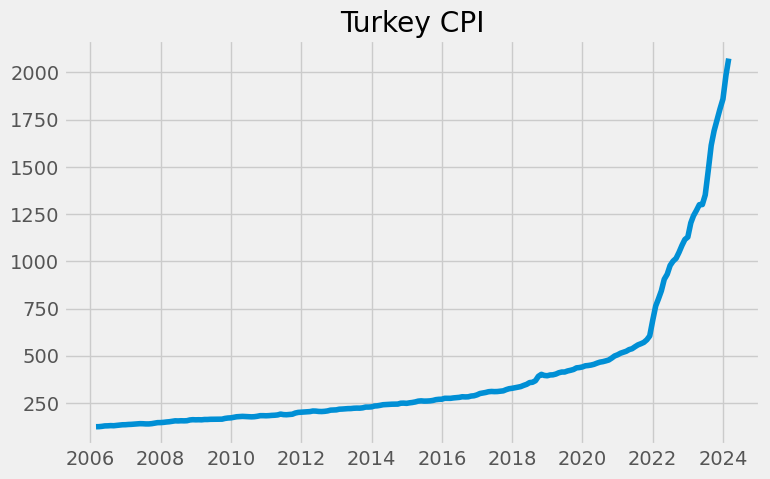

In [663]:
dates=pd.date_range(start="2006-02-28",periods=len(enf) , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure(figsize=(8,5))
plt.title("Turkey CPI")
plt.plot(df)
plt.show()


In [664]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6.iloc[-1,0]=32.04
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-11-30,28.637082
2023-12-31,29.074857
2024-01-31,30.053750


In [665]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="01-01-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
del money["YEARWEEK"]
money=pd.DataFrame(money)
money.columns=["Tarih","Para Arzi"]
money=money.set_index(pd.to_datetime(money["Tarih"], format='%d-%m-%Y'))
del money["Tarih"]
money=money.resample('M').last()
money=money.pct_change(1)*100
money=money.dropna()
money

,Para Arzi
Tarih,
2006-02-28,2.121748
2006-03-31,2.927613
2006-04-30,1.084694
2006-05-31,9.121170
2006-06-30,1.433197
...,...
2023-11-30,2.245991
2023-12-31,4.333376
2024-01-31,0.993354


In [666]:
m3=evds.get_data(["TP.PR.ARZ22"],startdate="01-01-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
del m3["YEARWEEK"]
m3=pd.DataFrame(m3)
m3.columns=["Tarih","M3"]
m3=m3.set_index(pd.to_datetime(m3["Tarih"], format='%d-%m-%Y'))
del m3["Tarih"]
m3

,M3
Tarih,
2006-01-06,2.644879e+08
2006-01-13,2.650229e+08
2006-01-20,2.594222e+08
2006-01-27,2.605798e+08
2006-02-03,2.600928e+08
...,...
2024-02-09,1.420413e+10
2024-02-16,1.438121e+10
2024-02-23,1.451008e+10


In [667]:
m3=evds.get_data(["TP.PR.ARZ22"],startdate="01-01-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
del m3["YEARWEEK"]
m3=pd.DataFrame(m3)
m3.columns=["Tarih","M3"]
m3=m3.set_index(pd.to_datetime(m3["Tarih"], format='%d-%m-%Y'))
del m3["Tarih"]
m3=m3.pct_change(4)*100
m3=m3.resample('M').last()
m3=m3.dropna()
m3

,M3
Tarih,
2006-02-28,2.204708
2006-03-31,2.711175
2006-04-30,1.323922
2006-05-31,9.308200
2006-06-30,-0.288618
...,...
2023-11-30,2.464258
2023-12-31,4.417846
2024-01-31,1.120968


In [668]:

issizlik=evds.get_data(["TP.TIG08"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del issizlik["Tarih"]
issizlik.columns=["İşsizlik"]
issizlik=issizlik.dropna(axis=0)
issizlik=issizlik.set_index(pd.date_range(start="2014-01-30",periods=len(issizlik),freq="1M"))
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2023-09-30,9.1
2023-10-31,8.6
2023-11-30,9.0
2023-12-31,8.9


In [669]:
import yfinance as yf
df14=yf.download("BZ=F")["Close"]
df14=pd.DataFrame(df14)
df14.columns=["Brent"]
df14=df14.resample('M').mean()
df14

[*********************100%%**********************]  1 of 1 completed


,Brent
Date,
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2023-11-30,82.027727
2023-12-31,77.324000
2024-01-31,79.197143


In [670]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
del kredi["Tarih"]
del kredi["YEARWEEK"]
kredi=kredi.set_index(pd.date_range(start="2006-02-03",periods=len(kredi),freq="W"))
kredi.columns=["Kredi"]
kredi=(kredi.pct_change(4)*100).dropna()
kredi=kredi.resample('M').last()
kredi

,Kredi
2006-03-31,4.327119
2006-04-30,3.124932
2006-05-31,8.993162
2006-06-30,3.364474
2006-07-31,-0.493205
...,...
2023-11-30,2.932091
2023-12-31,2.873464
2024-01-31,1.789324
2024-02-29,3.130261


In [671]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=pd.date_range(start="2006-03-28",periods=len(df3),freq="1M")
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=df3.set_index(pd.date_range('2006-03-28',periods=len(df3) , freq='1M'))
df3

,Kredi
2006-03-31,4.327119
2006-04-30,3.124932
2006-05-31,8.993162
2006-06-30,3.364474
2006-07-31,-0.493205
...,...
2023-11-30,2.932091
2023-12-31,2.873464
2024-01-31,1.789324
2024-02-29,3.130261


In [672]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
#pfaiz.iloc[212,1]=35
pfaiz



,Tarih,Faiz
0,2006-2,17.50
1,2006-3,17.50
2,2006-4,17.50
3,2006-5,17.50
4,2006-6,17.50
...,...,...
213,2023-11,41.09
214,2023-12,42.50
215,2024-1,44.00
216,2024-2,45.00


In [673]:
dates=pd.date_range('2006-02-28',periods=len(pfaiz) , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

,Politika Faizi
TIME,
2006-02-28,17.50
2006-03-31,17.50
2006-04-30,17.50
2006-05-31,17.50
2006-06-30,17.50
...,...
2023-11-30,41.09
2023-12-31,42.50
2024-01-31,44.00


In [674]:
kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
del kfaiz["Tarih"]
del kfaiz["YEARWEEK"]
kfaiz=kfaiz.set_index(pd.date_range(start="2006-02-01",periods=len(kfaiz),freq="1W"))
kfaiz=kfaiz.resample('M').apply(lambda x : x[-2:].iloc[-1])
kfaiz.columns=["Kredi Faizi"]
kfaiz

,Kredi Faizi
2006-02-28,17.02
2006-03-31,16.88
2006-04-30,15.84
2006-05-31,16.60
2006-06-30,20.35
...,...
2023-11-30,58.61
2023-12-31,58.16
2024-01-31,59.41
2024-02-29,59.02


In [675]:
perakende=pd.read_excel("./perakende satis hacim endeksi ve degisim oranlari (sabit fiyatlarla) (2015=100).xls")
perakende1=perakende.iloc[5:,2].dropna(axis=0).astype(float)
perakende1=pd.DataFrame(perakende1)
perakende1.columns=["Arındırılmamış"]


perakende1["Takvimden Arındırılmış"]=perakende.iloc[5:,4].astype(float)
perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]=perakende.iloc[5:,7].astype(float)
perakende1=perakende1.set_index(pd.date_range(start="2010-01-01",periods=len(perakende1),freq="1M"))
perakende1

,Arındırılmamış,Takvimden Arındırılmış,Mevsimsellikten ve Takvimden Arındırılmış
2010-01-31,57.403841,57.747949,67.560585
2010-02-28,57.317027,57.179176,68.192727
2010-03-31,67.904361,67.034985,69.536955
2010-04-30,67.048510,66.458455,70.175625
2010-05-31,70.327428,70.614865,70.604236
...,...,...,...
2023-08-31,185.330997,183.564524,176.254302
2023-09-30,184.673020,183.157065,174.785903
2023-10-31,182.582955,180.947621,178.237289
2023-11-30,183.908595,182.048518,178.930674


In [676]:
motorin=pd.read_excel("./motorin.xlsx")
motorin.columns=["Tarih","Motorin"]
motorin=motorin.set_index(pd.date_range(start="2003-01-01",periods=len(motorin),freq="1M"))
del motorin["Tarih"]
motorin=motorin.astype(float)
motorin

,Motorin
2003-01-31,1.366645
2003-02-28,1.457199
2003-03-31,1.529555
2003-04-30,1.439813
2003-05-31,1.404363
...,...
2023-10-31,38.900000
2023-11-30,37.680000
2023-12-31,36.420000
2024-01-31,39.450000


In [677]:
sanayi=pd.read_excel("./sanayi uretim endeksi ve degisim oranlari (2015=100).xls")
sanayi=pd.DataFrame(sanayi.iloc[8:,5])
sanayi.columns=["Sanayi"]
sanayi=sanayi.set_index(pd.date_range(start="2005-02-08",periods=len(sanayi),freq="1M"))
sanayi=sanayi.dropna()
sanayi=sanayi.astype(float)
sanayi

,Sanayi
2005-02-28,57.747916
2005-03-31,57.058754
2005-04-30,57.685141
2005-05-31,58.226534
2005-06-30,58.022939
...,...
2023-08-31,146.075796
2023-09-30,145.853837
2023-10-31,145.491300
2023-11-30,143.444185


In [678]:
mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="03-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
#mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-01",end="2024-01-01",freq="1M"))
del mfaiz["YEARWEEK"]
del mfaiz["Tarih"]
mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-03",periods=len(mfaiz),freq="W"))
mfaiz=mfaiz.resample('M').apply(lambda x : x[-2:].iloc[-1])

mfaiz.columns=["Mevduat Faizi"]
mfaiz

,Mevduat Faizi
2006-02-28,15.70
2006-03-31,14.84
2006-04-30,14.87
2006-05-31,14.84
2006-06-30,15.57
...,...
2023-11-30,46.07
2023-12-31,52.50
2024-01-31,49.61
2024-02-29,51.89


In [679]:
from datetime import date
enf_belirsizlik=evds.get_data(["TP.BEK.S01.E.S"],startdate="30-06-2013",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2013-06-30",periods=len(enf_belirsizlik),freq="1M"))
del enf_belirsizlik["Tarih"]
enf_belirsizlik.columns=["Enflasyon Belirsizliği"]
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-11-30,4.49
2023-12-31,3.36
2024-01-31,3.50
2024-02-29,3.41


In [680]:
borc=evds.get_data(["TP.KB.A09"],startdate="01-01-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del borc["Tarih"]
borc=borc.set_index(pd.date_range(start="2006-01-01",periods=len(borc),freq="1M"))
borc.columns=["Borç"]
borc

,Borç
2006-01-31,2.435600e+08
2006-02-28,2.464270e+08
2006-03-31,2.463600e+08
2006-04-30,2.466640e+08
2006-05-31,2.507320e+08
...,...
2023-09-30,2.859751e+09
2023-10-31,2.966763e+09
2023-11-30,3.086466e+09
2023-12-31,3.209252e+09


In [681]:
redk=evds.get_data(["TP.RK.U01.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redk["Tarih"]
redk=redk.set_index(pd.date_range(start="2011-03-30",periods=len(redk),freq="1M"))
redk.columns=["REDK"]
redk

,REDK
2011-03-31,105.42
2011-04-30,107.10
2011-05-31,103.79
2011-06-30,101.84
2011-07-31,98.49
...,...
2023-10-31,89.18
2023-11-30,87.41
2023-12-31,86.37
2024-01-31,87.20


In [682]:
redkt=evds.get_data(["TP.RK.T1.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redkt["Tarih"]
redkt=redkt.set_index(pd.date_range(start="2011-03-30",periods=len(redkt),freq="1M"))
redkt.columns=["REDKT"]
redkt

,REDKT
2011-03-31,111.62
2011-04-30,114.17
2011-05-31,112.89
2011-06-30,108.98
2011-07-31,104.82
...,...
2023-10-31,56.06
2023-11-30,55.29
2023-12-31,55.33
2024-01-31,57.12


In [683]:
beklenti=evds.get_data(["TP.BEK.S01.A.U"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del beklenti["Tarih"]
beklenti=beklenti.set_index(pd.date_range(start="2011-03-30",periods=len(beklenti),freq="1M"))
beklenti.columns=["beklenti"]
beklenti=beklenti.dropna()
beklenti

,beklenti
2013-01-31,0.85
2013-02-28,0.53
2013-03-31,0.48
2013-04-30,0.65
2013-05-31,0.46
...,...
2023-11-30,4.07
2023-12-31,3.26
2024-01-31,5.41
2024-02-29,3.80


In [684]:
data=pd.DataFrame()
data["USD/TL"]=df6["USD/TL"].rolling(3).mean()
#data["USD/TL2"]=df6["USD/TL"]
#data["USD/TL3"]=df6["USD/TL"]**2
#data["USD/TL4"]=df6["USD/TL"]**3
#data["USD/TL5"]=df6["USD/TL"].shift(1)
data["Motorin"]=motorin["Motorin"]
data["Perakende Satış"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]
data["Sanayi"]=sanayi["Sanayi"]
data["Borç"]=(borc["Borç"]).shift(1)
data["TÜFE"]=df["CPI"]
data=data.pct_change()*100
data["M3"]=m3["M3"].shift(1)
data["REDK"]=redk["REDK"].pct_change()*100
data["REDKT"]=redkt["REDKT"].pct_change()*100
data

,USD/TL,Motorin,Perakende Satış,Sanayi,Borç,TÜFE,M3,REDK,REDKT
Tarih,,,,,,,,,
2006-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-31,NaN,0.975610,NaN,2.437308,1.177123,0.274548,2.204708,NaN,NaN
2006-04-30,NaN,2.898551,NaN,-0.738864,-0.027189,1.336769,2.711175,NaN,NaN
2006-05-31,2.353679,4.694836,NaN,0.882710,0.123397,1.875397,1.323922,NaN,NaN
2006-06-30,6.483947,5.829596,NaN,0.536906,1.649207,0.335413,9.308200,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-11-30,2.001541,-3.136247,0.389023,-1.407036,3.741984,3.281097,3.374057,-1.984750,-1.373528
2023-12-31,2.498315,-3.343949,1.735783,2.411073,4.034830,2.927207,2.464258,-1.189795,0.072346
2024-01-31,2.580279,8.319605,0.000000,0.000000,3.978186,6.703310,4.417846,0.960982,3.235135


In [685]:

data["Kredi"]=df3["Kredi"].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["İşsizlik"]=issizlik["İşsizlik"]
data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Kredi Faizi"]=kfaiz["Kredi Faizi"]
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Politika Faizi"]=pfaiz["Politika Faizi"]
data["Zam"]=0
data["Beklenti"]=beklenti["beklenti"]
data=data[['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi','Zam', 'Sanayi','M3', 'Enflasyon Belirsizliği','ParaArzi','Borç','Kredi','Mevduat Faizi','REDK','REDKT','İşsizlik','Politika Faizi','Beklenti','TÜFE']]
data.iloc[11:23,4]=411
data.iloc[23:35,4]=490
data.iloc[35:47,4]=537
data.iloc[47:59,4]=587
data.iloc[59:71,4]=645
data.iloc[71:83,4]=720
data.iloc[83:95,4]=785
data.iloc[95:107,4]=870
data.iloc[107:119,4]=975
data.iloc[119:131,4]=1300.99
data.iloc[131:143,4]=1404.6
data.iloc[143:155,4]=1603.12
data.iloc[155:167,4]=2020.59
data.iloc[167:179,4]=2324.70
data.iloc[179:191,4]=2825.90
data.iloc[191:197,4]=4253.40
data.iloc[197:203,4]=5500.35
data.iloc[203:209,4]=8506.80
data.iloc[209:215,4]=11402.32
data.iloc[215:,4]=17002
data["Zam"]=data["Zam"].pct_change()*100
data=data.fillna(0)
data=data.iloc[95:-1]
data

,USD/TL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,M3,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,İşsizlik,Politika Faizi,Beklenti,TÜFE
Tarih,,,,,,,,,,,,,,,,,,
2014-01-31,3.732429,2.881984,3.944616,13.80,10.828025,3.604096,3.413428,0.82,3.375162,-0.584687,2.669930,8.85,-3.691204,-5.094658,9.2,9.96,1.06,1.978080
2014-02-28,3.033477,1.685899,-4.487196,15.54,0.000000,-0.850238,1.958423,0.73,1.804994,0.808574,1.876850,10.75,2.179150,0.919060,9.5,10.23,0.69,0.428192
2014-03-31,2.465778,-2.278097,-0.070420,16.05,0.000000,0.128936,0.229599,0.80,0.451349,0.193691,0.822203,11.65,0.471546,0.641623,9.5,10.27,0.65,1.125608
2014-04-30,-1.344724,-6.214384,-0.769499,15.65,0.000000,-0.863760,0.730196,0.73,0.796760,0.478162,-0.154556,10.75,4.682667,5.892031,9.7,10.03,0.76,1.344970
2014-05-31,-1.859714,-0.561578,0.433585,15.36,0.000000,-1.367417,-0.093468,0.80,-0.362357,0.091080,0.146305,10.43,1.283880,2.058652,9.7,9.53,0.63,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31,1.709911,-0.714650,1.974636,58.43,0.000000,-0.248562,3.032340,5.57,2.694232,3.653039,1.782758,41.72,-0.033629,0.936262,8.6,33.00,4.30,3.433981
2023-11-30,2.001541,-3.136247,0.389023,58.61,0.000000,-1.407036,3.374057,4.49,3.356297,3.741984,2.499767,46.07,-1.984750,-1.373528,9.0,41.09,4.07,3.281097
2023-12-31,2.498315,-3.343949,1.735783,58.16,0.000000,2.411073,2.464258,3.36,2.245991,4.034830,2.653509,52.50,-1.189795,0.072346,8.9,42.50,3.26,2.927207


In [686]:
data=data.drop(["Perakende Satış","Kredi Faizi","Sanayi"],axis=1)

In [687]:
data.iloc[-1,-4]=9.0
data.iloc[-2,-4]=9.0

In [688]:
data["Borç"].iloc[-1]=3.9311

In [689]:
data=data.drop('Beklenti',axis=1)
data

,USD/TL,Motorin,Zam,M3,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,İşsizlik,Politika Faizi,TÜFE
Tarih,,,,,,,,,,,,,,
2014-01-31,3.732429,2.881984,10.828025,3.413428,0.82,3.375162,-0.584687,2.669930,8.85,-3.691204,-5.094658,9.2,9.96,1.978080
2014-02-28,3.033477,1.685899,0.000000,1.958423,0.73,1.804994,0.808574,1.876850,10.75,2.179150,0.919060,9.5,10.23,0.428192
2014-03-31,2.465778,-2.278097,0.000000,0.229599,0.80,0.451349,0.193691,0.822203,11.65,0.471546,0.641623,9.5,10.27,1.125608
2014-04-30,-1.344724,-6.214384,0.000000,0.730196,0.73,0.796760,0.478162,-0.154556,10.75,4.682667,5.892031,9.7,10.03,1.344970
2014-05-31,-1.859714,-0.561578,0.000000,-0.093468,0.80,-0.362357,0.091080,0.146305,10.43,1.283880,2.058652,9.7,9.53,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31,1.709911,-0.714650,0.000000,3.032340,5.57,2.694232,3.653039,1.782758,41.72,-0.033629,0.936262,8.6,33.00,3.433981
2023-11-30,2.001541,-3.136247,0.000000,3.374057,4.49,3.356297,3.741984,2.499767,46.07,-1.984750,-1.373528,9.0,41.09,3.281097
2023-12-31,2.498315,-3.343949,0.000000,2.464258,3.36,2.245991,4.034830,2.653509,52.50,-1.189795,0.072346,8.9,42.50,2.927207


In [1567]:
from pycaret.regression import *
s = setup(data.iloc[:-12,:].drop('ParaArzi',axis=1), target = 'TÜFE', session_id = 123,index=False,normalize=False,fold=10,train_size=0.9,test_data=data.iloc[-12:,:].drop('ParaArzi',axis=1),feature_selection=True,n_features_to_select=13)
best = compare_models(sort="RMSE")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 438
[LightGBM] [Info] Number of data points in the train set: 110, number of used features: 12
[LightGBM] [Info] Start training from score 1.568143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

,Description,Value
0,Session id,123
1,Target,TÜFE
2,Target type,Regression
3,Original data shape,"(122, 14)"
4,Transformed data shape,"(122, 14)"
5,Transformed train set shape,"(110, 14)"
6,Transformed test set shape,"(12, 14)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.8416,1.5939,1.1046,-0.3982,0.3496,2.2131,0.0390
et,Extra Trees Regressor,0.8616,1.9879,1.1138,-0.0283,0.3317,1.7123,0.0980
en,Elastic Net,0.8490,1.9334,1.1210,-0.0441,0.3652,2.1076,0.0400
huber,Huber Regressor,0.8768,1.9286,1.1342,-0.2058,0.3580,2.1994,0.0850
par,Passive Aggressive Regressor,0.8751,1.7842,1.1397,-0.4749,0.3588,2.1187,0.0420
rf,Random Forest Regressor,0.8965,2.2394,1.1894,-0.1098,0.3512,1.9479,0.1200
lasso,Lasso Regression,0.9241,2.4499,1.2039,-0.0728,0.3786,2.2681,0.0440
llar,Lasso Least Angle Regression,0.9242,2.4500,1.2039,-0.0728,0.3786,2.2681,0.0390
ada,AdaBoost Regressor,0.9727,2.3177,1.2134,-0.2749,0.3705,2.0904,0.0660
knn,K Neighbors Regressor,0.8736,2.7591,1.2265,0.0266,0.3564,1.7572,0.0500


In [1568]:
huber = create_model('huber', return_train_score=False,cross_validation=True)
et = create_model('et', return_train_score=False,cross_validation=True)
br = create_model('br', return_train_score=False,cross_validation=True)
en = create_model('en', return_train_score=False,cross_validation=True)
ridge = create_model('ridge', return_train_score=False,cross_validation=True)
lr = create_model('lr', return_train_score=False,cross_validation=True)
lar = create_model('lar', return_train_score=False,cross_validation=True)
lasso = create_model('lasso', return_train_score=False,cross_validation=True)
llar = create_model('llar', return_train_score=False,cross_validation=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5928,0.6341,0.7963,-0.4065,0.3390,0.9715
1,0.4430,0.3252,0.5703,0.3205,0.2321,0.8784
2,0.6287,0.4831,0.6950,-0.4488,0.3929,7.8299
3,0.4094,0.2516,0.5016,0.5301,0.2719,0.6450
4,0.5232,0.4581,0.6768,-0.0839,0.3276,0.5884
5,1.2199,2.2029,1.4842,0.4184,0.4938,8.5760
6,0.6208,0.5630,0.7503,-1.5003,0.3555,0.7040
7,0.4551,0.3352,0.5789,-0.2236,0.2824,0.3989
8,1.4230,6.1779,2.4855,0.6245,0.3048,0.3366


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4712,0.3336,0.5775,0.2601,0.3128,1.0429
1,0.4548,0.3174,0.5633,0.3369,0.1881,0.9607
2,0.5490,0.4155,0.6446,-0.2462,0.3551,5.2964
3,0.5069,0.3806,0.6169,0.2892,0.3020,1.2325
4,0.5176,0.4868,0.6977,-0.1517,0.3335,0.4505
5,1.0673,1.6784,1.2955,0.5569,0.3932,5.8375
6,0.5503,0.4056,0.6368,-0.8012,0.2926,0.7050
7,0.4749,0.3713,0.6093,-0.3555,0.2519,0.3783
8,1.8999,10.1535,3.1865,0.3829,0.3905,0.3650


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6025,0.6566,0.8103,-0.4564,0.3253,1.0119
1,0.4564,0.3642,0.6035,0.2390,0.2512,0.9085
2,0.6287,0.4793,0.6923,-0.4374,0.3967,7.7131
3,0.4427,0.3220,0.5674,0.3987,0.2556,0.6337
4,0.5249,0.4467,0.6683,-0.0569,0.3190,0.6233
5,1.2805,2.2708,1.5069,0.4005,0.5288,8.7507
6,0.7875,0.8884,0.9426,-2.9457,0.3745,0.8476
7,0.7068,0.6728,0.8202,-1.4562,0.3217,0.6306
8,1.2378,5.1955,2.2794,0.6842,0.2663,0.2896


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5424,0.6154,0.7845,-0.3650,0.3060,1.1500
1,0.5400,0.4331,0.6581,0.0950,0.2781,1.1056
2,0.6339,0.4726,0.6875,-0.4175,0.3989,6.9359
3,0.4649,0.2632,0.5130,0.5085,0.2698,0.8222
4,0.5109,0.4313,0.6568,-0.0205,0.2973,0.5870
5,1.3559,2.3649,1.5378,0.3757,0.5408,8.6150
6,0.5374,0.3851,0.6205,-0.7101,0.3214,0.6032
7,0.3926,0.2395,0.4893,0.1258,0.2633,0.3894
8,1.7677,9.0362,3.0060,0.4508,0.3631,0.3469


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6364,0.6829,0.8264,-0.5147,0.3125,1.0799
1,0.5047,0.4054,0.6367,0.1530,0.2677,0.9173
2,0.6460,0.5128,0.7161,-0.5378,0.4046,8.1718
3,0.4630,0.4077,0.6385,0.2387,0.2345,0.5902
4,0.6045,0.5246,0.7243,-0.2413,0.3086,0.6990
5,1.3407,2.7614,1.6617,0.2710,0.5462,9.0210
6,0.9074,1.1107,1.0539,-3.9327,0.4085,1.0106
7,0.7890,0.8767,0.9363,-2.2006,0.3128,0.6796
8,1.1385,4.8777,2.2085,0.7036,0.2572,0.2701


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6370,0.6835,0.8267,-0.5160,0.3125,1.0812
1,0.5063,0.4066,0.6376,0.1505,0.2681,0.9179
2,0.6464,0.5137,0.7167,-0.5405,0.4048,8.1819
3,0.4635,0.4098,0.6402,0.2347,0.2343,0.5893
4,0.6068,0.5273,0.7261,-0.2476,0.3086,0.7013
5,1.3436,2.7836,1.6684,0.2651,0.5468,9.0256
6,0.9106,1.1166,1.0567,-3.9592,0.4088,1.0150
7,0.7910,0.8823,0.9393,-2.2210,0.3130,0.6807
8,1.1378,4.8902,2.2114,0.7028,0.2574,0.2696


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7681,0.8781,0.9371,-0.9478,0.3747,1.4917
1,0.5333,0.4488,0.6700,0.0622,0.2777,0.9618
2,0.6872,0.5777,0.7601,-0.7326,0.4261,8.9736
3,0.5003,0.5036,0.7096,0.0596,0.2109,0.6778
4,0.7070,0.6667,0.8165,-0.5775,0.3409,0.7938
5,1.3307,2.6833,1.6381,0.2916,0.5608,9.1667
6,1.1840,1.9955,1.4126,-7.8625,0.4642,1.3339
7,0.7910,0.8823,0.9393,-2.2210,0.3130,0.6807
8,1.1378,4.8902,2.2114,0.7028,0.2574,0.2696


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5622,0.5615,0.7493,-0.2454,0.3362,1.5324
1,0.6179,0.5370,0.7328,-0.1221,0.3053,1.3351
2,0.6450,0.5391,0.7342,-0.6167,0.4114,7.6824
3,0.4638,0.2610,0.5109,0.5126,0.2485,0.9374
4,0.5227,0.4424,0.6651,-0.0467,0.2905,0.5918
5,1.4114,2.4842,1.5761,0.3442,0.5340,8.6521
6,0.4504,0.2690,0.5187,-0.1949,0.2845,0.5529
7,0.3831,0.1954,0.4420,0.2867,0.2376,0.3763
8,2.1483,12.7996,3.5777,0.2221,0.4692,0.3922


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5622,0.5615,0.7493,-0.2454,0.3362,1.5324
1,0.6179,0.5370,0.7328,-0.1221,0.3053,1.3351
2,0.6450,0.5391,0.7342,-0.6167,0.4114,7.6824
3,0.4638,0.2610,0.5109,0.5126,0.2485,0.9375
4,0.5227,0.4424,0.6651,-0.0467,0.2905,0.5918
5,1.4114,2.4843,1.5762,0.3442,0.5340,8.6523
6,0.4504,0.2690,0.5187,-0.1949,0.2845,0.5529
7,0.3831,0.1954,0.4420,0.2867,0.2376,0.3763
8,2.1483,12.7998,3.5777,0.2221,0.4692,0.3922


In [1570]:
features=huber.feature_names_in_
features

array(['USD/TL', 'Motorin', 'Zam', 'M3', 'Enflasyon Belirsizliği', 'Borç',
       'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik',
       'Politika Faizi', 'TÜFE Lag'], dtype=object)

In [1571]:
huber = create_model('huber', return_train_score=False,cross_validation=True)
en = create_model('en', return_train_score=False,cross_validation=True)
br = create_model('br', return_train_score=False,cross_validation=True)
en = create_model('en', return_train_score=False,cross_validation=True)
ridge = create_model('ridge', return_train_score=False,cross_validation=True)
lr = create_model('lr', return_train_score=False,cross_validation=True)
lar = create_model('lar', return_train_score=False,cross_validation=True)
lasso = create_model('lasso', return_train_score=False,cross_validation=True)
llar = create_model('llar', return_train_score=False,cross_validation=True)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,00:54:06
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Huber Regressor


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [1587]:
tune_model(ridge, search_library='scikit-learn', search_algorithm='random',optimize="RMSE")

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,00:56:12
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Ridge Regression


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5727,0.5816,0.7626,-0.2901,0.3290,1.0354
1,0.4887,0.3893,0.6239,0.1866,0.2624,0.8935
2,0.6438,0.5080,0.7127,-0.5236,0.4033,8.1389
3,0.4567,0.3855,0.6209,0.2801,0.2338,0.6094
4,0.5918,0.5097,0.7140,-0.2061,0.3103,0.6869
5,1.3096,2.5895,1.6092,0.3164,0.5351,8.7373
6,0.8601,1.0323,1.0160,-3.5846,0.3946,0.9501
7,0.7476,0.7893,0.8884,-1.8814,0.3065,0.6630
8,1.1412,4.7703,2.1841,0.7101,0.2498,0.2637


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Ridge(alpha=8.1, fit_intercept=False, random_state=123)

In [1588]:
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor
from sklearn.linear_model import ElasticNet,Ridge,Lars,PassiveAggressiveRegressor,Lasso,LassoLars,BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
model=Ridge(alpha=8.1, fit_intercept=False, random_state=123)
model.fit(data[features].iloc[:-1],data["TÜFE"].iloc[:-1])
model.predict(data[features].iloc[-1:])

array([4.12122256])

In [1590]:
model=Ridge( random_state=123)
model.fit(data[features],data["TÜFE"])
model.predict(tahmindf[features])

array([3.46527658, 3.23637984, 3.67764867, 3.83163091, 3.48672449,
       3.34545133, 3.03110126, 2.93802763, 2.76663295, 3.25060754,
       4.6767332 , 2.70688747, 2.51686519, 2.61962555])

In [1501]:
from sklearn.ensemble import ExtraTreesRegressor
model=Lars( random_state=123)
data1=data[features]
data1["TÜFE"]=data["TÜFE"]
model.fit(data1.iloc[:-12,:-1],data1["TÜFE"].iloc[:-12])
pred=model.predict(data1.iloc[-12:,:-1])
mean_squared_error(data1["TÜFE"].iloc[-12:],pred)

4.775100330731188

In [883]:
pred[-2]=6.18
mean_squared_error(data1["TÜFE"].iloc[-12:],pred)

0.5776069020488787

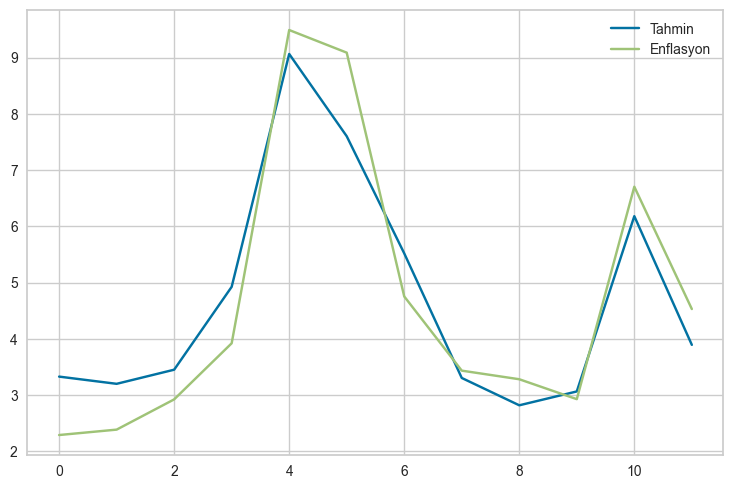

In [884]:
plt.plot(pred,label="Tahmin")
plt.plot(data1["TÜFE"].iloc[-12:].values,label="Enflasyon")
plt.legend()

In [75]:
"""from sklearn.linear_model import BayesianRidge,HuberRegressor
from sklearn.metrics import mean_squared_error
data1=data[features]
data1["TÜFE"]=data["TÜFE"]
X_train,X_test,y_train,y_test=data1.iloc[:-12,:-1],data1.iloc[-12:,:-1],data1.iloc[:-12,-1],data1.iloc[-12:,-1]
mean_squared_error(y_test,huber.predict(X_test))"""

'from sklearn.linear_model import BayesianRidge,HuberRegressor\nfrom sklearn.metrics import mean_squared_error\ndata1=data[features]\ndata1["TÜFE"]=data["TÜFE"]\nX_train,X_test,y_train,y_test=data1.iloc[:-12,:-1],data1.iloc[-12:,:-1],data1.iloc[:-12,-1],data1.iloc[-12:,-1]\nmean_squared_error(y_test,huber.predict(X_test))'

In [76]:
model=auto_arima(pfaiz["Politika Faizi"],seasonal=False,information_criterion="bic")
model_fit = model.fit(pfaiz["Politika Faizi"])
faiztahmin = model_fit.predict(25)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Politika Faizi"]
row=pd.DataFrame({"Politika Faizi":pfaiz.iloc[-4:,0]},index=pd.date_range(start="2023-12-30",periods=4,freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)
faiztahmin.iloc[4:,0]=[45,45,45,45,45,45,45,45,45,45,42.5,40,37.5,35,35,35,35,35,35,35,32.5,30,27.5,25,25]
faiztahmin

,Politika Faizi
2023-12-31,42.50
2024-01-31,44.00
2024-02-29,45.00
2024-03-31,46.32
2024-04-30,45.00
2024-05-31,45.00
2024-06-30,45.00
2024-07-31,45.00
2024-08-31,45.00
2024-09-30,45.00


In [77]:
model=auto_arima(kfaiz["Kredi Faizi"],seasonal=True,X=np.array(pfaiz["Politika Faizi"]).reshape(-1,1),information_criterion="aic",m=9)
model_fit = model.fit(kfaiz["Kredi Faizi"])

forecast = model_fit.predict(25,X=np.array(faiztahmin["Politika Faizi"][3:]).reshape(-1,1))
kfaiztahmin=pd.DataFrame(forecast)
kfaiztahmin.columns=["Kredi Faizi"]
new_row=pd.DataFrame({"Kredi Faizi":kfaiz.iloc[211:,0]},index=kfaiz.index[211:])
kfaiztahmin=pd.concat([new_row,kfaiztahmin],axis=0)
kfaiztahmin



,Kredi Faizi
2023-09-30,57.560000
2023-10-31,58.430000
2023-11-30,58.610000
2023-12-31,58.160000
2024-01-31,59.410000
2024-02-29,59.020000
2024-03-31,61.660000
2024-04-30,62.808862
2024-05-31,63.863664
2024-06-30,64.250988


In [78]:
trainexog=kfaiz[47:-2]
trainexog

,Kredi Faizi
2010-01-31,13.76
2010-02-28,13.36
2010-03-31,13.10
2010-04-30,13.18
2010-05-31,13.25
...,...
2023-09-30,57.56
2023-10-31,58.43
2023-11-30,58.61
2023-12-31,58.16


In [79]:
testexog=kfaiztahmin[2:]
testexog

,Kredi Faizi
2023-11-30,58.610000
2023-12-31,58.160000
2024-01-31,59.410000
2024-02-29,59.020000
2024-03-31,61.660000
2024-04-30,62.808862
2024-05-31,63.863664
2024-06-30,64.250988
2024-07-31,63.933625
2024-08-31,63.284855


In [80]:
model=auto_arima(mfaiz["Mevduat Faizi"],X=pfaiz,trace=False,seasonal=False,information_criterion="aic")
mfaiztahmin=pd.DataFrame(model.predict(26,X=faiztahmin[3:]))
mfaiztahmin.columns=["Mevduat Faizi"]
row=pd.DataFrame({"Mevduat Faizi":mfaiz.iloc[-2:,0]},index=pd.date_range(start="2024-02-28",periods=2,freq="1M"))
mfaiztahmin=pd.concat([row,mfaiztahmin],axis=0)
mfaiztahmin


,Mevduat Faizi
2024-02-29,51.890000
2024-03-31,53.630000
2024-04-30,50.995243
2024-05-31,51.355106
2024-06-30,52.254716
2024-07-31,50.823970
2024-08-31,51.452556
2024-09-30,51.864411
2024-10-31,51.093757
2024-11-30,51.480647


In [81]:
trainexog=pd.DataFrame()
trainexog["Dolar"]=usd.iloc[-16:-6,0].rolling(2).mean().dropna()*df14.iloc[:-6,0]
trainexog=trainexog.dropna()
trainexog=np.array(trainexog).reshape(-1,1)
testexog=pd.DataFrame()
testexog["Dolar"]=usd.iloc[-7:,0].rolling(2).mean().dropna()*df14.iloc[-6:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [82]:
exog=pd.DataFrame()
exog["X"]=usd["TP_DK_USD_S_YTL"].rolling(2).mean().dropna()*df14["Brent"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


,X
2007-07-31,99.454046
2007-08-31,92.519699
2007-09-30,99.580871
2007-10-31,101.824103
2007-11-30,110.143119
...,...
2023-11-30,2316.594077
2023-12-31,2231.258978
2024-01-31,2341.408383
2024-02-29,2484.349416


In [83]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,0,0,0,0,49.11,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,25]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-02-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0.00
2023-09-30,0.00
2023-10-31,0.00
2023-11-30,0.00
2023-12-31,0.00
2024-01-31,49.11
2024-02-29,0.00
2024-03-31,0.00
2024-04-30,0.00
2024-05-31,0.00


In [84]:
faiztahmin.columns=["Faiz"]


In [85]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Politika Faizi"].iloc[95:-14]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Politika Faizi"].iloc[-14:-2],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [86]:
exog=pfaiz["Politika Faizi"].iloc[95:-2]
exog=np.array(exog).reshape(-1,1)

In [87]:
exogtest=faiztahmin.iloc[2:]
exogtest=np.array(exogtest).reshape(-1,1)

In [88]:
model=auto_arima(issizlik,seasonal=True,m=3,X=exog)
model_fit = model.fit(issizlik,X=exog)
issizliktahmin = model_fit.predict(27,X=exogtest)
issizliktahmin=pd.DataFrame(issizliktahmin)
issizliktahmin.columns=["İşsizlik"]
issizliktahmin

,İşsizlik
2024-02-29,9.197980
2024-03-31,9.172428
2024-04-30,9.223137
2024-05-31,9.247148
2024-06-30,9.241430
2024-07-31,9.253224
2024-08-31,9.259024
2024-09-30,9.257643
2024-10-31,9.260492
2024-11-30,9.261893


In [89]:
from prophet import Prophet


In [90]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"])

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df6.index
    sn["y"]=df6.values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"])
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df6.values,predictions["yhat"][:-13])
    return mae_score
try:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=1000)
    print("Optimize işlemi başarıyla tamamlandı.")
except Exception as e:
    print(f'Hata oluştu: {e}')
    print('Optimize işlemi başarısız oldu. Devam ediyor...')
"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"])\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df6.index\n    sn["y"]=df6.values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],se

In [91]:
"""study.best_params"""

'study.best_params'

In [92]:
sn=pd.DataFrame()
sn["ds"]=df6.index
sn["y"]=df6.values
prophet=Prophet(growth="linear",changepoint_prior_scale=7.349638369822835,changepoint_range=0.9894193005763949,seasonality_prior_scale=9.159423931839974,n_changepoints=89,interval_width=0.70,yearly_seasonality=False,weekly_seasonality=False)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=26,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

19:53:45 - cmdstanpy - INFO - Chain [1] start processing
19:53:45 - cmdstanpy - INFO - Chain [1] done processing


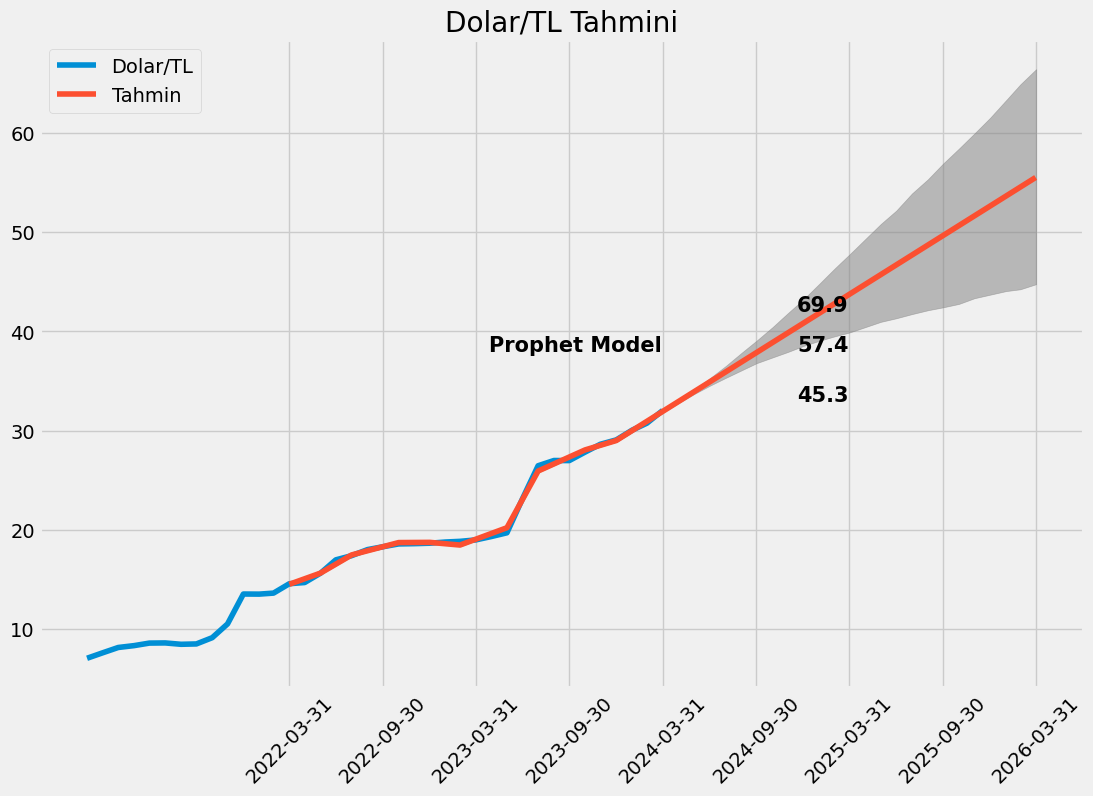

In [93]:
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
plt.plot(df6["USD/TL"][-38:],label='Dolar/TL')
plt.plot(predictions["yhat"][-51:-2],label='Tahmin')
annotation_date = mdates.datestr2num('2025-03-30')
annotation_date1 = mdates.datestr2num('2024-03-30')
plt.text(annotation_date1, 38,  "Prophet Model",fontsize=15, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 38,  str(predictions["yhat"][-1])[:4],fontsize=15, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 33,  str(predictions["yhat_lower"][-1])[:4],fontsize=15, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 42,  str(predictions["yhat_upper"][-1])[:4],fontsize=15, color='black', horizontalalignment='right',fontweight='bold')
plt.fill_between(predictions["yhat"][-51:-1].index.strftime("%Y-%m"), predictions["yhat_upper"][-51:-1].shift(1), predictions["yhat_lower"][-51:-1].shift(1), alpha=0.5, color='gray')
plt.xticks(predictions.index[-51:-2:6],rotation=45)
plt.title('Dolar/TL Tahmini')
plt.legend(loc=2)

In [94]:
usdtahmin=(predictions["yhat"][-27:].pct_change(periods=1)*100).dropna()
usdtahmin

ds
2024-04-30    3.029874
2024-05-31    3.038798
2024-06-30    2.854043
2024-07-31    2.867343
2024-08-31    2.787418
2024-09-30    2.624350
2024-10-31    2.642480
2024-11-30    2.491404
2024-12-31    2.511870
2025-01-31    2.450321
2025-02-28    2.160260
2025-03-31    2.341142
2025-04-30    2.213793
2025-05-31    2.238040
2025-06-30    2.118434
2025-07-31    2.143637
2025-08-31    2.098650
2025-09-30    1.989205
2025-10-31    2.015421
2025-11-30    1.911875
2025-12-31    1.938542
2026-01-31    1.901677
2026-02-28    1.685589
2026-03-31    1.835253
2026-04-30    1.744044
2026-05-31    1.771287
Name: yhat, dtype: float64

In [95]:
usdtahmin1 = []
result = df6.iloc[-1,0]
for i in range(len(usdtahmin)):
    result *= (1 + usdtahmin[i] / 100)
    usdtahmin1.append(result)

usdtahmin1 = np.array(usdtahmin1).reshape(-1, 1)
usdtahmin1 = pd.DataFrame(usdtahmin1)
usdtahmin1.columns = ["USD/TL"]
usdtahmin1=pd.concat([df6.iloc[-6:],usdtahmin1],axis=0)
usdtahmin1 = usdtahmin1.set_index(pd.date_range(start="2023-10-30", periods=len(usdtahmin1), freq="1M"))
usdtahmin1

,USD/TL
2023-10-31,27.846114
2023-11-30,28.637082
2023-12-31,29.074857
2024-01-31,30.053750
2024-02-29,30.759448
2024-03-31,32.040000
2024-04-30,33.010771
2024-05-31,34.013902
2024-06-30,34.984673
2024-07-31,35.987804


In [96]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'growth':trial.suggest_categorical('growth',['linear'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df14[50:].index
    sn["y"]=df14[50:].values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df14[50:].index\n    sn["y"]=df14[50:].values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\nstudy = optuna.create_study(direction=

In [97]:
"""study.best_params"""

'study.best_params'

In [98]:
sn=pd.DataFrame()
sn["ds"]=df14.index
sn["y"]=df14.values
prophet=Prophet(growth="linear",changepoint_prior_scale=9.333547662504625,changepoint_range=0.9362159367416,seasonality_prior_scale=2.378940289163559,n_changepoints=98)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

19:53:46 - cmdstanpy - INFO - Chain [1] start processing


19:53:47 - cmdstanpy - INFO - Chain [1] done processing


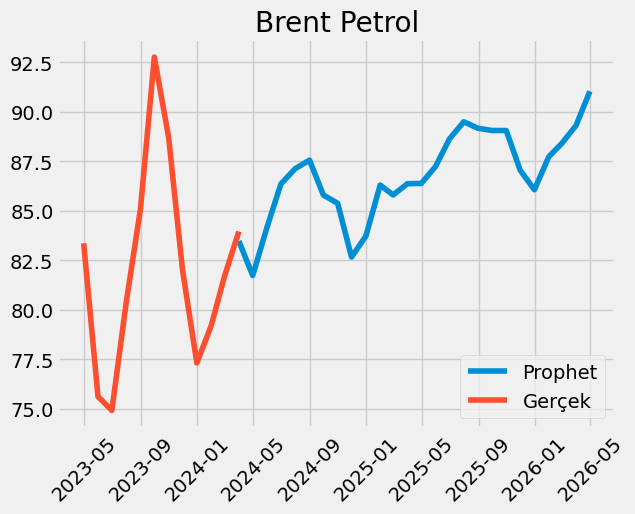

In [99]:
plt.title("Brent Petrol")
plt.plot(predictions["yhat"][-26:],label="Prophet")
plt.plot(df14["Brent"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [100]:
brenttahmin=predictions["yhat"][-28:]
brenttahmin

ds
2024-01-31    79.105939
2024-02-29    83.239865
2024-03-31    83.479600
2024-04-30    81.735152
2024-05-31    84.175579
2024-06-30    86.359175
2024-07-31    87.133001
2024-08-31    87.562278
2024-09-30    85.800275
2024-10-31    85.382364
2024-11-30    82.670270
2024-12-31    83.725266
2025-01-31    86.304146
2025-02-28    85.804527
2025-03-31    86.372869
2025-04-30    86.385667
2025-05-31    87.242766
2025-06-30    88.632020
2025-07-31    89.499116
2025-08-31    89.168284
2025-09-30    89.059975
2025-10-31    89.055094
2025-11-30    87.060880
2025-12-31    86.065686
2026-01-31    87.730762
2026-02-28    88.401962
2026-03-31    89.305399
2026-04-30    91.035799
Name: yhat, dtype: float64

In [101]:
sn=pd.DataFrame()
sn["ds"]=enf_belirsizlik.index
sn["y"]=enf_belirsizlik.values
sn["USD"]=df6.values[88:]

In [102]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'growth':trial.suggest_categorical('growth',['linear'])

            

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=enf_belirsizlik.index
    sn["y"]=enf_belirsizlik.values
    sn["USD"]=(df6.pct_change()*100)[88:-1].dropna().values
    prophet=Prophet(**params)
    prophet.add_regressor('USD')
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    future_dates["USD"]=pd.concat([sn["USD"],usdtahmin.head(13)],axis=0).values
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n\n            \n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=enf_belirsizlik.index\n    sn["y"]=enf_belirsizlik.values\n    sn["USD"]=(df6.pct_change()*100)[88:-1].dropna().values\n    prophet=Prophet(**params)\n    prophet.add_regressor(\'USD\')\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    future_dates["USD"]=pd.concat([sn["USD"],usdtahmin.head(13)],axis=0).values\n    predictions=prophet.predict(fut

In [103]:
"""study.best_params"""

'study.best_params'

19:53:47 - cmdstanpy - INFO - Chain [1] start processing


19:53:48 - cmdstanpy - INFO - Chain [1] done processing


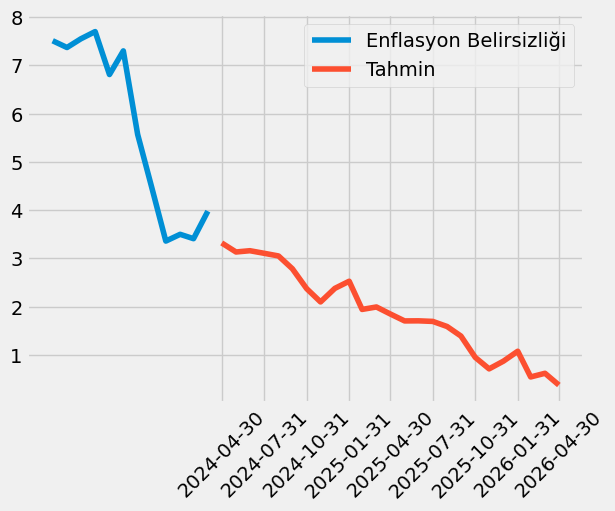

In [104]:
sn=pd.DataFrame()
sn["ds"]=enf_belirsizlik.index
sn["y"]=enf_belirsizlik.values
prophet=Prophet(changepoint_prior_scale=3.2891424441378785,changepoint_range=0.9994901336677199,seasonality_prior_scale=0.1653403857042852,n_changepoints=44,growth="linear")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])
plt.plot(enf_belirsizlik[-12:],label="Enflasyon Belirsizliği")
plt.plot(predictions["yhat"][-25:],label="Tahmin")
plt.xticks(predictions.index[-25::3],rotation=45)
plt.legend()


In [105]:
enfbelirsizliktahmin1=pd.DataFrame(predictions["yhat"][-26:])
enfbelirsizliktahmin1.columns=["Enflasyon Belirsizliği"]
enfbelirsizliktahmin1.index.names=[""]
enfbelirsizliktahmin1.iloc[0,0]=enf_belirsizlik.iloc[-1,0]
enfbelirsizliktahmin1

,Enflasyon Belirsizliği
,
2024-03-31,3.980000
2024-04-30,3.321453
2024-05-31,3.134249
2024-06-30,3.160474
2024-07-31,3.107067
2024-08-31,3.052094
2024-09-30,2.786711
2024-10-31,2.374110
2024-11-30,2.099454


In [106]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',[0.01,10]),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].index
    sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],predictions["yhat"].tail(12))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',[0.01,10]),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][p

In [107]:
#study.best_params

In [108]:
sn=pd.DataFrame()
sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][80:].index
sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][80:].values
sn["cap"]=190
prophet=Prophet(changepoint_prior_scale=3.481321992729419,changepoint_range=0.8995930316928846,growth='linear',seasonality_prior_scale=8.977376335194005,yearly_seasonality=True,weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=190
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

19:53:48 - cmdstanpy - INFO - Chain [1] start processing
19:53:49 - cmdstanpy - INFO - Chain [1] done processing


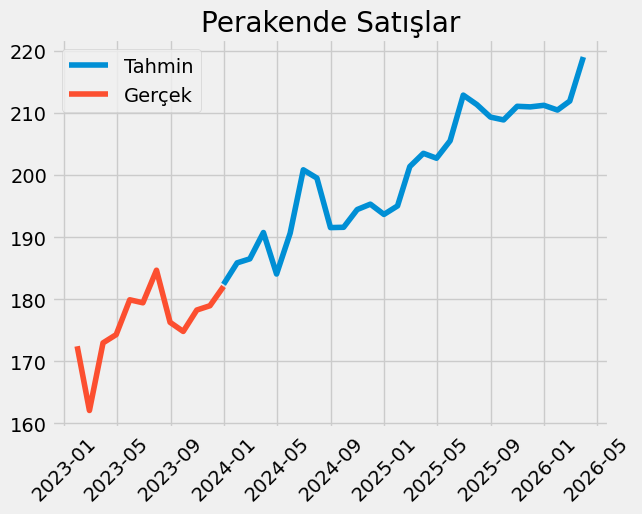

In [109]:
plt.title("Perakende Satışlar")
plt.plot(predictions["yhat"][-28:],label="Tahmin")
plt.plot(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [110]:
perakendetahmin=(predictions["yhat"][-28:].pct_change(periods=1)*100).dropna()
perakendetahmin

ds
2024-01-31    1.899453
2024-02-29    0.347187
2024-03-31    2.275449
2024-04-30   -3.506735
2024-05-31    3.578296
2024-06-30    5.356224
2024-07-31   -0.663651
2024-08-31   -3.999949
2024-09-30    0.025459
2024-10-31    1.493126
2024-11-30    0.446150
2024-12-31   -0.845813
2025-01-31    0.708612
2025-02-28    3.251780
2025-03-31    1.059153
2025-04-30   -0.388384
2025-05-31    1.389245
2025-06-30    3.578033
2025-07-31   -0.716229
2025-08-31   -0.953721
2025-09-30   -0.217622
2025-10-31    1.049791
2025-11-30   -0.043539
2025-12-31    0.119629
2026-01-31   -0.361156
2026-02-28    0.688540
2026-03-31    3.348129
Name: yhat, dtype: float64

In [111]:
((usdtahmin1[3:-2].pct_change(periods=1)*100).dropna())

,USD/TL
2024-02-29,2.348118
2024-03-31,4.163119
2024-04-30,3.029874
2024-05-31,3.038798
2024-06-30,2.854043
2024-07-31,2.867343
2024-08-31,2.787418
2024-09-30,2.624350
2024-10-31,2.642480
2024-11-30,2.491404


In [112]:
brenttahmin1=(brenttahmin.pct_change()*100).dropna()
brenttahmin1

ds
2024-02-29    5.225810
2024-03-31    0.288006
2024-04-30   -2.089670
2024-05-31    2.985774
2024-06-30    2.594097
2024-07-31    0.896056
2024-08-31    0.492668
2024-09-30   -2.012286
2024-10-31   -0.487074
2024-11-30   -3.176410
2024-12-31    1.276149
2025-01-31    3.080170
2025-02-28   -0.578904
2025-03-31    0.662368
2025-04-30    0.014818
2025-05-31    0.992177
2025-06-30    1.592400
2025-07-31    0.978310
2025-08-31   -0.369648
2025-09-30   -0.121467
2025-10-31   -0.005480
2025-11-30   -2.239304
2025-12-31   -1.143101
2026-01-31    1.934657
2026-02-28    0.765067
2026-03-31    1.021965
2026-04-30    1.937620
Name: yhat, dtype: float64

In [113]:
motorintahmin=pd.DataFrame((1+(((usdtahmin1[3:-2].pct_change(periods=1)*100).dropna())/100)).values*(1+(((brenttahmin1[:-1]).dropna())/100)).values.reshape(-1,1))
motorintahmin.columns=["Motorin"]
motorintahmin=motorintahmin.set_index(pd.date_range(start="2024-02-28",periods=len(motorintahmin),freq="1M"))
motorintahmin.iloc[0,0]=(motorin.pct_change(periods=1)*100).iloc[-1,0]
motorintahmin[1:]=((motorintahmin[1:])-1)*100
motorintahmin

,Motorin
2024-02-29,7.807351
2024-03-31,4.463115
2024-04-30,0.876889
2024-05-31,6.115303
2024-06-30,5.522177
2024-07-31,3.789092
2024-08-31,3.293819
2024-09-30,0.559255
2024-10-31,2.142535
2024-11-30,-0.764143


In [114]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=money["Para Arzi"].index
    sn["y"]=money["Para Arzi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(money["Para Arzi"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=money["Para Arzi"].index\n    sn["y"]=money["Para Arzi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_rang

In [115]:
"""study.best_params"""

'study.best_params'

In [116]:
sn=pd.DataFrame()
sn["ds"]=money["Para Arzi"].index
sn["y"]=money["Para Arzi"].values
prophet=Prophet(changepoint_prior_scale=1.916034897796889,changepoint_range=0.9729543315216538,growth='linear',seasonality_prior_scale=4.453031163229546,n_changepoints=89,yearly_seasonality="auto",weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

19:53:49 - cmdstanpy - INFO - Chain [1] start processing


19:53:49 - cmdstanpy - INFO - Chain [1] done processing


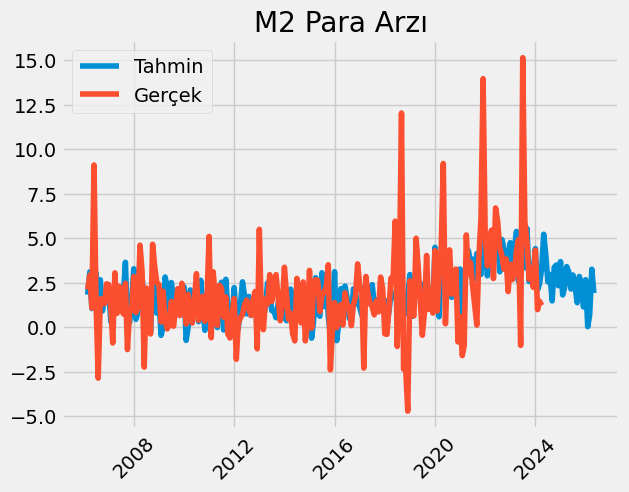

In [117]:
plt.title("M2 Para Arzı")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(money["Para Arzi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [118]:
paraarzitahmin=(predictions["yhat"]).tail(25)
paraarzitahmin

ds
2024-04-30    5.228708
2024-05-31    4.055621
2024-06-30    2.549198
2024-07-31    2.963459
2024-08-31    1.484086
2024-09-30    3.364671
2024-10-31    3.499645
2024-11-30    2.338917
2024-12-31    3.690579
2025-01-31    1.818121
2025-02-28    2.221985
2025-03-31    3.412214
2025-04-30    3.112394
2025-05-31    2.151344
2025-06-30    2.938184
2025-07-31    2.258347
2025-08-31    1.382455
2025-09-30    2.857806
2025-10-31    2.461131
2025-11-30    1.141915
2025-12-31    2.672944
2026-01-31    0.037885
2026-02-28    0.693812
2026-03-31    3.264594
2026-04-30    1.927490
Name: yhat, dtype: float64

In [119]:
paraarzitahmin1 = paraarzitahmin
paraarzitahmin1 = np.array(paraarzitahmin1).reshape(-1, 1)
paraarzitahmin1 = pd.DataFrame(paraarzitahmin1)
paraarzitahmin1.columns = ["Para Arzi"]
paraarzitahmin1 = paraarzitahmin1.set_index(pd.date_range(start="2024-04-30", periods=len(paraarzitahmin), freq="1M"))
row=pd.DataFrame({"Para Arzi":money.iloc[-4:,0]},index=pd.date_range(start="2023-12-30",periods=4,freq="M"))
paraarzitahmin1=pd.concat([row,paraarzitahmin1])
paraarzitahmin1

,Para Arzi
2023-12-31,4.333376
2024-01-31,0.993354
2024-02-29,1.467899
2024-03-31,1.231314
2024-04-30,5.228708
2024-05-31,4.055621
2024-06-30,2.549198
2024-07-31,2.963459
2024-08-31,1.484086
2024-09-30,3.364671


In [120]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=borc["Borç"][params["m"]:-12].index
    sn["y"]=borc["Borç"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(borc["Borç"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=borc["Borç"][params["m"]:-12].index\n    sn["y"]=borc["Borç

In [121]:
#study.best_params

In [122]:
sn=pd.DataFrame()
sn["ds"]=borc["Borç"][103:].index
sn["y"]=borc["Borç"][103:].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=3.671534257218686,changepoint_range=0.8995013103592469,growth='linear',seasonality_prior_scale=4.464356522636207,n_changepoints=2)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=26,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

19:53:50 - cmdstanpy - INFO - Chain [1] start processing


19:53:50 - cmdstanpy - INFO - Chain [1] done processing


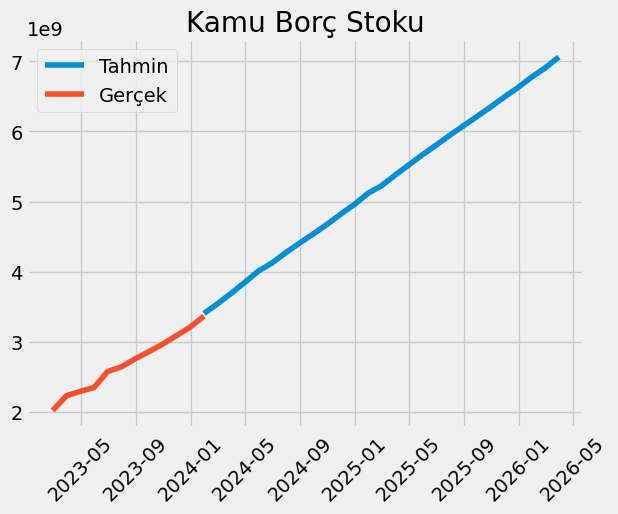

In [123]:
plt.title("Kamu Borç Stoku")
plt.plot(predictions["yhat"][-27:],label="Tahmin")
plt.plot(borc["Borç"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [124]:
borctahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(26)
borctahmin

ds
2024-02-29    3.931115
2024-03-31    4.257236
2024-04-30    4.213795
2024-05-31    4.275757
2024-06-30    2.843438
2024-07-31    3.593886
2024-08-31    3.232160
2024-09-30    2.921967
2024-10-31    3.036143
2024-11-30    3.089515
2024-12-31    2.899262
2025-01-31    3.283513
2025-02-28    1.914112
2025-03-31    2.957358
2025-04-30    2.646211
2025-05-31    2.720277
2025-06-30    2.347082
2025-07-31    2.488168
2025-08-31    2.317654
2025-09-30    2.172175
2025-10-31    2.228737
2025-11-30    2.207552
2025-12-31    2.114284
2026-01-31    2.294370
2026-02-28    1.777334
2026-03-31    2.284275
Name: yhat, dtype: float64

In [125]:
borctahmin1 = []
result = borc.iloc[-1,0]
for i in range(len(borctahmin)):
    result *= (1 + borctahmin[i] / 100)
    borctahmin1.append(result)

borctahmin1 = np.array(borctahmin1).reshape(-1, 1)
borctahmin1 = pd.DataFrame(borctahmin1)
borctahmin1.columns = ["Borç"]
borctahmin1 = borctahmin1.set_index(pd.date_range(start="2024-02-28", periods=len(borctahmin1), freq="1M"))
row=pd.DataFrame({"Borç":borc.iloc[-4:,0]},index=pd.date_range(start="2023-10-30",periods=4,freq="1M"))
borctahmin1=pd.concat([row,borctahmin1],axis=0)
borctahmin1

,Borç
2023-10-31,2.966763e+09
2023-11-30,3.086466e+09
2023-12-31,3.209252e+09
2024-01-31,3.366451e+09
2024-02-29,3.498790e+09
2024-03-31,3.647741e+09
2024-04-30,3.801450e+09
2024-05-31,3.963991e+09
2024-06-30,4.076704e+09
2024-07-31,4.223216e+09


In [126]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,5),
                'n_changepoints':trial.suggest_int('n_changepoints',1,200),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),


                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df3["Kredi"].index
    sn["y"]=df3["Kredi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df3.values,predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,5),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,200),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df3["Kredi"].index\n    sn["y"]=df3["Kredi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=

In [127]:
"""study.best_params"""

'study.best_params'

In [128]:
sn=pd.DataFrame()
sn["ds"]=df3["Kredi"].index
sn["y"]=df3["Kredi"].values
prophet=Prophet(changepoint_prior_scale=30.99759561372614,changepoint_range=0.872589785485153,growth="linear",seasonality_prior_scale=3.534157847860739,n_changepoints=189,yearly_seasonality=True,weekly_seasonality=True)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

19:53:51 - cmdstanpy - INFO - Chain [1] start processing


19:53:52 - cmdstanpy - INFO - Chain [1] done processing


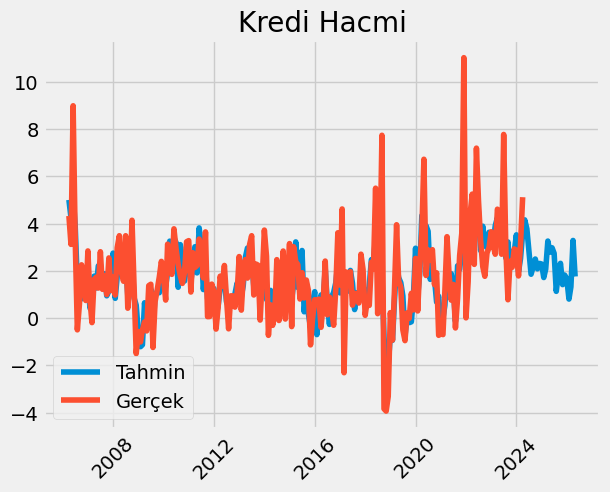

In [129]:
plt.title("Kredi Hacmi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(df3["Kredi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [130]:
kreditahmin=(predictions["yhat"]).tail(25)
kreditahmin

ds
2024-04-30    4.162997
2024-05-31    3.785550
2024-06-30    2.834364
2024-07-31    1.860872
2024-08-31    2.193939
2024-09-30    2.505531
2024-10-31    2.089794
2024-11-30    2.317718
2024-12-31    2.293849
2025-01-31    1.721159
2025-02-28    2.078881
2025-03-31    3.265809
2025-04-30    2.793109
2025-05-31    2.981977
2025-06-30    2.745925
2025-07-31    1.137224
2025-08-31    1.900055
2025-09-30    2.322949
2025-10-31    1.420608
2025-11-30    1.825444
2025-12-31    1.661098
2026-01-31    0.808619
2026-02-28    1.326292
2026-03-31    3.290786
2026-04-30    1.765474
Name: yhat, dtype: float64

In [131]:
kreditahmin1 = kreditahmin

kreditahmin1 = np.array(kreditahmin1).reshape(-1, 1)
kreditahmin1 = pd.DataFrame(kreditahmin1)
kreditahmin1.columns = ["Kredi"]
kreditahmin1 = kreditahmin1.set_index(pd.date_range(start="2024-04-30", periods=len(kreditahmin1), freq="1M"))
row=pd.DataFrame({"Kredi":df3.iloc[-4:,0]},index=pd.date_range(start="2023-12-30",periods=4,freq="1M"))
kreditahmin1=pd.concat([row,kreditahmin1],axis=0)
kreditahmin1

,Kredi
2023-12-31,2.873464
2024-01-31,1.789324
2024-02-29,3.130261
2024-03-31,5.122580
2024-04-30,4.162997
2024-05-31,3.785550
2024-06-30,2.834364
2024-07-31,1.860872
2024-08-31,2.193939
2024-09-30,2.505531


In [132]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,150),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=m3["M3 Para Arzi"].index
    sn["y"]=m3["M3 Para Arzi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(m3["M3 Para Arzi"],predictions["yhat"][:-12])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,150),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=m3["M3 Para Arzi"].index\n    sn["y"]=m3["M3 Para Arzi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_ran

In [133]:
"""study.best_params"""

'study.best_params'

In [134]:
sn=pd.DataFrame()
sn["ds"]=m3["M3"].index
sn["y"]=m3["M3"].values
prophet=Prophet(changepoint_prior_scale=6.802652830514151,changepoint_range=0.9787110716126334,growth='linear',seasonality_prior_scale=5.79604715670266,n_changepoints=98,yearly_seasonality="auto",weekly_seasonality=False)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

19:53:52 - cmdstanpy - INFO - Chain [1] start processing


19:53:53 - cmdstanpy - INFO - Chain [1] done processing


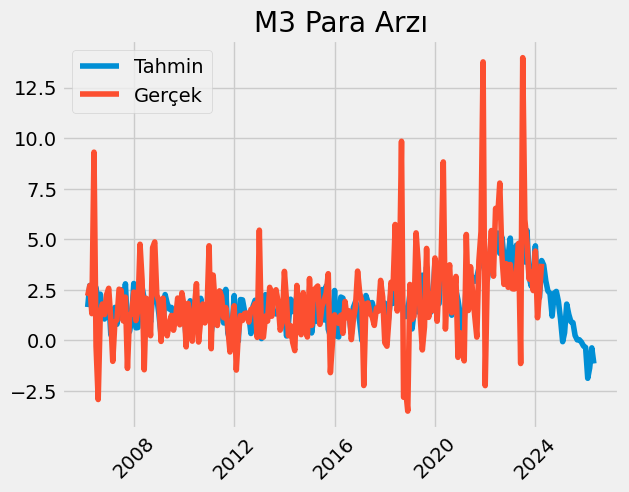

In [135]:
plt.title("M3 Para Arzı")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(m3["M3"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [136]:
(predictions["yhat"].tail(26))

ds
2024-03-31    3.948559
2024-04-30    3.723192
2024-05-31    2.934590
2024-06-30    2.448574
2024-07-31    2.318324
2024-08-31    1.203483
2024-09-30    2.334822
2024-10-31    2.422609
2024-11-30    1.933047
2024-12-31    1.051762
2025-01-31   -0.063620
2025-02-28    0.381166
2025-03-31    1.796559
2025-04-30    1.288792
2025-05-31    0.924676
2025-06-30    0.878440
2025-07-31    0.244516
2025-08-31    0.027154
2025-09-30    0.035043
2025-10-31   -0.084612
2025-11-30   -0.273082
2025-12-31   -0.345994
2026-01-31   -1.873987
2026-02-28   -1.362723
2026-03-31   -0.367753
2026-04-30   -1.142047
Name: yhat, dtype: float64

In [137]:
m3tahmin=(predictions["yhat"].tail(26))


m3tahmin1 = np.array(m3tahmin).reshape(-1, 1)
m3tahmin1 = pd.DataFrame(m3tahmin1)
m3tahmin1.columns = ["M3"]
m3tahmin1 = m3tahmin1.set_index(pd.date_range(start="2024-04-28", periods=len(m3tahmin1), freq="1M"))
row=pd.DataFrame({"M3":m3.iloc[-4:,0]},index=pd.date_range(start="2023-12-30",periods=4,freq="1M"))
m3tahmin1=pd.concat([row,m3tahmin1],axis=0)
m3tahmin1

,M3
2023-12-31,4.417846
2024-01-31,1.120968
2024-02-29,2.360273
2024-03-31,3.789721
2024-04-30,3.948559
2024-05-31,3.723192
2024-06-30,2.934590
2024-07-31,2.448574
2024-08-31,2.318324
2024-09-30,1.203483


In [138]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=sanayi["Sanayi"].index
    sn["y"]=sanayi["Sanayi"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=15,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sanayi["Sanayi"],predictions["yhat"][:-15])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=sanayi["Sanayi"].index\n    sn["y"]=sanayi["Sanayi"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(cha

In [139]:
#study.best_params

In [140]:
sn=pd.DataFrame()
sn["ds"]=sanayi["Sanayi"].index
sn["y"]=sanayi["Sanayi"].values
prophet=Prophet(changepoint_prior_scale=9.619978429571834,changepoint_range=0.8872026398316396,growth='linear',seasonality_prior_scale=4.66384076344283,n_changepoints=25,yearly_seasonality="auto",weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

19:53:53 - cmdstanpy - INFO - Chain [1] start processing
19:53:53 - cmdstanpy - INFO - Chain [1] done processing


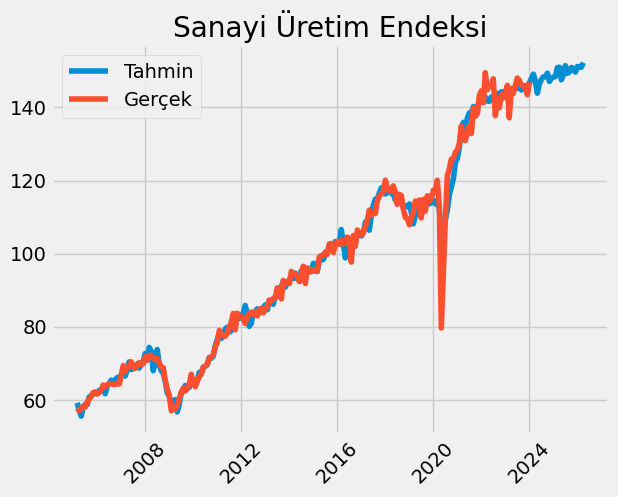

In [141]:
plt.title("Sanayi Üretim Endeksi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(sanayi["Sanayi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [142]:
sanayitahmin=(predictions["yhat"].tail(28).pct_change(periods=1)*100).dropna()
sanayitahmin1 = []
result = sanayi.iloc[-1,0]
for i in range(len(sanayitahmin)):
    result *= (1 + sanayitahmin[i] / 100)
    sanayitahmin1.append(result)

sanayitahmin1 = np.array(sanayitahmin1).reshape(-1, 1)
sanayitahmin1 = pd.DataFrame(sanayitahmin1)
sanayitahmin1.columns = ["Sanayi"]
sanayitahmin1 = sanayitahmin1.set_index(pd.date_range(start="2024-01-31", periods=len(sanayitahmin1), freq="1M"))
#row=pd.DataFrame({"Sanayi":df3.iloc[-2:,0]},index=pd.date_range(start="2023-10-30",periods=2,freq="1M"))
#sanayitahmin1=pd.concat([row,sanayitahmin1],axis=0)
sanayitahmin1

,Sanayi
2024-01-31,148.172656
2024-02-29,149.304582
2024-03-31,147.440413
2024-04-30,144.090834
2024-05-31,146.699778
2024-06-30,147.812608
2024-07-31,148.585767
2024-08-31,148.601460
2024-09-30,149.580131
2024-10-31,147.325270


In [143]:
redkt=redkt.pct_change()*100
redk=redk.pct_change()*100
redkt=redkt.dropna()
redk=redk.dropna()

In [144]:
"""def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_int('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redkt["REDKT"].index
    sn["y"]=redkt["REDKT"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=36,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(redkt["REDKT"],predictions["yhat"][:-36])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_int(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redkt["REDKT"].index\n    sn["y"]=redkt["REDKT"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(changepoint_prior_scal

In [145]:
#study.best_params

In [146]:
sn=pd.DataFrame()
sn["ds"]=redkt["REDKT"].index
sn["y"]=redkt["REDKT"].values
prophet=Prophet(changepoint_prior_scale=9.989231798653107,
 changepoint_range=0.960887868185737,
 growth='linear',seasonality_prior_scale=2.612910619508741,n_changepoints=50,yearly_seasonality="auto",weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

19:53:54 - cmdstanpy - INFO - Chain [1] start processing


19:53:54 - cmdstanpy - INFO - Chain [1] done processing


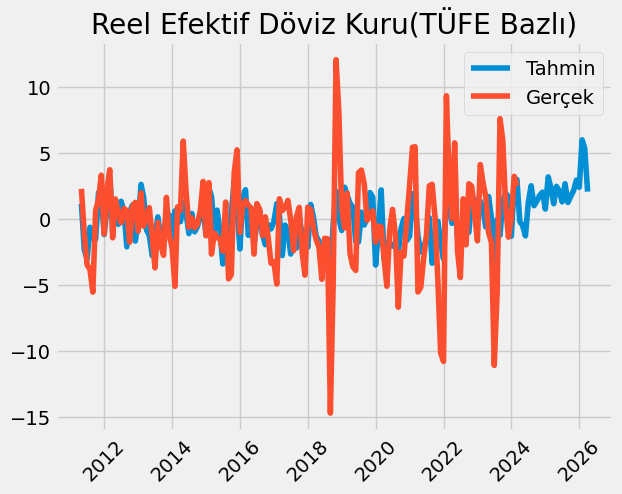

In [147]:
plt.title("Reel Efektif Döviz Kuru(TÜFE Bazlı)")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(redkt["REDKT"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [148]:
predictions["yhat"].tail(25)

ds
2024-03-31   -0.183185
2024-04-30   -0.490423
2024-05-31   -1.274889
2024-06-30    1.216762
2024-07-31    2.514928
2024-08-31    1.007623
2024-09-30    1.344627
2024-10-31    1.787637
2024-11-30    2.030190
2024-12-31    0.752782
2025-01-31    3.187195
2025-02-28    2.388477
2025-03-31    1.157281
2025-04-30    2.470775
2025-05-31    2.108754
2025-06-30    1.299714
2025-07-31    2.667394
2025-08-31    1.255629
2025-09-30    1.709729
2025-10-31    2.147297
2025-11-30    2.939350
2025-12-31    2.401928
2026-01-31    5.989681
2026-02-28    5.337517
2026-03-31    2.073117
Name: yhat, dtype: float64

In [149]:
redkttahmin=pd.DataFrame(predictions["yhat"].tail(25),index=predictions.index[-25:])
redkttahmin.columns=["REDKT"]
redkttahmin.index.name=""
redkttahmin

,REDKT
,
2024-03-31,-0.183185
2024-04-30,-0.490423
2024-05-31,-1.274889
2024-06-30,1.216762
2024-07-31,2.514928
2024-08-31,1.007623
2024-09-30,1.344627
2024-10-31,1.787637
2024-11-30,2.030190


In [150]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_int('cap',0,400)
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redk["REDK"].index
    sn["y"]=redk["REDK"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=26,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].iloc[:-26])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_int(\'cap\',0,400)\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redk["REDK"].index\n    sn["y"]=redk["REDK"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(changepoint_

In [151]:
#study.best_params

In [152]:
sn=pd.DataFrame()
sn["ds"]=redk["REDK"].index
sn["y"]=redk["REDK"].values
prophet=Prophet(changepoint_prior_scale=9.940418274244966,changepoint_range=0.9610240851805488,growth='linear',seasonality_prior_scale=7.183346343813709,n_changepoints=100,yearly_seasonality=True,weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=26,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

19:53:55 - cmdstanpy - INFO - Chain [1] start processing


19:53:55 - cmdstanpy - INFO - Chain [1] done processing


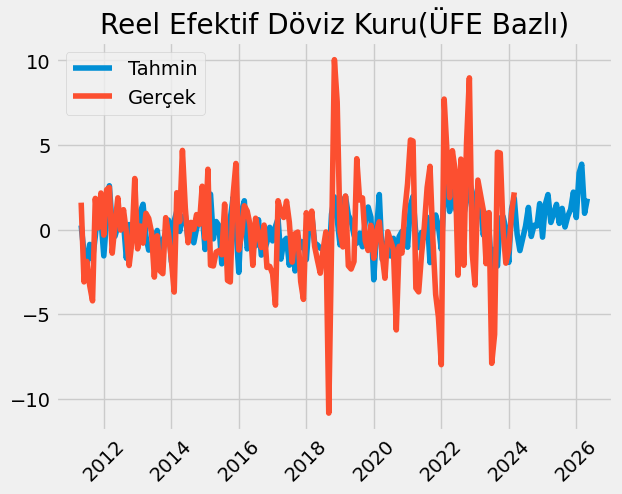

In [153]:
plt.title("Reel Efektif Döviz Kuru(ÜFE Bazlı)")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(redk["REDK"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [154]:
predictions["yhat"].tail(26)

ds
2024-03-31   -0.276376
2024-04-30   -1.240460
2024-05-31   -0.495024
2024-06-30    0.208132
2024-07-31    1.311894
2024-08-31   -0.404283
2024-09-30    0.253999
2024-10-31    0.211515
2024-11-30    1.538053
2024-12-31   -0.444100
2025-01-31    1.515899
2025-02-28    2.070819
2025-03-31    0.423395
2025-04-30    0.938707
2025-05-31    1.493092
2025-06-30    0.367570
2025-07-31    1.254711
2025-08-31    0.154223
2025-09-30    0.788108
2025-10-31    1.191802
2025-11-30    2.216634
2025-12-31    0.715234
2026-01-31    3.345095
2026-02-28    3.867063
2026-03-31    0.963738
2026-04-30    1.832414
Name: yhat, dtype: float64

In [155]:
redktahmin=predictions["yhat"].tail(26).values
redktahmin = np.array(redktahmin).reshape(-1, 1)
redktahmin = pd.DataFrame(redktahmin)
redktahmin.columns = ["REDK"]
redktahmin = redktahmin.set_index(pd.date_range(start="2024-03-28", periods=len(redktahmin), freq="1M"))
redktahmin

,REDK
2024-03-31,-0.276376
2024-04-30,-1.240460
2024-05-31,-0.495024
2024-06-30,0.208132
2024-07-31,1.311894
2024-08-31,-0.404283
2024-09-30,0.253999
2024-10-31,0.211515
2024-11-30,1.538053
2024-12-31,-0.444100


In [156]:
"""def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 2),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.001,1.0),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoinst',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=historical_volatility.index
    sn["y"]=historical_volatility.values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 2),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.001,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoinst\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=historical_volatility.index\n    sn["y"]=historical_volatility.values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predict

In [157]:
"""study.best_params"""

'study.best_params'

In [690]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin1["USD/TL"].rolling(3).mean(),sanayitahmin1["Sanayi"],borctahmin1.shift(1)],axis=1)

tahmindf=tahmindf.pct_change(periods=1)*100
tahmindf["M3"]=m3tahmin1.shift(1)
tahmindf["Para Arzi"]=paraarzitahmin1.shift(1)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin1["Enflasyon Belirsizliği"]
tahmindf["Kredi"]=kreditahmin1["Kredi"].rolling(3).mean()
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Motorin"]=motorintahmin["Motorin"]
tahmindf["Kredi Faizi"]=kfaiztahmin["Kredi Faizi"]
tahmindf["Mevduat Faizi"]=mfaiztahmin["Mevduat Faizi"]
tahmindf["İşsizlik"]=issizliktahmin
tahmindf["REDKT"]=redkttahmin["REDKT"]
tahmindf["REDK"]=redktahmin["REDK"]
#tahmindf["Politika Faizi"]=faiztahmin["Faiz"]
tahmindf["Perakende Satış"]=perakendetahmin




tahmindf["Politika Faizi"]=[42.5,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,42.5,40,37.5,35,35,35,35,35,35,32.5,30,40,40,40]
tahmindf=tahmindf[['USD/TL', 'Motorin', 'Kredi Faizi', 'Zam',
       'Enflasyon Belirsizliği', 'Para Arzi', 'M3','Borç', 'Kredi', 'Mevduat Faizi','REDKT','REDK','İşsizlik','Politika Faizi',"Sanayi","Perakende Satış"]]

tahmindf.columns=["USD/TL","Motorin","Kredi Faizi","Zam","Enflasyon Belirsizliği",'ParaArzi','M3', 'Borç', 'Kredi', 'Mevduat Faizi','REDKT','REDK','İşsizlik','Politika Faizi',"Sanayi","Perakende Satış"]
tahmindf=tahmindf.dropna(axis=0)












tahmindf["Beklenti"]=3.80
tahmindf["Beklenti"].iloc[1:]=0
tahmindf=tahmindf.iloc[:14]
tahmindf.iloc[0,1]=-1.48
tahmindf

,USD/TL,Motorin,Kredi Faizi,Zam,Enflasyon Belirsizliği,ParaArzi,M3,Borç,Kredi,Mevduat Faizi,REDKT,REDK,İşsizlik,Politika Faizi,Sanayi,Perakende Satış,Beklenti
2024-03-31,3.298706,-1.480000,61.660000,0.0,3.980000,1.467899,2.360273,3.931115,3.347388,53.630000,-0.183185,-0.276376,9.172428,45.0,-1.248568,2.275449,3.8
2024-04-30,3.184620,0.876889,62.808862,0.0,3.321453,1.231314,3.789721,4.257236,4.138613,50.995243,-0.490423,-1.240460,9.223137,45.0,-2.271819,-3.506735,0.0
2024-05-31,3.396772,6.115303,63.863664,0.0,3.134249,5.228708,3.948559,4.213795,4.357042,51.355106,-1.274889,-0.495024,9.247148,45.0,1.810625,3.578296,0.0
2024-06-30,2.972476,5.522177,64.250988,0.0,3.160474,4.055621,3.723192,4.275757,3.594304,52.254716,1.216762,0.208132,9.241430,45.0,0.758577,5.356224,0.0
2024-07-31,2.918392,3.789092,63.933625,0.0,3.107067,2.549198,2.934590,2.843438,2.826928,50.823970,2.514928,1.311894,9.253224,45.0,0.523067,-0.663651,0.0
2024-08-31,2.835637,3.293819,63.284855,0.0,3.052094,2.963459,2.448574,3.593886,2.296392,51.452556,1.007623,-0.404283,9.259024,45.0,0.010562,-3.999949,0.0
2024-09-30,2.757446,0.559255,62.763977,0.0,2.786711,1.484086,2.318324,3.232160,2.186781,51.864411,1.344627,0.253999,9.257643,45.0,0.658587,0.025459,0.0
2024-10-31,2.683451,2.142535,62.631849,0.0,2.374110,3.364671,1.203483,2.921967,2.263088,51.093757,1.787637,0.211515,9.260492,45.0,-1.507460,1.493126,0.0
2024-11-30,2.584918,-0.764143,62.857054,0.0,2.099454,3.499645,2.334822,3.036143,2.304348,51.480647,2.030190,1.538053,9.261893,45.0,0.610730,0.446150,0.0
2024-12-31,2.547474,3.820074,63.213797,0.0,2.380430,2.338917,2.422609,3.089515,2.233787,51.661081,0.752782,-0.444100,9.261559,45.0,0.192091,-0.845813,0.0


In [696]:
(df.pct_change()*100).shift(1).dropna()["CPI"]

2006-04-30    0.274548
2006-05-31    1.336769
2006-06-30    1.875397
2006-07-31    0.335413
2006-08-31    0.847392
                ...   
2023-10-31    4.753114
2023-11-30    3.433981
2023-12-31    3.281097
2024-01-31    2.927207
2024-02-29    6.703310
Freq: M, Name: CPI, Length: 215, dtype: float64

In [697]:
data["TÜFE Lag"]=(df.pct_change()*100).shift(1).dropna()["CPI"]
tahmindf["TÜFE Lag"]=0
tahmindf["TÜFE Lag"].iloc[0]=data["TÜFE"].iloc[-1]

In [699]:
tahmindf=tahmindf.drop(["Sanayi","Perakende Satış","Kredi Faizi"],axis=1)

In [700]:
data=data.dropna()

In [701]:
data1=pd.concat([data,tahmindf],axis=0)
data1

,USD/TL,Motorin,Zam,M3,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,İşsizlik,Politika Faizi,TÜFE,TÜFE Lag,Beklenti
2014-01-31,3.732429,2.881984,10.828025,3.413428,0.820000,3.375162,-0.584687,2.669930,8.850000,-3.691204,-5.094658,9.200000,9.96,1.978080,0.460607,NaN
2014-02-28,3.033477,1.685899,0.000000,1.958423,0.730000,1.804994,0.808574,1.876850,10.750000,2.179150,0.919060,9.500000,10.23,0.428192,1.978080,NaN
2014-03-31,2.465778,-2.278097,0.000000,0.229599,0.800000,0.451349,0.193691,0.822203,11.650000,0.471546,0.641623,9.500000,10.27,1.125608,0.428192,NaN
2014-04-30,-1.344724,-6.214384,0.000000,0.730196,0.730000,0.796760,0.478162,-0.154556,10.750000,4.682667,5.892031,9.700000,10.03,1.344970,1.125608,NaN
2014-05-31,-1.859714,-0.561578,0.000000,-0.093468,0.800000,-0.362357,0.091080,0.146305,10.430000,1.283880,2.058652,9.700000,9.53,0.395224,1.344970,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31,2.547474,3.820074,0.000000,2.422609,2.380430,2.338917,3.089515,2.233787,51.661081,-0.444100,0.752782,9.261559,45.00,NaN,0.000000,0.0
2025-01-31,2.484190,5.605965,30.000000,1.933047,2.528406,3.690579,2.899262,2.110909,51.249369,1.515899,3.187195,9.262247,45.00,NaN,0.000000,0.0
2025-02-28,2.371278,1.568850,0.000000,1.051762,1.944481,1.818121,3.283513,2.031296,51.482367,2.070819,2.388477,9.266150,45.00,NaN,0.000000,0.0
2025-03-31,2.316351,3.019016,0.000000,-0.063620,1.995029,2.221985,1.914112,2.355283,50.357362,0.423395,1.157281,9.269633,45.00,NaN,0.000000,0.0


In [702]:
features=['USD/TL', 'Motorin','Enflasyon Belirsizliği','M3', 'Kredi','REDK','Politika Faizi','İşsizlik','TÜFE Lag','TÜFE']
data1=data1[features]

In [703]:
data1.loc["2023-05-31","TÜFE"]+=2.88
"""data1.loc["2023-10-31","TÜFE"]-=0.22
data1.loc["2023-11-30","TÜFE"]-=1.01
data1.loc["2023-12-31","TÜFE"]-=0.33"""

'data1.loc["2023-10-31","TÜFE"]-=0.22\ndata1.loc["2023-11-30","TÜFE"]-=1.01\ndata1.loc["2023-12-31","TÜFE"]-=0.33'

In [704]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler = StandardScaler()
scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data=scaled_data.iloc[1:,:]
scaled_data

,USD/TL,Motorin,Enflasyon Belirsizliği,M3,Kredi,REDK,Politika Faizi,İşsizlik,TÜFE Lag,TÜFE
1,0.217365,-0.065655,-0.664618,-0.131674,0.023470,0.700815,-0.608536,-0.966753,0.142752,-0.634592
2,0.040661,-0.622578,-0.638142,-0.816411,-0.683200,0.140944,-0.605135,-0.966753,-0.553444,-0.327770
3,-1.145411,-1.175609,-0.664618,-0.618139,-1.337680,1.521642,-0.625539,-0.832871,-0.240171,-0.231263
4,-1.305709,-0.381415,-0.638142,-0.944369,-1.136087,0.407284,-0.668049,-0.832871,-0.141636,-0.649096
5,-1.220454,0.083802,-0.668400,-1.107384,-0.708847,-0.267645,-0.728412,-0.832871,-0.568253,-0.686242
...,...,...,...,...,...,...,...,...,...,...
131,0.066090,0.234187,-0.040396,0.052177,0.262637,-0.159268,2.347573,-1.126367,-0.745784,NaN
132,0.046392,0.485097,0.015571,-0.141724,0.180302,0.483356,2.347573,-1.125907,-0.745784,NaN
133,0.011246,-0.082100,-0.205279,-0.490776,0.126957,0.665297,2.347573,-1.123294,-0.745784,NaN
134,-0.005850,0.121642,-0.186161,-0.932547,0.344046,0.125157,2.347573,-1.120962,-0.745784,NaN


In [705]:
from sklearn.model_selection import train_test_split
X=scaled_data
X=X.iloc[:-14,:-1]
y=scaled_data["TÜFE"][:-14]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X_train,X_test=X[:-12,:],X[-12:,:]
y_train,y_test=y[:-12],y[-12:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.05,random_state=42)


In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,SimpleRNN
import keras
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2
def objective(trial):
    # Define hyperparameters to be optimized
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2)
    units1 = trial.suggest_int('units1', 1, 128)
    batch_size = trial.suggest_int('batch_size', 2, 40)
    activation1 = trial.suggest_categorical('activation1', ['tanh','selu'])
    optimizer = trial.suggest_categorical('optimizer', ['rmsprop'])
    rlrate=trial.suggest_float('rlrate',0.01,0.5)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rlrate)))
    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rlrate)))
    model.add(Dense(units=1))

    if optimizer == 'adam':
       optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
       optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    

    

    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])

    # Train model
    model.fit(X_train, y_train, epochs=1000, batch_size=batch_size,callbacks=[early_stopping],verbose=0,validation_data=(X_val,y_val))

    # Evaluate model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred))

    return mse  # Return validation accuracy as the objective


In [ ]:
study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective
study.optimize(objective, n_trials=2000)  # You can adjust the number of trials

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)

[I 2024-03-15 23:22:20,654] A new study created in memory with name: no-name-3e6abe14-8960-404a-96bc-95f426c36c1a


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:22:24,084] Trial 0 finished with value: 3.1766602091785123 and parameters: {'learning_rate': 0.0019240537052991377, 'units1': 12, 'batch_size': 19, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.4341472857983705}. Best is trial 0 with value: 3.1766602091785123.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:22:27,099] Trial 1 finished with value: 2.25709632671255 and parameters: {'learning_rate': 0.0008869778339387679, 'units1': 100, 'batch_size': 33, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.22731616915389863}. Best is trial 1 with value: 2.25709632671255.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:22:29,180] Trial 2 finished with value: 1.7299770952706501 and parameters: {'learning_rate': 0.0018744077780948765, 'units1': 113, 'batch_size': 9, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.11855001456182276}. Best is trial 2 with value: 1.7299770952706501.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:22:31,465] Trial 3 finished with value: 2.363829694694169 and parameters: {'learning_rate': 0.0023087616746406735, 'units1': 97, 'batch_size': 40, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.09783455062244316}. Best is trial 2 with value: 1.7299770952706501.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:22:33,175] Trial 4 finished with value: 1.878765085333841 and parameters: {'learning_rate': 0.008632761223371706, 'units1': 49, 'batch_size': 28, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3923581955119026}. Best is trial 2 with value: 1.7299770952706501.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:22:34,798] Trial 5 finished with value: 5.618044820669744 and parameters: {'learning_rate': 0.00714802766316725, 'units1': 80, 'batch_size': 13, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.4253667077210279}. Best is trial 2 with value: 1.7299770952706501.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:22:37,688] Trial 6 finished with value: 2.3638702125545876 and parameters: {'learning_rate': 0.0008438615104697566, 'units1': 81, 'batch_size': 15, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.3557370638145541}. Best is trial 2 with value: 1.7299770952706501.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:22:39,822] Trial 7 finished with value: 3.990931950165185 and parameters: {'learning_rate': 0.003877198196608114, 'units1': 126, 'batch_size': 36, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.13691437852312097}. Best is trial 2 with value: 1.7299770952706501.


1/1 [==============================] - 0s 102ms/step


[I 2024-03-15 23:22:41,837] Trial 8 finished with value: 4.752990564149126 and parameters: {'learning_rate': 0.008361640067303139, 'units1': 4, 'batch_size': 23, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.4066285069936713}. Best is trial 2 with value: 1.7299770952706501.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:22:45,248] Trial 9 finished with value: 2.4786519826771576 and parameters: {'learning_rate': 0.004087318636263695, 'units1': 54, 'batch_size': 22, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.1596310280879751}. Best is trial 2 with value: 1.7299770952706501.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:22:47,148] Trial 10 finished with value: 3.1294111739091313 and parameters: {'learning_rate': 0.005517601747145388, 'units1': 128, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.03017430141297206}. Best is trial 2 with value: 1.7299770952706501.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:22:48,613] Trial 11 finished with value: 1.3532861870072157 and parameters: {'learning_rate': 0.009914673596627276, 'units1': 38, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27728732115827825}. Best is trial 11 with value: 1.3532861870072157.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:22:50,049] Trial 12 finished with value: 1.2499951838056593 and parameters: {'learning_rate': 0.009899288805047134, 'units1': 31, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2919172102903587}. Best is trial 12 with value: 1.2499951838056593.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:22:51,741] Trial 13 finished with value: 1.2504693580313844 and parameters: {'learning_rate': 0.009403830379047838, 'units1': 31, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.302821962087617}. Best is trial 12 with value: 1.2499951838056593.


1/1 [==============================] - 0s 86ms/step


[I 2024-03-15 23:22:53,939] Trial 14 finished with value: 2.0902486771669624 and parameters: {'learning_rate': 0.009868103396911724, 'units1': 31, 'batch_size': 8, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.30791266758102803}. Best is trial 12 with value: 1.2499951838056593.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:22:56,030] Trial 15 finished with value: 4.199270061016175 and parameters: {'learning_rate': 0.006799034267522984, 'units1': 23, 'batch_size': 7, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22092366839718228}. Best is trial 12 with value: 1.2499951838056593.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:22:57,533] Trial 16 finished with value: 1.212271275530634 and parameters: {'learning_rate': 0.008401779728151638, 'units1': 59, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3172277495530288}. Best is trial 16 with value: 1.212271275530634.


1/1 [==============================] - 0s 83ms/step


[I 2024-03-15 23:22:59,566] Trial 17 finished with value: 7.1085642842868095 and parameters: {'learning_rate': 0.007513943841677383, 'units1': 65, 'batch_size': 16, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3488519934916803}. Best is trial 16 with value: 1.212271275530634.


1/1 [==============================] - 0s 89ms/step


[I 2024-03-15 23:23:01,291] Trial 18 finished with value: 4.278431143437007 and parameters: {'learning_rate': 0.005922722358228529, 'units1': 67, 'batch_size': 11, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.4967762616673081}. Best is trial 16 with value: 1.212271275530634.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:23:02,963] Trial 19 finished with value: 1.5900623639773332 and parameters: {'learning_rate': 0.008480032867108394, 'units1': 48, 'batch_size': 6, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.19588125880236684}. Best is trial 16 with value: 1.212271275530634.


1/1 [==============================] - 0s 86ms/step


[I 2024-03-15 23:23:04,602] Trial 20 finished with value: 0.8699628837288814 and parameters: {'learning_rate': 0.007800783352810195, 'units1': 76, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27330377517116505}. Best is trial 20 with value: 0.8699628837288814.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:23:06,836] Trial 21 finished with value: 1.6918136971647033 and parameters: {'learning_rate': 0.007952375853872224, 'units1': 84, 'batch_size': 6, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2576701463122039}. Best is trial 20 with value: 0.8699628837288814.


1/1 [==============================] - 0s 93ms/step


[I 2024-03-15 23:23:08,821] Trial 22 finished with value: 0.7330871178965427 and parameters: {'learning_rate': 0.006455494734685209, 'units1': 59, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.33056554449536224}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 90ms/step


[I 2024-03-15 23:23:10,726] Trial 23 finished with value: 4.060796146335105 and parameters: {'learning_rate': 0.006748749964860625, 'units1': 72, 'batch_size': 10, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3413194610827612}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 82ms/step


[I 2024-03-15 23:23:12,518] Trial 24 finished with value: 0.8750420451447917 and parameters: {'learning_rate': 0.00617077722730517, 'units1': 60, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3348936724082105}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:23:14,254] Trial 25 finished with value: 2.737913652271421 and parameters: {'learning_rate': 0.005996195220172798, 'units1': 92, 'batch_size': 12, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.37342083829406003}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:23:15,840] Trial 26 finished with value: 2.984070506170367 and parameters: {'learning_rate': 0.004374842751529078, 'units1': 73, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24457960024030875}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 80ms/step


[I 2024-03-15 23:23:17,584] Trial 27 finished with value: 4.845033864982049 and parameters: {'learning_rate': 0.005351960376855943, 'units1': 61, 'batch_size': 18, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.4477312716088153}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:23:19,488] Trial 28 finished with value: 2.9076290848473647 and parameters: {'learning_rate': 0.00481784332284498, 'units1': 42, 'batch_size': 25, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.20390330860894948}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:23:21,188] Trial 29 finished with value: 7.739726290532983 and parameters: {'learning_rate': 0.006328763663958911, 'units1': 109, 'batch_size': 19, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.44839841432277566}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 82ms/step


[I 2024-03-15 23:23:24,948] Trial 30 finished with value: 2.098320093551497 and parameters: {'learning_rate': 0.003274041994550861, 'units1': 17, 'batch_size': 14, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.32835495348449645}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:23:26,734] Trial 31 finished with value: 0.786389944044688 and parameters: {'learning_rate': 0.007581415831171561, 'units1': 59, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2716836587843587}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:23:28,498] Trial 32 finished with value: 2.3264390396057135 and parameters: {'learning_rate': 0.0074159395843490655, 'units1': 55, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2736899222661391}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:23:30,146] Trial 33 finished with value: 3.648254103748224 and parameters: {'learning_rate': 0.0063383290136008585, 'units1': 72, 'batch_size': 10, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2408012034284706}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 130ms/step


[I 2024-03-15 23:23:31,832] Trial 34 finished with value: 2.703251109851267 and parameters: {'learning_rate': 0.009065046661782681, 'units1': 46, 'batch_size': 8, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.17630329957618765}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:23:33,319] Trial 35 finished with value: 2.1073996002180873 and parameters: {'learning_rate': 0.007594562705073652, 'units1': 84, 'batch_size': 6, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3622042326101389}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:23:35,282] Trial 36 finished with value: 4.691595578303225 and parameters: {'learning_rate': 0.006773252984940563, 'units1': 94, 'batch_size': 31, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26930185607589296}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:23:36,891] Trial 37 finished with value: 4.411169570921289 and parameters: {'learning_rate': 0.007827367041949508, 'units1': 54, 'batch_size': 9, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.40277014071591855}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:23:38,581] Trial 38 finished with value: 0.8846101472641174 and parameters: {'learning_rate': 0.0048746921615737075, 'units1': 104, 'batch_size': 4, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.38503545531926336}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:23:40,735] Trial 39 finished with value: 2.4634878556252024 and parameters: {'learning_rate': 0.0028565968399199247, 'units1': 77, 'batch_size': 17, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3338388492033241}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:23:42,393] Trial 40 finished with value: 1.3820385734331202 and parameters: {'learning_rate': 0.0090070393847718, 'units1': 68, 'batch_size': 13, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.07182821913021925}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:23:44,000] Trial 41 finished with value: 0.86271309913728 and parameters: {'learning_rate': 0.005059788387810624, 'units1': 105, 'batch_size': 4, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.38052752355017866}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 88ms/step


[I 2024-03-15 23:23:45,985] Trial 42 finished with value: 5.995589116990417 and parameters: {'learning_rate': 0.001488004443123205, 'units1': 121, 'batch_size': 5, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.41901288026207295}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:23:55,992] Trial 43 finished with value: 2.4513506771525018 and parameters: {'learning_rate': 0.00011497651413476008, 'units1': 90, 'batch_size': 7, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.2998142677621364}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:23:57,419] Trial 44 finished with value: 1.618553387379469 and parameters: {'learning_rate': 0.005316248991448928, 'units1': 118, 'batch_size': 4, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.3715860729133249}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:23:59,257] Trial 45 finished with value: 2.6348104972259727 and parameters: {'learning_rate': 0.0058418843310442505, 'units1': 102, 'batch_size': 38, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.29141220585498895}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:24:01,069] Trial 46 finished with value: 4.429321127936881 and parameters: {'learning_rate': 0.007059138781273405, 'units1': 59, 'batch_size': 9, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.22499386874306193}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:24:02,853] Trial 47 finished with value: 2.280000559768989 and parameters: {'learning_rate': 0.006506182489368333, 'units1': 39, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.33239702901346646}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:24:04,432] Trial 48 finished with value: 3.8247714344638157 and parameters: {'learning_rate': 0.008002766183925002, 'units1': 51, 'batch_size': 7, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.471745693302241}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:24:06,157] Trial 49 finished with value: 0.8231645800632973 and parameters: {'learning_rate': 0.003913513564002792, 'units1': 78, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.39208075060173253}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:24:07,953] Trial 50 finished with value: 0.9325032664331318 and parameters: {'learning_rate': 0.0035662853404294695, 'units1': 86, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3942672766082655}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:24:09,801] Trial 51 finished with value: 3.1319143176029236 and parameters: {'learning_rate': 0.0044371982791078625, 'units1': 64, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.35292966255171365}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:24:12,477] Trial 52 finished with value: 0.823914214322297 and parameters: {'learning_rate': 0.005609539827118947, 'units1': 80, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.31179694994138707}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:24:14,315] Trial 53 finished with value: 4.881896961453412 and parameters: {'learning_rate': 0.004005882728709829, 'units1': 76, 'batch_size': 8, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.31210438660068096}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:24:15,945] Trial 54 finished with value: 0.872881390792745 and parameters: {'learning_rate': 0.005607532328791842, 'units1': 80, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.28577787522182724}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 82ms/step


[I 2024-03-15 23:24:18,082] Trial 55 finished with value: 3.309704843037417 and parameters: {'learning_rate': 0.002442419454165624, 'units1': 95, 'batch_size': 11, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.4231014473490726}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:24:19,647] Trial 56 finished with value: 1.8694585500781855 and parameters: {'learning_rate': 0.007156143492440787, 'units1': 88, 'batch_size': 6, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3850236746632136}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:24:21,423] Trial 57 finished with value: 0.7967530104705669 and parameters: {'learning_rate': 0.005049654837820222, 'units1': 108, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25536828523795896}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:24:23,174] Trial 58 finished with value: 0.8831587338878139 and parameters: {'learning_rate': 0.00452470945410276, 'units1': 109, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26000602697147646}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:24:24,918] Trial 59 finished with value: 1.2735997396064436 and parameters: {'learning_rate': 0.005117502018644342, 'units1': 99, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23892080462790583}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:24:26,720] Trial 60 finished with value: 2.0573244531470682 and parameters: {'learning_rate': 0.0035962868500334488, 'units1': 118, 'batch_size': 21, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.20013530271875152}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 82ms/step


[I 2024-03-15 23:24:28,384] Trial 61 finished with value: 1.0722579842132711 and parameters: {'learning_rate': 0.005720316830525915, 'units1': 107, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3187515237664497}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 128ms/step


[I 2024-03-15 23:24:30,079] Trial 62 finished with value: 2.298931482969074 and parameters: {'learning_rate': 0.004883282524886564, 'units1': 70, 'batch_size': 7, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2584354118617994}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:24:31,942] Trial 63 finished with value: 1.8729874220591265 and parameters: {'learning_rate': 0.005162717102234882, 'units1': 113, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.280460564014821}. Best is trial 22 with value: 0.7330871178965427.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:24:33,776] Trial 64 finished with value: 0.7303999829180944 and parameters: {'learning_rate': 0.004262343809913055, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3020155563273767}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 84ms/step


[I 2024-03-15 23:24:35,790] Trial 65 finished with value: 0.7606548856401508 and parameters: {'learning_rate': 0.004102402534058164, 'units1': 81, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3592259454777149}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:24:37,715] Trial 66 finished with value: 0.7817810883040773 and parameters: {'learning_rate': 0.0042371670507638706, 'units1': 78, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.36174265252103066}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 88ms/step


[I 2024-03-15 23:24:39,983] Trial 67 finished with value: 3.8261545818046976 and parameters: {'learning_rate': 0.003215966094705744, 'units1': 66, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.40308628781530254}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:24:42,205] Trial 68 finished with value: 3.5602662410100816 and parameters: {'learning_rate': 0.004172633271528566, 'units1': 63, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3603276837071267}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:24:44,071] Trial 69 finished with value: 3.604786738795267 and parameters: {'learning_rate': 0.0037900292821888898, 'units1': 74, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.347772779739237}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:24:46,255] Trial 70 finished with value: 3.492786818360589 and parameters: {'learning_rate': 0.004557648338451215, 'units1': 58, 'batch_size': 30, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.29800823517718955}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:24:48,360] Trial 71 finished with value: 5.3187241802084495 and parameters: {'learning_rate': 0.0040341818732560295, 'units1': 81, 'batch_size': 6, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.31228688378155034}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 88ms/step


[I 2024-03-15 23:24:50,308] Trial 72 finished with value: 3.1534799213726354 and parameters: {'learning_rate': 0.004272198256029582, 'units1': 83, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.32533636486726114}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 85ms/step


[I 2024-03-15 23:24:52,329] Trial 73 finished with value: 3.554503522056279 and parameters: {'learning_rate': 0.0031175245887879745, 'units1': 77, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3657920699811236}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 86ms/step


[I 2024-03-15 23:24:55,473] Trial 74 finished with value: 0.767951176708022 and parameters: {'learning_rate': 0.004672928505485962, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.34489253349413274}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 93ms/step


[I 2024-03-15 23:24:57,553] Trial 75 finished with value: 0.8850443126713213 and parameters: {'learning_rate': 0.004681700590445114, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3451464074240213}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 82ms/step


[I 2024-03-15 23:24:59,992] Trial 76 finished with value: 3.5312341651379593 and parameters: {'learning_rate': 0.002754041740335553, 'units1': 56, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21342010570270215}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:25:02,069] Trial 77 finished with value: 2.575773367894382 and parameters: {'learning_rate': 0.0036425718403136718, 'units1': 62, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.4473418186611673}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 86ms/step


[I 2024-03-15 23:25:04,098] Trial 78 finished with value: 3.3277012053051824 and parameters: {'learning_rate': 0.0034631849666867005, 'units1': 44, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.4133984145910051}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 84ms/step


[I 2024-03-15 23:25:06,241] Trial 79 finished with value: 5.254766025377307 and parameters: {'learning_rate': 0.0038078265904578166, 'units1': 53, 'batch_size': 6, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.436885711097017}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 90ms/step


[I 2024-03-15 23:25:09,079] Trial 80 finished with value: 2.7992358248881217 and parameters: {'learning_rate': 0.0021285381394204055, 'units1': 72, 'batch_size': 26, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3579814880094523}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 81ms/step


[I 2024-03-15 23:25:10,888] Trial 81 finished with value: 0.785730045950206 and parameters: {'learning_rate': 0.005544111650580193, 'units1': 79, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.338606405374234}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:25:12,868] Trial 82 finished with value: 2.5286117436898414 and parameters: {'learning_rate': 0.0052574540827223255, 'units1': 90, 'batch_size': 8, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.39331682877521446}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:25:14,848] Trial 83 finished with value: 2.2359742376615306 and parameters: {'learning_rate': 0.004750919329414115, 'units1': 67, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.33948374331425635}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:25:16,688] Trial 84 finished with value: 1.4094716035468784 and parameters: {'learning_rate': 0.004382341344730453, 'units1': 86, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3743685598836642}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:25:19,629] Trial 85 finished with value: 2.293452394010368 and parameters: {'learning_rate': 0.006036726449063093, 'units1': 5, 'batch_size': 35, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2988341540744648}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:25:21,410] Trial 86 finished with value: 2.7535285608061866 and parameters: {'learning_rate': 0.005412615545500127, 'units1': 76, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2654820005722468}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:25:23,082] Trial 87 finished with value: 2.2805507193789434 and parameters: {'learning_rate': 0.0038546101896473834, 'units1': 70, 'batch_size': 7, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3209288471696898}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:25:24,894] Trial 88 finished with value: 0.7468704536538326 and parameters: {'learning_rate': 0.004966290915362755, 'units1': 83, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23548290975209496}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:25:26,555] Trial 89 finished with value: 1.0655264747688908 and parameters: {'learning_rate': 0.006532669557244981, 'units1': 49, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.1884093814011094}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 80ms/step


[I 2024-03-15 23:25:28,230] Trial 90 finished with value: 2.740436725855986 and parameters: {'learning_rate': 0.005029445879292313, 'units1': 83, 'batch_size': 9, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24486207345602984}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:25:30,043] Trial 91 finished with value: 0.8241665547880105 and parameters: {'learning_rate': 0.004148963423065043, 'units1': 74, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2328759617811993}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:25:31,820] Trial 92 finished with value: 1.873568728489228 and parameters: {'learning_rate': 0.0049038496247310395, 'units1': 80, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.28503984622553774}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:25:33,564] Trial 93 finished with value: 0.8740723767132783 and parameters: {'learning_rate': 0.005516136926109179, 'units1': 86, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24861459384284618}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:25:35,250] Trial 94 finished with value: 3.3603005820458924 and parameters: {'learning_rate': 0.004569447086595934, 'units1': 78, 'batch_size': 6, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3352882409439299}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:25:37,847] Trial 95 finished with value: 1.3818134508748143 and parameters: {'learning_rate': 0.008190115186228206, 'units1': 93, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21526955097727235}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:25:39,522] Trial 96 finished with value: 0.8051611917420676 and parameters: {'learning_rate': 0.006092037222360818, 'units1': 96, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.14432176907545352}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:25:41,274] Trial 97 finished with value: 2.693473429576537 and parameters: {'learning_rate': 0.006107076222893569, 'units1': 99, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.09247947805550533}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:25:43,108] Trial 98 finished with value: 4.186664575476093 and parameters: {'learning_rate': 0.005739264005254882, 'units1': 89, 'batch_size': 8, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.1382812009208771}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 82ms/step


[I 2024-03-15 23:25:44,755] Trial 99 finished with value: 2.131630523330415 and parameters: {'learning_rate': 0.006447373457558607, 'units1': 95, 'batch_size': 7, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.1709701615661366}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:25:46,789] Trial 100 finished with value: 4.690019054602478 and parameters: {'learning_rate': 0.007069372193807504, 'units1': 97, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.0409824371680019}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:25:49,094] Trial 101 finished with value: 3.640907109904154 and parameters: {'learning_rate': 0.004276630485167362, 'units1': 65, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.15259410785781466}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:25:51,038] Trial 102 finished with value: 1.7495528846267012 and parameters: {'learning_rate': 0.0073362306302672394, 'units1': 82, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.11843740926668857}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:25:52,923] Trial 103 finished with value: 3.396720714254767 and parameters: {'learning_rate': 0.004719184672161946, 'units1': 71, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.351346201719361}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 81ms/step


[I 2024-03-15 23:25:54,986] Trial 104 finished with value: 1.8062167865802594 and parameters: {'learning_rate': 0.006667149604317841, 'units1': 74, 'batch_size': 6, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.36940002281828216}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:25:56,897] Trial 105 finished with value: 0.8410753380501498 and parameters: {'learning_rate': 0.006229969887174182, 'units1': 78, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3271177743259994}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:25:58,439] Trial 106 finished with value: 1.2563829388211472 and parameters: {'learning_rate': 0.005873938056024444, 'units1': 114, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3064167145091143}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:26:00,059] Trial 107 finished with value: 0.9950241037609301 and parameters: {'learning_rate': 0.005229149749150341, 'units1': 85, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.38227651389904777}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:26:01,727] Trial 108 finished with value: 2.108698274562108 and parameters: {'learning_rate': 0.0040280641950854726, 'units1': 60, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2937775595090758}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:26:03,204] Trial 109 finished with value: 1.7139655685711475 and parameters: {'learning_rate': 0.00870133165645763, 'units1': 102, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27624358728662207}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:26:04,810] Trial 110 finished with value: 0.7397921823606151 and parameters: {'learning_rate': 0.005511454793253499, 'units1': 68, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3446751195402732}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:26:06,399] Trial 111 finished with value: 0.8432764266658016 and parameters: {'learning_rate': 0.005449991928369473, 'units1': 63, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.33869376376698673}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:26:08,071] Trial 112 finished with value: 3.3080694088486795 and parameters: {'learning_rate': 0.004986811133195965, 'units1': 57, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3604025507231205}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:26:09,750] Trial 113 finished with value: 3.5128812894611845 and parameters: {'learning_rate': 0.003431497764732832, 'units1': 68, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3474301571202362}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 107ms/step


[I 2024-03-15 23:26:11,026] Trial 114 finished with value: 1.7171165758537745 and parameters: {'learning_rate': 0.004425889968310035, 'units1': 79, 'batch_size': 6, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.011503827635689495}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:26:12,488] Trial 115 finished with value: 0.8139954455439226 and parameters: {'learning_rate': 0.005675483563193177, 'units1': 75, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3174127442028286}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:26:13,969] Trial 116 finished with value: 0.7430033345618886 and parameters: {'learning_rate': 0.005719369287422149, 'units1': 75, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3196921523756505}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:26:16,400] Trial 117 finished with value: 0.808158245964826 and parameters: {'learning_rate': 0.006254148570382174, 'units1': 72, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3055090487325594}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:26:18,199] Trial 118 finished with value: 3.051125775543596 and parameters: {'learning_rate': 0.005911486232633185, 'units1': 52, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.32419739563297445}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:26:20,107] Trial 119 finished with value: 2.1708922951672327 and parameters: {'learning_rate': 0.005239842353709598, 'units1': 91, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.29053955182631586}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:26:21,757] Trial 120 finished with value: 3.8253856624462723 and parameters: {'learning_rate': 0.005493741660716293, 'units1': 66, 'batch_size': 6, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.33357611271081145}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 77ms/step


[I 2024-03-15 23:26:23,386] Trial 121 finished with value: 0.7367475149763827 and parameters: {'learning_rate': 0.006940465773798502, 'units1': 73, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.30119486511524146}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:26:25,340] Trial 122 finished with value: 2.363237465901391 and parameters: {'learning_rate': 0.006740211540047458, 'units1': 126, 'batch_size': 40, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2523801214568027}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 97ms/step


[I 2024-03-15 23:26:27,164] Trial 123 finished with value: 4.194972467215242 and parameters: {'learning_rate': 0.007663369391490853, 'units1': 69, 'batch_size': 15, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2687919474038459}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 101ms/step


[I 2024-03-15 23:26:29,233] Trial 124 finished with value: 1.0454661612325726 and parameters: {'learning_rate': 0.007251232335927994, 'units1': 81, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3536186403809219}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 88ms/step


[I 2024-03-15 23:26:31,310] Trial 125 finished with value: 0.8057724647645877 and parameters: {'learning_rate': 0.006870669125525892, 'units1': 61, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3118565179718166}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:26:33,116] Trial 126 finished with value: 0.9243341339009193 and parameters: {'learning_rate': 0.006981938238958606, 'units1': 87, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2842547307888668}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 81ms/step


[I 2024-03-15 23:26:34,927] Trial 127 finished with value: 2.376789888030015 and parameters: {'learning_rate': 0.004664141206950418, 'units1': 72, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3422287104215398}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:26:36,714] Trial 128 finished with value: 1.5151666510976367 and parameters: {'learning_rate': 0.006053891713965677, 'units1': 77, 'batch_size': 3, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.3005768303990757}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:26:38,334] Trial 129 finished with value: 2.4948345192372945 and parameters: {'learning_rate': 0.005112272000214676, 'units1': 67, 'batch_size': 7, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3719380064054413}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:26:40,052] Trial 130 finished with value: 1.0642565630367862 and parameters: {'learning_rate': 0.006594180284643136, 'units1': 84, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3268905726598336}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:26:41,646] Trial 131 finished with value: 0.9974613630962104 and parameters: {'learning_rate': 0.006897790437488219, 'units1': 62, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3119783809404475}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 100ms/step


[I 2024-03-15 23:26:43,398] Trial 132 finished with value: 1.2984246533035277 and parameters: {'learning_rate': 0.007629403831313367, 'units1': 64, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.321357492976427}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:26:45,403] Trial 133 finished with value: 2.298479261555939 and parameters: {'learning_rate': 0.006358480797519329, 'units1': 55, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27751536765561435}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 88ms/step


[I 2024-03-15 23:26:47,441] Trial 134 finished with value: 1.229558951522301 and parameters: {'learning_rate': 0.00738424893322901, 'units1': 60, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25907030669562076}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 89ms/step


[I 2024-03-15 23:26:49,671] Trial 135 finished with value: 0.7677858704873225 and parameters: {'learning_rate': 0.005792183830143063, 'units1': 74, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3107922610202433}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 90ms/step


[I 2024-03-15 23:26:51,541] Trial 136 finished with value: 0.7895580223996964 and parameters: {'learning_rate': 0.005675545632107602, 'units1': 75, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22912955573318322}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:26:53,567] Trial 137 finished with value: 5.200625408510263 and parameters: {'learning_rate': 0.005735543476181059, 'units1': 73, 'batch_size': 20, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22978530248231238}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:26:55,512] Trial 138 finished with value: 0.7901562091638888 and parameters: {'learning_rate': 0.004862975144068573, 'units1': 75, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21755003392340708}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:26:58,145] Trial 139 finished with value: 1.3941331779062445 and parameters: {'learning_rate': 0.00493092553016734, 'units1': 75, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.19376042341433847}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:26:59,748] Trial 140 finished with value: 0.8752483740996019 and parameters: {'learning_rate': 0.0053434472448091064, 'units1': 80, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2375466360596284}. Best is trial 64 with value: 0.7303999829180944.


1/1 [==============================] - 0s 89ms/step


[I 2024-03-15 23:27:02,366] Trial 141 finished with value: 0.6861052453584843 and parameters: {'learning_rate': 0.004780384099246711, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21464139929871687}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 84ms/step


[I 2024-03-15 23:27:05,265] Trial 142 finished with value: 0.7896906546637661 and parameters: {'learning_rate': 0.004825317568734235, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21093338885769272}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 85ms/step


[I 2024-03-15 23:27:07,569] Trial 143 finished with value: 1.9866403316210952 and parameters: {'learning_rate': 0.004269819616781212, 'units1': 70, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.19945941305232506}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:27:09,459] Trial 144 finished with value: 0.9055943896206168 and parameters: {'learning_rate': 0.005497659707251051, 'units1': 78, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21199153900680262}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:27:11,309] Trial 145 finished with value: 1.8107980956722567 and parameters: {'learning_rate': 0.0045624132106265505, 'units1': 82, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22271885536239178}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:27:13,070] Trial 146 finished with value: 1.1456238555179292 and parameters: {'learning_rate': 0.004804349461341262, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.18400974444285448}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:27:14,976] Trial 147 finished with value: 3.8992620922128025 and parameters: {'learning_rate': 0.005844970530307836, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.34166074758053316}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:27:16,723] Trial 148 finished with value: 1.9119880984081847 and parameters: {'learning_rate': 0.004379456862193259, 'units1': 73, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.20860270099367284}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:27:18,524] Trial 149 finished with value: 3.351325669688567 and parameters: {'learning_rate': 0.004098153890991307, 'units1': 65, 'batch_size': 3, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.22786381640880893}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:27:20,297] Trial 150 finished with value: 0.7263239534787956 and parameters: {'learning_rate': 0.00526049180534572, 'units1': 67, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3328781734298581}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 83ms/step


[I 2024-03-15 23:27:22,218] Trial 151 finished with value: 4.686000901078453 and parameters: {'learning_rate': 0.005177687822109902, 'units1': 68, 'batch_size': 24, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3644406315618244}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:27:24,054] Trial 152 finished with value: 0.8000562250468071 and parameters: {'learning_rate': 0.005647046510619183, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.333364811169471}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 90ms/step


[I 2024-03-15 23:27:26,240] Trial 153 finished with value: 0.807548096016872 and parameters: {'learning_rate': 0.004658201512853301, 'units1': 83, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.35167734542906237}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:27:28,074] Trial 154 finished with value: 0.974172137865379 and parameters: {'learning_rate': 0.005318252487431718, 'units1': 78, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.30407616380989544}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 80ms/step


[I 2024-03-15 23:27:29,895] Trial 155 finished with value: 2.064172813893368 and parameters: {'learning_rate': 0.004969895887896099, 'units1': 68, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3287580289270479}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 92ms/step


[I 2024-03-15 23:27:32,148] Trial 156 finished with value: 5.060614816235382 and parameters: {'learning_rate': 0.0037541040355762775, 'units1': 75, 'batch_size': 6, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3579224591032771}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 85ms/step


[I 2024-03-15 23:27:34,077] Trial 157 finished with value: 0.9326064204682002 and parameters: {'learning_rate': 0.005581992592639755, 'units1': 58, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3407867720262}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:27:36,041] Trial 158 finished with value: 0.7364187186043774 and parameters: {'learning_rate': 0.005946991523240578, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2931992481499451}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 94ms/step


[I 2024-03-15 23:27:37,936] Trial 159 finished with value: 0.8170660560213484 and parameters: {'learning_rate': 0.0060236369270785664, 'units1': 80, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.29242958514140033}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 80ms/step


[I 2024-03-15 23:27:40,423] Trial 160 finished with value: 0.914319125027864 and parameters: {'learning_rate': 0.006254720530106017, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3148569501017817}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:27:44,528] Trial 161 finished with value: 0.7973542919071234 and parameters: {'learning_rate': 0.005405090662168192, 'units1': 66, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2658844652901953}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 87ms/step


[I 2024-03-15 23:27:47,069] Trial 162 finished with value: 0.7038002839738199 and parameters: {'learning_rate': 0.005125177897148683, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2989875810051492}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 91ms/step


[I 2024-03-15 23:27:49,416] Trial 163 finished with value: 0.8170025960947824 and parameters: {'learning_rate': 0.005834074768145546, 'units1': 77, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2981418293234684}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 90ms/step


[I 2024-03-15 23:27:51,569] Trial 164 finished with value: 2.7117847562744952 and parameters: {'learning_rate': 0.0051326377584841685, 'units1': 74, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.31031348325019215}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 96ms/step


[I 2024-03-15 23:27:53,758] Trial 165 finished with value: 0.9040764519039101 and parameters: {'learning_rate': 0.005673289291399648, 'units1': 72, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.320831468205392}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 95ms/step


[I 2024-03-15 23:27:55,912] Trial 166 finished with value: 1.0832069781398468 and parameters: {'learning_rate': 0.006418445329391865, 'units1': 64, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2838964917177192}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:27:57,924] Trial 167 finished with value: 1.9716844306061814 and parameters: {'learning_rate': 0.005939036162869625, 'units1': 80, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3042183189413878}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:27:59,630] Trial 168 finished with value: 1.1966425685731819 and parameters: {'learning_rate': 0.005352707914361782, 'units1': 84, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24665049733699737}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:28:01,206] Trial 169 finished with value: 0.7384647075102797 and parameters: {'learning_rate': 0.006154973645369061, 'units1': 76, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.271772925123832}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 112ms/step


[I 2024-03-15 23:28:03,203] Trial 170 finished with value: 0.7991958098304264 and parameters: {'learning_rate': 0.006155892236490641, 'units1': 77, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27502513200821377}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 85ms/step


[I 2024-03-15 23:28:05,536] Trial 171 finished with value: 0.9051958429489955 and parameters: {'learning_rate': 0.005550798116139595, 'units1': 74, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.29028708244009976}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 87ms/step


[I 2024-03-15 23:28:07,505] Trial 172 finished with value: 0.8247116681939656 and parameters: {'learning_rate': 0.0059155414785108775, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.32962230899407247}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:28:09,186] Trial 173 finished with value: 1.4394258722980855 and parameters: {'learning_rate': 0.007970154430073166, 'units1': 80, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.37853474545509164}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:28:10,978] Trial 174 finished with value: 1.8562625498733378 and parameters: {'learning_rate': 0.0050792929041038526, 'units1': 76, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.34734325157404083}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:28:12,583] Trial 175 finished with value: 1.2804771570749183 and parameters: {'learning_rate': 0.004495670163056541, 'units1': 67, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3186302296029066}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:28:14,347] Trial 176 finished with value: 0.9134617185905216 and parameters: {'learning_rate': 0.005749248750049656, 'units1': 87, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2676794042570334}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:28:16,066] Trial 177 finished with value: 2.1533967377979963 and parameters: {'learning_rate': 0.006539619793009294, 'units1': 82, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.29531125500853306}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:28:17,766] Trial 178 finished with value: 4.35404442471972 and parameters: {'learning_rate': 0.003976962582120853, 'units1': 72, 'batch_size': 6, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.28034652618145867}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:28:19,512] Trial 179 finished with value: 0.7317216105047987 and parameters: {'learning_rate': 0.004213817772653613, 'units1': 78, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25398510874536245}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:28:21,260] Trial 180 finished with value: 1.2631587002166558 and parameters: {'learning_rate': 0.00423390261032228, 'units1': 78, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2547014878959178}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:28:23,028] Trial 181 finished with value: 0.7590135266323176 and parameters: {'learning_rate': 0.004611263341578607, 'units1': 74, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24433095714443043}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:28:24,824] Trial 182 finished with value: 0.9210702856879461 and parameters: {'learning_rate': 0.0045639562370681196, 'units1': 79, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25899677979621577}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 81ms/step


[I 2024-03-15 23:28:27,519] Trial 183 finished with value: 0.7055680431448442 and parameters: {'learning_rate': 0.004216866396510716, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24679938905042803}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:28:29,324] Trial 184 finished with value: 0.7591785210312713 and parameters: {'learning_rate': 0.004167379105783834, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3350679040598656}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:28:31,150] Trial 185 finished with value: 0.7125391772491542 and parameters: {'learning_rate': 0.004091845352182821, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24007236733172044}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:28:33,042] Trial 186 finished with value: 3.4108123293794628 and parameters: {'learning_rate': 0.003915535402133038, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24147475324092285}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 77ms/step


[I 2024-03-15 23:28:34,803] Trial 187 finished with value: 3.0401541243450545 and parameters: {'learning_rate': 0.00412066930823082, 'units1': 73, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23945705929622116}. Best is trial 141 with value: 0.6861052453584843.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:28:36,470] Trial 188 finished with value: 0.6749547097664249 and parameters: {'learning_rate': 0.004380666191689441, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23682291358366625}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:28:38,443] Trial 189 finished with value: 3.4159412901242128 and parameters: {'learning_rate': 0.00361120174051065, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25154956093852776}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:28:40,040] Trial 190 finished with value: 1.3109692090252625 and parameters: {'learning_rate': 0.004375118123750339, 'units1': 75, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23372702702985673}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:28:41,910] Trial 191 finished with value: 3.546995937477662 and parameters: {'learning_rate': 0.0046968187176522555, 'units1': 27, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22355231315821839}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:28:43,723] Trial 192 finished with value: 0.693567970023572 and parameters: {'learning_rate': 0.004213058442246684, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2470002490859755}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:28:45,539] Trial 193 finished with value: 3.0780569472736388 and parameters: {'learning_rate': 0.004222973144207424, 'units1': 73, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24660721496327165}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:28:47,696] Trial 194 finished with value: 2.7654183157940806 and parameters: {'learning_rate': 0.003828900252914628, 'units1': 66, 'batch_size': 27, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2614412225797675}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:28:49,420] Trial 195 finished with value: 0.7885405534098612 and parameters: {'learning_rate': 0.0044232926126690645, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24610885171447638}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:28:51,131] Trial 196 finished with value: 1.4469264792672807 and parameters: {'learning_rate': 0.0042734391634622095, 'units1': 74, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23636453124858692}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:28:52,890] Trial 197 finished with value: 1.607414879384721 and parameters: {'learning_rate': 0.0039297229395724035, 'units1': 76, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26400869108093633}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:28:54,803] Trial 198 finished with value: 3.508953654566497 and parameters: {'learning_rate': 0.004031904347228218, 'units1': 68, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27259558740494466}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:28:56,565] Trial 199 finished with value: 2.953219943535069 and parameters: {'learning_rate': 0.004477048044610081, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22217023942617434}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:28:58,302] Trial 200 finished with value: 0.7013428870035779 and parameters: {'learning_rate': 0.0040940563458593095, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2527694431071249}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:29:00,284] Trial 201 finished with value: 3.516663250335959 and parameters: {'learning_rate': 0.003738195545589809, 'units1': 77, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2518054849555232}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:29:02,006] Trial 202 finished with value: 0.8375561752823759 and parameters: {'learning_rate': 0.0040942812025765475, 'units1': 74, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24122154328456527}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:29:03,794] Trial 203 finished with value: 3.4004952756587783 and parameters: {'learning_rate': 0.0034948473241195174, 'units1': 72, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2567379426140485}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 80ms/step


[I 2024-03-15 23:29:06,585] Trial 204 finished with value: 1.8670859828931883 and parameters: {'learning_rate': 0.004119092258749212, 'units1': 82, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23600922743535732}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:29:08,286] Trial 205 finished with value: 0.7464232877070768 and parameters: {'learning_rate': 0.00479290549202514, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3038291711740823}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:29:09,923] Trial 206 finished with value: 0.9245956062180017 and parameters: {'learning_rate': 0.0046572557552918255, 'units1': 79, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2888799359749469}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:29:11,661] Trial 207 finished with value: 0.7029453791684762 and parameters: {'learning_rate': 0.004390840845830937, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22938557616711128}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:29:13,424] Trial 208 finished with value: 0.804951972405657 and parameters: {'learning_rate': 0.004902164396333433, 'units1': 77, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22577583097698004}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 81ms/step


[I 2024-03-15 23:29:15,206] Trial 209 finished with value: 1.5401016742812759 and parameters: {'learning_rate': 0.004407916608888607, 'units1': 68, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23235430076571703}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 80ms/step


[I 2024-03-15 23:29:17,111] Trial 210 finished with value: 2.6925990387819065 and parameters: {'learning_rate': 0.004797347180857403, 'units1': 64, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.20289950099997872}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:29:18,866] Trial 211 finished with value: 0.6905947044870059 and parameters: {'learning_rate': 0.004210223689734252, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24521904690339932}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 77ms/step


[I 2024-03-15 23:29:20,610] Trial 212 finished with value: 0.7028667054226138 and parameters: {'learning_rate': 0.004306113987868554, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2501480026660196}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:29:22,258] Trial 213 finished with value: 1.0786912783208666 and parameters: {'learning_rate': 0.0045283385090106425, 'units1': 76, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24651604779267583}. Best is trial 188 with value: 0.6749547097664249.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:29:23,995] Trial 214 finished with value: 0.6532142926755017 and parameters: {'learning_rate': 0.004337944321506271, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2547009664763108}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:29:25,656] Trial 215 finished with value: 1.0605053788533918 and parameters: {'learning_rate': 0.004376765430752312, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2691400802961584}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:29:27,386] Trial 216 finished with value: 4.000894235708648 and parameters: {'learning_rate': 0.003974986971793158, 'units1': 77, 'batch_size': 17, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.2570628952175981}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:29:29,133] Trial 217 finished with value: 0.69629951769193 and parameters: {'learning_rate': 0.004354568463398567, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22009599955202677}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:29:30,871] Trial 218 finished with value: 1.9452244650552462 and parameters: {'learning_rate': 0.004234635607077393, 'units1': 71, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21498135002510627}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 83ms/step


[I 2024-03-15 23:29:32,849] Trial 219 finished with value: 1.5722397442144114 and parameters: {'learning_rate': 0.004341079720442825, 'units1': 68, 'batch_size': 32, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27898123038586486}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:29:34,771] Trial 220 finished with value: 3.6558173087190955 and parameters: {'learning_rate': 0.003931511304287404, 'units1': 66, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2193718739473896}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:29:36,495] Trial 221 finished with value: 0.7705498353868414 and parameters: {'learning_rate': 0.004697768970980097, 'units1': 75, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22678003775438707}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:29:38,130] Trial 222 finished with value: 0.9276606300905544 and parameters: {'learning_rate': 0.004981921777833561, 'units1': 79, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23679720812329103}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:29:39,822] Trial 223 finished with value: 0.7785285061971051 and parameters: {'learning_rate': 0.0045017904235447855, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2620585502954731}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:29:41,691] Trial 224 finished with value: 2.9275469696581786 and parameters: {'learning_rate': 0.004315736475720277, 'units1': 76, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24983200988201773}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:29:43,389] Trial 225 finished with value: 0.750708710239893 and parameters: {'learning_rate': 0.0047915901857428075, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23430011498636133}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:29:46,449] Trial 226 finished with value: 2.4200926741343105 and parameters: {'learning_rate': 0.0037928332926220657, 'units1': 81, 'batch_size': 13, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2987751234215199}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 87ms/step


[I 2024-03-15 23:29:48,469] Trial 227 finished with value: 1.9458047085800392 and parameters: {'learning_rate': 0.004241255407445661, 'units1': 73, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25343337928801535}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 87ms/step


[I 2024-03-15 23:29:50,454] Trial 228 finished with value: 0.8181694227436568 and parameters: {'learning_rate': 0.0051826776921395845, 'units1': 77, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26965759826292174}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:29:53,173] Trial 229 finished with value: 4.152103685000973 and parameters: {'learning_rate': 0.0015195597039321046, 'units1': 72, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24734935454554496}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 90ms/step


[I 2024-03-15 23:29:55,603] Trial 230 finished with value: 0.7746619684499567 and parameters: {'learning_rate': 0.0045386076644716245, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22922572404067076}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 115ms/step


[I 2024-03-15 23:29:58,488] Trial 231 finished with value: 0.744000568828318 and parameters: {'learning_rate': 0.004755674079887898, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21092839483962922}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:30:00,828] Trial 232 finished with value: 3.6587424980145955 and parameters: {'learning_rate': 0.004079848568393084, 'units1': 74, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.19127561123949677}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:30:02,482] Trial 233 finished with value: 1.6232645489817097 and parameters: {'learning_rate': 0.0050030412953592646, 'units1': 67, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2108495208481271}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 77ms/step


[I 2024-03-15 23:30:04,288] Trial 234 finished with value: 3.006661323640953 and parameters: {'learning_rate': 0.004427735343300281, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2436804323000527}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:30:06,063] Trial 235 finished with value: 0.6842884025754579 and parameters: {'learning_rate': 0.004743187058356477, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.20342252170145686}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:30:07,791] Trial 236 finished with value: 0.7910494957171612 and parameters: {'learning_rate': 0.00459705240891313, 'units1': 75, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21884413551113485}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:30:09,557] Trial 237 finished with value: 1.6732489014443457 and parameters: {'learning_rate': 0.00476205872251118, 'units1': 78, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2016122535690148}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 84ms/step


[I 2024-03-15 23:30:11,327] Trial 238 finished with value: 0.7149585722411204 and parameters: {'learning_rate': 0.004250281683674752, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.30471490639231985}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 84ms/step


[I 2024-03-15 23:30:13,974] Trial 239 finished with value: 3.0037025876877768 and parameters: {'learning_rate': 0.0042506377952772414, 'units1': 62, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.176608929459691}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 87ms/step


[I 2024-03-15 23:30:16,345] Trial 240 finished with value: 3.3649575212490412 and parameters: {'learning_rate': 0.004098045817221497, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2032249371944233}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:30:18,304] Trial 241 finished with value: 0.7253983005710937 and parameters: {'learning_rate': 0.004390099653795276, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3109814458129156}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 77ms/step


[I 2024-03-15 23:30:20,446] Trial 242 finished with value: 0.731120428363062 and parameters: {'learning_rate': 0.004325624261030769, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.31594316222274355}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 88ms/step


[I 2024-03-15 23:30:22,871] Trial 243 finished with value: 3.230905960728887 and parameters: {'learning_rate': 0.004319121893498305, 'units1': 73, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3143465988578006}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 83ms/step


[I 2024-03-15 23:30:25,238] Trial 244 finished with value: 3.7098693168742494 and parameters: {'learning_rate': 0.003983858771875545, 'units1': 74, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3232839721620539}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 93ms/step


[I 2024-03-15 23:30:28,024] Trial 245 finished with value: 1.1815857873575057 and parameters: {'learning_rate': 0.004240574751876913, 'units1': 72, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.30707855386382127}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 86ms/step


[I 2024-03-15 23:30:30,376] Trial 246 finished with value: 3.120057978553703 and parameters: {'learning_rate': 0.004405300175809199, 'units1': 75, 'batch_size': 29, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.317537377894095}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 90ms/step


[I 2024-03-15 23:30:32,525] Trial 247 finished with value: 3.4888415110424216 and parameters: {'learning_rate': 0.0037383413930209314, 'units1': 67, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2895866513287104}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:30:35,545] Trial 248 finished with value: 2.303798140033604 and parameters: {'learning_rate': 0.004107822697314094, 'units1': 77, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.30364522979195396}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:30:37,660] Trial 249 finished with value: 3.4413081178316287 and parameters: {'learning_rate': 0.003884372750468479, 'units1': 72, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3274061710409748}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 89ms/step


[I 2024-03-15 23:30:39,953] Trial 250 finished with value: 4.302161359212017 and parameters: {'learning_rate': 0.004466166966762223, 'units1': 78, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.2818445710053384}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:30:41,765] Trial 251 finished with value: 1.290368246908973 and parameters: {'learning_rate': 0.0041664555495508375, 'units1': 74, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2971059746490992}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:30:43,526] Trial 252 finished with value: 0.8466810091442971 and parameters: {'learning_rate': 0.004593979194678628, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3123220775373665}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:30:45,254] Trial 253 finished with value: 1.7836826645560375 and parameters: {'learning_rate': 0.003955022900082008, 'units1': 80, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25866543937522424}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:30:46,933] Trial 254 finished with value: 1.0798165678950629 and parameters: {'learning_rate': 0.004315682446455834, 'units1': 75, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3212037948024459}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 83ms/step


[I 2024-03-15 23:30:48,806] Trial 255 finished with value: 0.8151251367370329 and parameters: {'learning_rate': 0.006286103275852645, 'units1': 66, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24188187835480826}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 80ms/step


[I 2024-03-15 23:30:50,867] Trial 256 finished with value: 1.1902690052085991 and parameters: {'learning_rate': 0.004474198088437936, 'units1': 72, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.29322649997248085}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 169ms/step


[I 2024-03-15 23:30:53,494] Trial 257 finished with value: 0.8533989863912076 and parameters: {'learning_rate': 0.0041338470392852265, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.274108516096272}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 85ms/step


[I 2024-03-15 23:30:56,057] Trial 258 finished with value: 2.005258519878875 and parameters: {'learning_rate': 0.003663837918320264, 'units1': 79, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.30648147897750283}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:30:58,367] Trial 259 finished with value: 3.298282882636497 and parameters: {'learning_rate': 0.004318436442121005, 'units1': 64, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2248403081586087}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:31:00,065] Trial 260 finished with value: 1.015207644504665 and parameters: {'learning_rate': 0.00606324601306357, 'units1': 74, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2522768153245614}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:31:02,165] Trial 261 finished with value: 1.4353152235847417 and parameters: {'learning_rate': 0.004008964934430041, 'units1': 76, 'batch_size': 35, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2643460194753139}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:31:04,067] Trial 262 finished with value: 3.5434259649331934 and parameters: {'learning_rate': 0.004548647793759357, 'units1': 71, 'batch_size': 11, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2331709303990048}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 92ms/step


[I 2024-03-15 23:31:06,006] Trial 263 finished with value: 0.8558225028074012 and parameters: {'learning_rate': 0.005324408663157383, 'units1': 77, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3339363396841015}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:31:07,879] Trial 264 finished with value: 2.258683665322311 and parameters: {'learning_rate': 0.006831936606809243, 'units1': 73, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24117801816255433}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:31:09,809] Trial 265 finished with value: 3.0327872725302627 and parameters: {'learning_rate': 0.004243200570111454, 'units1': 68, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.28358807909686445}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 90ms/step


[I 2024-03-15 23:31:12,915] Trial 266 finished with value: 2.6608294255068223 and parameters: {'learning_rate': 0.0006790251825744631, 'units1': 80, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.31929291394528353}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:31:14,748] Trial 267 finished with value: 0.7690754343313735 and parameters: {'learning_rate': 0.003819784301890262, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.29790990359215413}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 100ms/step


[I 2024-03-15 23:31:16,786] Trial 268 finished with value: 2.32137082946183 and parameters: {'learning_rate': 0.009725283868967712, 'units1': 76, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2541799225872439}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:31:18,730] Trial 269 finished with value: 4.025759651192289 and parameters: {'learning_rate': 0.004637800717058445, 'units1': 73, 'batch_size': 5, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.30754036249268957}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 100ms/step


[I 2024-03-15 23:31:21,918] Trial 270 finished with value: 3.3501202629190883 and parameters: {'learning_rate': 0.0043874740319784535, 'units1': 66, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2662047707376234}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:31:24,002] Trial 271 finished with value: 3.3851311586477895 and parameters: {'learning_rate': 0.00408101422853964, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22079220516555936}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 82ms/step


[I 2024-03-15 23:31:25,810] Trial 272 finished with value: 1.0302532960901771 and parameters: {'learning_rate': 0.006499714188441584, 'units1': 78, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23175718200530362}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:31:28,178] Trial 273 finished with value: 2.0674896299341117 and parameters: {'learning_rate': 0.004904146641949207, 'units1': 75, 'batch_size': 23, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3275093098319019}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:31:29,900] Trial 274 finished with value: 0.656220541362132 and parameters: {'learning_rate': 0.004476372014700093, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24891208413664606}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:31:31,711] Trial 275 finished with value: 0.6666429916475104 and parameters: {'learning_rate': 0.004543534881956343, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2492017209100525}. Best is trial 214 with value: 0.6532142926755017.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:31:33,337] Trial 276 finished with value: 0.6530034426038652 and parameters: {'learning_rate': 0.004604566813038178, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2508034300534558}. Best is trial 276 with value: 0.6530034426038652.


1/1 [==============================] - 0s 80ms/step


[I 2024-03-15 23:31:34,905] Trial 277 finished with value: 0.6480739591838668 and parameters: {'learning_rate': 0.00466526619102679, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24840247555919565}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:31:36,486] Trial 278 finished with value: 0.80676022585078 and parameters: {'learning_rate': 0.00464904887503426, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25157881606869104}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:31:38,046] Trial 279 finished with value: 0.821671130941739 and parameters: {'learning_rate': 0.004442523285017913, 'units1': 64, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2440303248764663}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:31:39,707] Trial 280 finished with value: 0.663651620307354 and parameters: {'learning_rate': 0.004682403898481387, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2556899798545429}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:31:41,336] Trial 281 finished with value: 0.7514646277943552 and parameters: {'learning_rate': 0.004802561462591096, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23879254321703966}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:31:42,855] Trial 282 finished with value: 1.0361613710086945 and parameters: {'learning_rate': 0.00458803559830813, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2592157584227755}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:31:44,614] Trial 283 finished with value: 3.364784996901649 and parameters: {'learning_rate': 0.004716099674140897, 'units1': 12, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2492169082094422}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:31:46,435] Trial 284 finished with value: 3.321764222556793 and parameters: {'learning_rate': 0.0044501682402128435, 'units1': 66, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2302521730743951}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:31:47,937] Trial 285 finished with value: 0.779747799960235 and parameters: {'learning_rate': 0.004271290520355586, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24397316306197467}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:31:49,355] Trial 286 finished with value: 1.1227786869312224 and parameters: {'learning_rate': 0.0049304639819224075, 'units1': 68, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25933106016977725}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:31:50,978] Trial 287 finished with value: 0.7560431116046291 and parameters: {'learning_rate': 0.0045649028686140306, 'units1': 74, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2380576881399497}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:31:52,630] Trial 288 finished with value: 3.0050794600047297 and parameters: {'learning_rate': 0.004201485961054939, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21995958344901728}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:31:54,160] Trial 289 finished with value: 0.7300485105725345 and parameters: {'learning_rate': 0.00441769409675909, 'units1': 82, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2516485095917867}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:31:55,648] Trial 290 finished with value: 0.7058043454932051 and parameters: {'learning_rate': 0.004425667793754415, 'units1': 84, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25314656854944967}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:31:57,125] Trial 291 finished with value: 0.7729433836882188 and parameters: {'learning_rate': 0.004809502639692261, 'units1': 88, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2477233710734783}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:31:59,526] Trial 292 finished with value: 3.9100942289241707 and parameters: {'learning_rate': 0.004467968218759829, 'units1': 85, 'batch_size': 3, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.26148834942306587}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:32:01,170] Trial 293 finished with value: 0.7686468452917694 and parameters: {'learning_rate': 0.005049272770201541, 'units1': 84, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23057831100784176}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:32:02,621] Trial 294 finished with value: 1.13175769869867 and parameters: {'learning_rate': 0.004635630267370331, 'units1': 81, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23777537342328617}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:32:04,141] Trial 295 finished with value: 0.6774331060462492 and parameters: {'learning_rate': 0.004367370308783997, 'units1': 83, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2507961184290424}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:32:06,005] Trial 296 finished with value: 0.7430193384529792 and parameters: {'learning_rate': 0.004784526383718074, 'units1': 84, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2556213875107298}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:32:07,756] Trial 297 finished with value: 1.4089087818148853 and parameters: {'learning_rate': 0.004564618062846604, 'units1': 86, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24838111071745778}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:32:09,329] Trial 298 finished with value: 1.0680401324238502 and parameters: {'learning_rate': 0.00507852545367389, 'units1': 82, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26909496703937535}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:32:11,036] Trial 299 finished with value: 0.7506990702402047 and parameters: {'learning_rate': 0.004091078809042138, 'units1': 82, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24058440561149105}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:32:12,568] Trial 300 finished with value: 0.8150375405051425 and parameters: {'learning_rate': 0.004416243725964703, 'units1': 80, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22552867282921457}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:32:14,630] Trial 301 finished with value: 2.1966208637360203 and parameters: {'learning_rate': 0.003961633553889705, 'units1': 90, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2639065672400691}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:32:16,791] Trial 302 finished with value: 3.2534367376102913 and parameters: {'learning_rate': 0.004366191030355872, 'units1': 68, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.20989362465944902}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:32:18,398] Trial 303 finished with value: 1.2946002144301192 and parameters: {'learning_rate': 0.004712813271668166, 'units1': 78, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2529546304871057}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:32:19,892] Trial 304 finished with value: 1.012740190140251 and parameters: {'learning_rate': 0.004948796685915998, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23432323857097698}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:32:21,639] Trial 305 finished with value: 3.513103296210945 and parameters: {'learning_rate': 0.0033413832117271266, 'units1': 77, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25145982331570593}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:32:23,130] Trial 306 finished with value: 2.5089947406174606 and parameters: {'learning_rate': 0.004183503711389304, 'units1': 74, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.1864237976693591}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:32:24,500] Trial 307 finished with value: 1.231675652162126 and parameters: {'learning_rate': 0.004463662201465527, 'units1': 82, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27405904216257004}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:32:26,233] Trial 308 finished with value: 3.644680508011611 and parameters: {'learning_rate': 0.0038602851528766217, 'units1': 66, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24259479901323716}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:32:27,852] Trial 309 finished with value: 0.6756045354018888 and parameters: {'learning_rate': 0.004705173892555228, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2181433781981298}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:32:29,331] Trial 310 finished with value: 0.7519044399573663 and parameters: {'learning_rate': 0.0048195725965472095, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.19801676458009454}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:32:30,763] Trial 311 finished with value: 1.2695735477907926 and parameters: {'learning_rate': 0.005183771836328606, 'units1': 72, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21674438495301065}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:32:32,311] Trial 312 finished with value: 3.5027076816777876 and parameters: {'learning_rate': 0.004617301448199534, 'units1': 68, 'batch_size': 3, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.22693265201381987}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:32:34,673] Trial 313 finished with value: 0.7969900322144837 and parameters: {'learning_rate': 0.004919904553322598, 'units1': 65, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2043266454534096}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:32:36,172] Trial 314 finished with value: 2.745037056672134 and parameters: {'learning_rate': 0.0046618468059951065, 'units1': 74, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2204011912675067}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:32:37,898] Trial 315 finished with value: 0.7790114726975159 and parameters: {'learning_rate': 0.004308606342200002, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26177607997850344}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 83ms/step


[I 2024-03-15 23:32:39,611] Trial 316 finished with value: 2.893726615408921 and parameters: {'learning_rate': 0.004452395856691629, 'units1': 76, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23548247573118428}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:32:41,580] Trial 317 finished with value: 0.7905253240247635 and parameters: {'learning_rate': 0.004051287971691194, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2513389055663094}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:32:43,128] Trial 318 finished with value: 0.9431978945863255 and parameters: {'learning_rate': 0.004729978924580013, 'units1': 79, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22900989132954191}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:32:44,926] Trial 319 finished with value: 3.3452413657658173 and parameters: {'learning_rate': 0.0036196576871282016, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21563190056495463}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:32:46,606] Trial 320 finished with value: 1.767776391237443 and parameters: {'learning_rate': 0.004539202237500569, 'units1': 75, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24373187794707588}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:32:48,220] Trial 321 finished with value: 0.8078022544222013 and parameters: {'learning_rate': 0.005018095905738716, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2569213629696631}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:32:49,780] Trial 322 finished with value: 1.5298998329317894 and parameters: {'learning_rate': 0.004223317015653869, 'units1': 87, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24448876974916472}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:32:51,428] Trial 323 finished with value: 2.0476853604442353 and parameters: {'learning_rate': 0.004388470236407439, 'units1': 67, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26870522546743775}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 80ms/step


[I 2024-03-15 23:32:53,382] Trial 324 finished with value: 1.4892006851430015 and parameters: {'learning_rate': 0.0040242531022813745, 'units1': 64, 'batch_size': 19, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23540489743433865}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:32:55,201] Trial 325 finished with value: 3.888420640613313 and parameters: {'learning_rate': 0.004746210484901535, 'units1': 74, 'batch_size': 12, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.20940053730091604}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:32:56,827] Trial 326 finished with value: 0.6835664748832229 and parameters: {'learning_rate': 0.0044972520455421865, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.225133883717099}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:32:58,834] Trial 327 finished with value: 3.3867811754524717 and parameters: {'learning_rate': 0.004912547868598372, 'units1': 69, 'batch_size': 39, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.49234270702481164}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:33:00,300] Trial 328 finished with value: 1.2808818459047926 and parameters: {'learning_rate': 0.005236247906654338, 'units1': 72, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2181023814205093}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:33:01,830] Trial 329 finished with value: 0.8293285562315855 and parameters: {'learning_rate': 0.0046004792827238055, 'units1': 61, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2283256298511293}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 101ms/step


[I 2024-03-15 23:33:03,537] Trial 330 finished with value: 3.3335560734211866 and parameters: {'learning_rate': 0.003846323054406847, 'units1': 66, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2229258259897851}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 81ms/step


[I 2024-03-15 23:33:05,564] Trial 331 finished with value: 0.7707894341969036 and parameters: {'learning_rate': 0.004174182213419628, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23843241250454092}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:33:07,571] Trial 332 finished with value: 3.391777500280037 and parameters: {'learning_rate': 0.004546314911286238, 'units1': 75, 'batch_size': 3, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.20435330598202778}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 83ms/step


[I 2024-03-15 23:33:09,407] Trial 333 finished with value: 0.7264342233989697 and parameters: {'learning_rate': 0.004356790101290179, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.19419795078028831}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:33:11,494] Trial 334 finished with value: 1.938785817113404 and parameters: {'learning_rate': 0.004832650851166297, 'units1': 67, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22865117571975038}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 94ms/step


[I 2024-03-15 23:33:14,863] Trial 335 finished with value: 0.7290288755779623 and parameters: {'learning_rate': 0.004145807247113682, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2612507999530838}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 86ms/step


[I 2024-03-15 23:33:16,897] Trial 336 finished with value: 2.0489856909996815 and parameters: {'learning_rate': 0.004678224146988898, 'units1': 77, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2434966453726526}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:33:18,980] Trial 337 finished with value: 1.1009663808126378 and parameters: {'learning_rate': 0.005063399609817439, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21160621248430314}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:33:21,417] Trial 338 finished with value: 0.7531395353514144 and parameters: {'learning_rate': 0.004289165989455287, 'units1': 75, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23571149990093837}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:33:24,026] Trial 339 finished with value: 2.931097556492946 and parameters: {'learning_rate': 0.003958629241074814, 'units1': 68, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25060467746840037}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:33:25,574] Trial 340 finished with value: 1.227318864990167 and parameters: {'learning_rate': 0.004528789474873791, 'units1': 72, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27365828463951036}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 77ms/step


[I 2024-03-15 23:33:27,479] Trial 341 finished with value: 0.7802397905059801 and parameters: {'learning_rate': 0.004270847820807004, 'units1': 79, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22170145650501552}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:33:29,200] Trial 342 finished with value: 0.7953484788137731 and parameters: {'learning_rate': 0.00488177604539652, 'units1': 64, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25951486172625327}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:33:30,909] Trial 343 finished with value: 4.338935604389145 and parameters: {'learning_rate': 0.003719036876459852, 'units1': 35, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24357027787730567}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:33:32,451] Trial 344 finished with value: 0.7731489921383914 and parameters: {'learning_rate': 0.004491179776312665, 'units1': 74, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2290685583970135}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:33:34,114] Trial 345 finished with value: 3.3892950890682765 and parameters: {'learning_rate': 0.00406844775198756, 'units1': 77, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.212837502133466}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:33:36,491] Trial 346 finished with value: 0.6502943645450815 and parameters: {'learning_rate': 0.0046745185114874886, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2481991995713805}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:33:38,196] Trial 347 finished with value: 3.8819531269220575 and parameters: {'learning_rate': 0.004679086396206826, 'units1': 72, 'batch_size': 16, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25446623755023}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:33:39,688] Trial 348 finished with value: 0.6942780006497657 and parameters: {'learning_rate': 0.004374549639163758, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2389779326785678}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:33:41,114] Trial 349 finished with value: 1.081733636412582 and parameters: {'learning_rate': 0.004681649491097094, 'units1': 80, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23830995807847077}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:33:42,642] Trial 350 finished with value: 0.692871195123511 and parameters: {'learning_rate': 0.004223358145870283, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24844384490112448}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:33:44,200] Trial 351 finished with value: 3.6482821166250172 and parameters: {'learning_rate': 0.004472086766635593, 'units1': 77, 'batch_size': 3, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.24674794507432948}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:33:45,742] Trial 352 finished with value: 1.8542822890016002 and parameters: {'learning_rate': 0.00410337149967602, 'units1': 79, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2644706643365481}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:33:47,275] Trial 353 finished with value: 0.6792547163684645 and parameters: {'learning_rate': 0.0047186403917095394, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23524459620434768}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:33:48,785] Trial 354 finished with value: 0.6765944276094403 and parameters: {'learning_rate': 0.004872334792134284, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23332950311574338}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:33:50,464] Trial 355 finished with value: 2.1210006274929207 and parameters: {'learning_rate': 0.005069470716884406, 'units1': 76, 'batch_size': 21, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.226162883527677}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:33:51,968] Trial 356 finished with value: 0.6823589357088499 and parameters: {'learning_rate': 0.004741330824668318, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23100211034610219}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 85ms/step


[I 2024-03-15 23:33:54,471] Trial 357 finished with value: 1.2944134955100608 and parameters: {'learning_rate': 0.00487891592228658, 'units1': 78, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23311720052016258}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:33:56,266] Trial 358 finished with value: 0.6945790148433296 and parameters: {'learning_rate': 0.004875943461462584, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.219045792602565}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:33:57,797] Trial 359 finished with value: 1.700468199897941 and parameters: {'learning_rate': 0.0047999062981160506, 'units1': 79, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2177985300248145}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:33:59,432] Trial 360 finished with value: 0.6943379080152462 and parameters: {'learning_rate': 0.004939644508737486, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.1964854078647358}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:34:01,192] Trial 361 finished with value: 2.5465372672897004 and parameters: {'learning_rate': 0.00496671961964336, 'units1': 81, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.16389079071784463}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:34:02,970] Trial 362 finished with value: 1.2436856127281792 and parameters: {'learning_rate': 0.005164241511016974, 'units1': 76, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.1764047741140115}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:34:04,898] Trial 363 finished with value: 0.6855258495184032 and parameters: {'learning_rate': 0.004783001078044088, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.19640977205036156}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 99ms/step


[I 2024-03-15 23:34:07,081] Trial 364 finished with value: 0.7716768181579824 and parameters: {'learning_rate': 0.004861794508812916, 'units1': 78, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.20672769105130476}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:34:08,648] Trial 365 finished with value: 1.4356015780293803 and parameters: {'learning_rate': 0.004753066162260045, 'units1': 75, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.18829797252938146}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:34:10,533] Trial 366 finished with value: 2.6846243201453266 and parameters: {'learning_rate': 0.005013592104675155, 'units1': 80, 'batch_size': 14, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.20209842844915743}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:34:12,466] Trial 367 finished with value: 2.8910217269771388 and parameters: {'learning_rate': 0.004685294857082296, 'units1': 75, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.19693733022619958}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:34:14,230] Trial 368 finished with value: 0.8081586664650579 and parameters: {'learning_rate': 0.004943858928720374, 'units1': 78, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.18648588909539662}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:34:16,055] Trial 369 finished with value: 1.791279170403758 and parameters: {'learning_rate': 0.0051699223130145045, 'units1': 69, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.19348607896231132}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 82ms/step


[I 2024-03-15 23:34:17,845] Trial 370 finished with value: 0.6989868863529161 and parameters: {'learning_rate': 0.004632198883844561, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21175497351172612}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:34:19,520] Trial 371 finished with value: 1.4459329454766008 and parameters: {'learning_rate': 0.004798205310233038, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.20873280208219927}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:34:21,283] Trial 372 finished with value: 0.7648046257089995 and parameters: {'learning_rate': 0.004641164244123693, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.1988151991251446}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 61ms/step


[I 2024-03-15 23:34:23,096] Trial 373 finished with value: 5.121001097546298 and parameters: {'learning_rate': 0.004935992058183302, 'units1': 74, 'batch_size': 10, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.17724628470136117}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:34:24,620] Trial 374 finished with value: 0.9646703210219224 and parameters: {'learning_rate': 0.004623056315244986, 'units1': 71, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.21789743419491137}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 83ms/step


[I 2024-03-15 23:34:26,363] Trial 375 finished with value: 1.873755500354106 and parameters: {'learning_rate': 0.005250591566593328, 'units1': 67, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21000472018838384}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:34:27,981] Trial 376 finished with value: 1.3899514921157132 and parameters: {'learning_rate': 0.004738840656414465, 'units1': 74, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2206172825686356}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:34:29,684] Trial 377 finished with value: 0.7207656836572558 and parameters: {'learning_rate': 0.0050098337068821336, 'units1': 63, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.19468341547741197}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:34:32,288] Trial 378 finished with value: 1.1494983922395503 and parameters: {'learning_rate': 0.004587980532376219, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.20721711903788495}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:34:33,861] Trial 379 finished with value: 1.6706470945796268 and parameters: {'learning_rate': 0.004846639864316942, 'units1': 81, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22354687508097887}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:34:35,566] Trial 380 finished with value: 0.684025801726169 and parameters: {'learning_rate': 0.004562653136267002, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21592187943115498}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:34:37,376] Trial 381 finished with value: 0.7941859411011731 and parameters: {'learning_rate': 0.004559944196635232, 'units1': 77, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23190743786794846}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:34:39,024] Trial 382 finished with value: 1.0674644792560932 and parameters: {'learning_rate': 0.004848344149701788, 'units1': 80, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21851679714533312}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 61ms/step


[I 2024-03-15 23:34:40,693] Trial 383 finished with value: 3.2573700917611945 and parameters: {'learning_rate': 0.005148672909383584, 'units1': 83, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.06629360616712526}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:34:42,100] Trial 384 finished with value: 1.2803715258428414 and parameters: {'learning_rate': 0.004539946235465956, 'units1': 75, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2341453271222727}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:34:43,586] Trial 385 finished with value: 2.8881840084289045 and parameters: {'learning_rate': 0.005359983715951779, 'units1': 77, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.20278805179171974}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:34:45,515] Trial 386 finished with value: 1.4553830461226198 and parameters: {'learning_rate': 0.004805342679080927, 'units1': 73, 'batch_size': 37, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.18387026129345985}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:34:47,017] Trial 387 finished with value: 0.8312681212756431 and parameters: {'learning_rate': 0.005040745212248938, 'units1': 75, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22744176795764684}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:34:48,525] Trial 388 finished with value: 1.7916197792219544 and parameters: {'learning_rate': 0.0044529666264665835, 'units1': 79, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23961978800585026}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:34:49,957] Trial 389 finished with value: 1.5919960219660574 and parameters: {'learning_rate': 0.004711398700611004, 'units1': 67, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21899891953916567}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:34:51,544] Trial 390 finished with value: 0.6751493886575584 and parameters: {'learning_rate': 0.004457097363481088, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23861637193959886}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 110ms/step


[I 2024-03-15 23:34:53,492] Trial 391 finished with value: 0.676458059522242 and parameters: {'learning_rate': 0.004555807302147063, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2413728607090807}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:34:55,413] Trial 392 finished with value: 2.0063832856902093 and parameters: {'learning_rate': 0.0045172026189759205, 'units1': 73, 'batch_size': 26, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2441510872934949}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:34:57,077] Trial 393 finished with value: 3.046819530954337 and parameters: {'learning_rate': 0.0045569943106614245, 'units1': 73, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2384327611433952}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:34:58,762] Trial 394 finished with value: 2.7120191465460457 and parameters: {'learning_rate': 0.004325700869904575, 'units1': 69, 'batch_size': 4, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.2601469000765161}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:35:00,395] Trial 395 finished with value: 0.7862087703912358 and parameters: {'learning_rate': 0.004714918396987233, 'units1': 78, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24745549620747628}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:35:01,800] Trial 396 finished with value: 1.299925352262848 and parameters: {'learning_rate': 0.004452611200284714, 'units1': 75, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23459865338547647}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:35:03,307] Trial 397 finished with value: 0.7985740721789077 and parameters: {'learning_rate': 0.0050215925254746335, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24132961687632276}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 83ms/step


[I 2024-03-15 23:35:04,987] Trial 398 finished with value: 0.6631218065544922 and parameters: {'learning_rate': 0.004697340059535278, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2559991766611462}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 89ms/step


[I 2024-03-15 23:35:06,844] Trial 399 finished with value: 3.003663077546285 and parameters: {'learning_rate': 0.004350685723715279, 'units1': 65, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2661147022851345}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:35:09,558] Trial 400 finished with value: 1.3106500220560886 and parameters: {'learning_rate': 0.004647874096748619, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.253109433165888}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:35:11,601] Trial 401 finished with value: 1.6600773941266074 and parameters: {'learning_rate': 0.004480143208778766, 'units1': 68, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2599645255894741}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:35:13,173] Trial 402 finished with value: 0.7590114465326652 and parameters: {'learning_rate': 0.004721640140837304, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24569079947085928}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:35:14,825] Trial 403 finished with value: 2.989148653373986 and parameters: {'learning_rate': 0.0042113032894678885, 'units1': 73, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23069132032688616}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:35:16,360] Trial 404 finished with value: 0.7248967018049686 and parameters: {'learning_rate': 0.004552515506157195, 'units1': 67, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2554567408179634}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:35:17,970] Trial 405 finished with value: 0.7787742389428365 and parameters: {'learning_rate': 0.004297511559171796, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24142495426429042}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 77ms/step


[I 2024-03-15 23:35:19,770] Trial 406 finished with value: 1.2509820737533757 and parameters: {'learning_rate': 0.004690708963083506, 'units1': 73, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2712740083290814}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:35:21,738] Trial 407 finished with value: 3.0006032205169855 and parameters: {'learning_rate': 0.004417234567470994, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24882518934524767}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 93ms/step


[I 2024-03-15 23:35:23,563] Trial 408 finished with value: 1.771590262545489 and parameters: {'learning_rate': 0.004811963487329896, 'units1': 78, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23137513753582684}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:35:25,587] Trial 409 finished with value: 3.1202895609870738 and parameters: {'learning_rate': 0.0045433283876946005, 'units1': 65, 'batch_size': 33, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2600990784574136}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:35:27,265] Trial 410 finished with value: 0.7804281705579504 and parameters: {'learning_rate': 0.004291102173073499, 'units1': 75, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23829110569461395}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:35:29,556] Trial 411 finished with value: 2.2073939662671003 and parameters: {'learning_rate': 0.004833593329425127, 'units1': 82, 'batch_size': 18, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2499670041519863}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:35:31,454] Trial 412 finished with value: 1.0591738849822048 and parameters: {'learning_rate': 0.004583387835854422, 'units1': 68, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.22824728368409236}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:35:33,521] Trial 413 finished with value: 3.339526081557207 and parameters: {'learning_rate': 0.005059381630962683, 'units1': 62, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26914835179043295}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 90ms/step


[I 2024-03-15 23:35:35,397] Trial 414 finished with value: 0.6929492977626993 and parameters: {'learning_rate': 0.004152517599865552, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24390633585624083}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 84ms/step


[I 2024-03-15 23:35:37,662] Trial 415 finished with value: 0.7723284858805948 and parameters: {'learning_rate': 0.0039717305107905, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2600984519280318}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:35:39,552] Trial 416 finished with value: 4.518695573964093 and parameters: {'learning_rate': 0.004148633656363471, 'units1': 21, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24833009396436437}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:35:41,071] Trial 417 finished with value: 1.2553777944992106 and parameters: {'learning_rate': 0.004721714030764202, 'units1': 73, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27802061815349854}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:35:42,623] Trial 418 finished with value: 1.5334632676437288 and parameters: {'learning_rate': 0.004265230474910209, 'units1': 68, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22806812777628654}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:35:44,166] Trial 419 finished with value: 0.654597414413152 and parameters: {'learning_rate': 0.0044809670371564365, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25522105860321653}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:35:45,680] Trial 420 finished with value: 0.75260516867481 and parameters: {'learning_rate': 0.004876342769965744, 'units1': 74, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26445374326731086}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:35:47,222] Trial 421 finished with value: 3.06131963353598 and parameters: {'learning_rate': 0.004573945038810681, 'units1': 71, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25569044963840476}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:35:49,567] Trial 422 finished with value: 1.1708898386582491 and parameters: {'learning_rate': 0.005226348536273568, 'units1': 65, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23905074988887667}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:35:51,271] Trial 423 finished with value: 3.606306546518731 and parameters: {'learning_rate': 0.0026522241297431523, 'units1': 78, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25212259858515906}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:35:52,840] Trial 424 finished with value: 2.8256330655899524 and parameters: {'learning_rate': 0.004476963910360765, 'units1': 74, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2691366573494888}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:35:54,318] Trial 425 finished with value: 0.9963328059320364 and parameters: {'learning_rate': 0.005017745551623104, 'units1': 123, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23715803800150215}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:35:56,056] Trial 426 finished with value: 0.8122833788486091 and parameters: {'learning_rate': 0.0047196484752561165, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22579485882138364}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:35:57,695] Trial 427 finished with value: 0.7831974884724189 and parameters: {'learning_rate': 0.004861207713384641, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.245592303826668}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:35:59,754] Trial 428 finished with value: 2.8713108721426504 and parameters: {'learning_rate': 0.004480986951477352, 'units1': 76, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21376310533558185}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:36:01,691] Trial 429 finished with value: 1.7655636472690288 and parameters: {'learning_rate': 0.00463627277564415, 'units1': 80, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25668902151991374}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 77ms/step


[I 2024-03-15 23:36:03,494] Trial 430 finished with value: 0.7693305692347008 and parameters: {'learning_rate': 0.004338539650584848, 'units1': 67, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22606556569720945}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:36:05,212] Trial 431 finished with value: 3.0268253305318225 and parameters: {'learning_rate': 0.0039536763854654535, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2355416890625945}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:36:06,993] Trial 432 finished with value: 4.198792407683267 and parameters: {'learning_rate': 0.004914941818610145, 'units1': 74, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.27502456719942137}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:36:08,583] Trial 433 finished with value: 3.1877704628499104 and parameters: {'learning_rate': 0.0051149942491048655, 'units1': 77, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.11486998643321086}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:36:10,070] Trial 434 finished with value: 0.8217797197767988 and parameters: {'learning_rate': 0.004674284467671679, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24651268219527633}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:36:11,612] Trial 435 finished with value: 3.2017637093543336 and parameters: {'learning_rate': 0.004232519897325098, 'units1': 72, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2602089050976088}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:36:13,325] Trial 436 finished with value: 2.2811035363076644 and parameters: {'learning_rate': 0.00445067058350008, 'units1': 85, 'batch_size': 22, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23473228072313349}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:36:14,875] Trial 437 finished with value: 1.6216736473295743 and parameters: {'learning_rate': 0.00478357355609854, 'units1': 81, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21418030079407585}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:36:16,369] Trial 438 finished with value: 0.7090432606101765 and parameters: {'learning_rate': 0.004119969645833022, 'units1': 92, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24633434224875977}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 61ms/step


[I 2024-03-15 23:36:17,901] Trial 439 finished with value: 0.7881488049714513 and parameters: {'learning_rate': 0.004580136355659949, 'units1': 75, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22371078626868562}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:36:19,330] Trial 440 finished with value: 1.3168992513078994 and parameters: {'learning_rate': 0.0044051020295503285, 'units1': 78, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2551261760950886}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:36:20,832] Trial 441 finished with value: 2.026435669455295 and parameters: {'learning_rate': 0.005306948855569993, 'units1': 66, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26859526143636125}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:36:22,341] Trial 442 finished with value: 0.7387022470715295 and parameters: {'learning_rate': 0.004938076579995961, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23907006857729318}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:36:23,759] Trial 443 finished with value: 1.1155357850583738 and parameters: {'learning_rate': 0.004678729857146644, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22974847257750536}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:36:26,171] Trial 444 finished with value: 0.696890279695602 and parameters: {'learning_rate': 0.004340238018599752, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.20414576619177063}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:36:27,732] Trial 445 finished with value: 0.8291494494081536 and parameters: {'learning_rate': 0.003896153234795805, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24568172098582602}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:36:29,281] Trial 446 finished with value: 2.605722530351723 and parameters: {'learning_rate': 0.0041278468025203845, 'units1': 68, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26119120362561854}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:36:31,102] Trial 447 finished with value: 0.924825530818778 and parameters: {'learning_rate': 0.004789743775122322, 'units1': 79, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2528028063239182}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:36:32,944] Trial 448 finished with value: 1.7293684195769436 and parameters: {'learning_rate': 0.005096023215347856, 'units1': 63, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21628314090769005}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:36:34,651] Trial 449 finished with value: 1.189704090939257 and parameters: {'learning_rate': 0.0044804575502315844, 'units1': 74, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.28009990955347075}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:36:36,344] Trial 450 finished with value: 0.7804303034765666 and parameters: {'learning_rate': 0.004601206996153335, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23317941318204533}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:36:38,111] Trial 451 finished with value: 0.6975660965382184 and parameters: {'learning_rate': 0.004250441736262014, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24161010023030047}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:36:39,773] Trial 452 finished with value: 1.2391833633397438 and parameters: {'learning_rate': 0.0048761412607941585, 'units1': 82, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22342305136459925}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:36:41,460] Trial 453 finished with value: 2.1821662556247676 and parameters: {'learning_rate': 0.004484487967221722, 'units1': 72, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2632160748720154}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:36:43,160] Trial 454 finished with value: 0.8604344438067741 and parameters: {'learning_rate': 0.00472411792985968, 'units1': 66, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25084820314429696}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:36:44,841] Trial 455 finished with value: 1.0576646274878292 and parameters: {'learning_rate': 0.004067350582794001, 'units1': 74, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.20748482485272426}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:36:46,421] Trial 456 finished with value: 0.9264181244090347 and parameters: {'learning_rate': 0.005009447668091425, 'units1': 79, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24081805786391827}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:36:48,750] Trial 457 finished with value: 1.5602972204869305 and parameters: {'learning_rate': 0.0037151604081707337, 'units1': 69, 'batch_size': 30, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23298364259249976}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:36:50,484] Trial 458 finished with value: 3.4099438091982193 and parameters: {'learning_rate': 0.004380625244002879, 'units1': 77, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22293835857427347}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:36:52,063] Trial 459 finished with value: 0.6611329599449585 and parameters: {'learning_rate': 0.0046263960706031185, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25351601384698624}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:36:53,609] Trial 460 finished with value: 1.758433792547974 and parameters: {'learning_rate': 0.004778230247518884, 'units1': 68, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2750957223230408}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:36:55,122] Trial 461 finished with value: 0.6689392074936579 and parameters: {'learning_rate': 0.004613060000450867, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.263987714060191}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:36:56,716] Trial 462 finished with value: 1.0858576309824681 and parameters: {'learning_rate': 0.005102062827150825, 'units1': 65, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26516286428143904}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:36:58,443] Trial 463 finished with value: 0.7893797783883238 and parameters: {'learning_rate': 0.004902241284809758, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2822192477772905}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:37:00,023] Trial 464 finished with value: 1.2694342978512072 and parameters: {'learning_rate': 0.005380233184570685, 'units1': 67, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26916130256661863}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:37:01,761] Trial 465 finished with value: 0.7748474694368587 and parameters: {'learning_rate': 0.004593229791603993, 'units1': 61, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2578058008991887}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 88ms/step


[I 2024-03-15 23:37:11,650] Trial 466 finished with value: 1.7687838107213316 and parameters: {'learning_rate': 0.00017226438362069867, 'units1': 71, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25351655835158315}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:37:13,393] Trial 467 finished with value: 0.8120444783581487 and parameters: {'learning_rate': 0.004772000364170297, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26845836578433907}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:37:15,089] Trial 468 finished with value: 3.166227645288295 and parameters: {'learning_rate': 0.004599150773608626, 'units1': 72, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.1943644595776392}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:37:16,702] Trial 469 finished with value: 1.1605278720040193 and parameters: {'learning_rate': 0.005199396901735448, 'units1': 65, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2131297122863102}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:37:18,510] Trial 470 finished with value: 0.7112504182831875 and parameters: {'learning_rate': 0.004960644668133035, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25803073367069346}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:37:20,102] Trial 471 finished with value: 1.3485571176840099 and parameters: {'learning_rate': 0.004649927687432831, 'units1': 74, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23089038053472402}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:37:22,014] Trial 472 finished with value: 3.3283836673690868 and parameters: {'learning_rate': 0.002043842135637238, 'units1': 68, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.16771300118828092}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:37:23,838] Trial 473 finished with value: 2.9095372329987694 and parameters: {'learning_rate': 0.004490417763997262, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2032872304068402}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:37:25,563] Trial 474 finished with value: 0.7080762787245797 and parameters: {'learning_rate': 0.004783066144780284, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24960800421101267}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:37:27,294] Trial 475 finished with value: 1.6532575418048996 and parameters: {'learning_rate': 0.0049455989093669895, 'units1': 63, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.18645005519544655}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:37:29,013] Trial 476 finished with value: 0.7369258890019693 and parameters: {'learning_rate': 0.004463502911314094, 'units1': 75, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2775829460727885}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:37:30,605] Trial 477 finished with value: 1.480387256886268 and parameters: {'learning_rate': 0.004706361369183701, 'units1': 67, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23754181951850192}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:37:32,275] Trial 478 finished with value: 2.9731116484773934 and parameters: {'learning_rate': 0.0051251060834615276, 'units1': 70, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2210236248053315}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:37:34,002] Trial 479 finished with value: 0.7929035443757809 and parameters: {'learning_rate': 0.004520284445460236, 'units1': 77, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2645952885758882}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:37:35,637] Trial 480 finished with value: 1.1017908612448246 and parameters: {'learning_rate': 0.004832635530633897, 'units1': 74, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2568892768306083}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 84ms/step


[I 2024-03-15 23:37:37,348] Trial 481 finished with value: 1.724521418853061 and parameters: {'learning_rate': 0.004372908171345096, 'units1': 84, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24300288886356758}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:37:39,031] Trial 482 finished with value: 0.8033478158740647 and parameters: {'learning_rate': 0.00461482341749294, 'units1': 80, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2253056552116779}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 77ms/step


[I 2024-03-15 23:37:40,682] Trial 483 finished with value: 1.1113966325938225 and parameters: {'learning_rate': 0.004926502827089503, 'units1': 69, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2111705397756531}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:37:42,361] Trial 484 finished with value: 0.7520508697309007 and parameters: {'learning_rate': 0.004350492580202077, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23416886519674399}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:37:44,425] Trial 485 finished with value: 3.9428410717459665 and parameters: {'learning_rate': 0.004723490352646389, 'units1': 5, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24853736170841526}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:37:46,400] Trial 486 finished with value: 3.6032487806682876 and parameters: {'learning_rate': 0.004560125864671157, 'units1': 41, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25643958116747684}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:37:49,150] Trial 487 finished with value: 1.8009407434990365 and parameters: {'learning_rate': 0.005300660478045476, 'units1': 75, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26766750942376033}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:37:50,783] Trial 488 finished with value: 1.1423094414370218 and parameters: {'learning_rate': 0.005041789421791045, 'units1': 66, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24105337230941143}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:37:52,565] Trial 489 finished with value: 0.7170349005546318 and parameters: {'learning_rate': 0.004374082971452318, 'units1': 78, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21931690656222033}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:37:54,151] Trial 490 finished with value: 4.3032700458008755 and parameters: {'learning_rate': 0.0047666872730080375, 'units1': 72, 'batch_size': 9, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.23024368800280037}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:37:55,892] Trial 491 finished with value: 0.8013781212954935 and parameters: {'learning_rate': 0.00459567341037348, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2496346329402625}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:37:57,572] Trial 492 finished with value: 1.556550219152565 and parameters: {'learning_rate': 0.004267479622640896, 'units1': 76, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2388593870400724}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 77ms/step


[I 2024-03-15 23:37:59,180] Trial 493 finished with value: 1.5148365618283641 and parameters: {'learning_rate': 0.004903132569052154, 'units1': 74, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.20223648015718423}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:38:00,819] Trial 494 finished with value: 2.143554036799935 and parameters: {'learning_rate': 0.00930549599471341, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25836032298985334}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:38:02,469] Trial 495 finished with value: 0.7687578625942866 and parameters: {'learning_rate': 0.004513447453029765, 'units1': 81, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.15125591881300832}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:38:03,905] Trial 496 finished with value: 1.3731995840050752 and parameters: {'learning_rate': 0.008631357004189807, 'units1': 67, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2718845197032962}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:38:05,499] Trial 497 finished with value: 0.7600175640625411 and parameters: {'learning_rate': 0.004720976834905558, 'units1': 78, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21342445009866015}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:38:07,240] Trial 498 finished with value: 2.669328021070202 and parameters: {'learning_rate': 0.0051467346136597515, 'units1': 58, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.1805868487999098}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 77ms/step


[I 2024-03-15 23:38:09,078] Trial 499 finished with value: 1.9485753953115728 and parameters: {'learning_rate': 0.0042412105465370106, 'units1': 73, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22668075270934146}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:38:11,022] Trial 500 finished with value: 0.8222201570410731 and parameters: {'learning_rate': 0.004446531122822087, 'units1': 64, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24511425812336274}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:38:12,834] Trial 501 finished with value: 1.756891673923582 and parameters: {'learning_rate': 0.004897387950720528, 'units1': 75, 'batch_size': 28, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2637100081825134}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:38:15,359] Trial 502 finished with value: 1.9335428611004701 and parameters: {'learning_rate': 0.0015749849167808463, 'units1': 69, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2352604304233796}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:38:16,885] Trial 503 finished with value: 0.6696444552721014 and parameters: {'learning_rate': 0.0046345922494029634, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2522768496615547}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:38:18,655] Trial 504 finished with value: 2.014525020979881 and parameters: {'learning_rate': 0.004708971767622601, 'units1': 67, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27564566873912544}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:38:20,336] Trial 505 finished with value: 1.0557971075783261 and parameters: {'learning_rate': 0.005027752149258417, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24784127097924827}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:38:22,035] Trial 506 finished with value: 0.7883396826046781 and parameters: {'learning_rate': 0.004651176292891483, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26045035152587676}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:38:23,615] Trial 507 finished with value: 0.8694599987548357 and parameters: {'learning_rate': 0.004835883016212161, 'units1': 65, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.19556562108842673}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:38:25,307] Trial 508 finished with value: 2.9967007525136666 and parameters: {'learning_rate': 0.005419583153945116, 'units1': 69, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2534793302540367}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:38:27,988] Trial 509 finished with value: 0.9785914052194385 and parameters: {'learning_rate': 0.004482261396179455, 'units1': 71, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.22143268128963287}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 61ms/step


[I 2024-03-15 23:38:29,448] Trial 510 finished with value: 1.1230902586177196 and parameters: {'learning_rate': 0.005120577249423646, 'units1': 73, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2348818682418019}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:38:31,101] Trial 511 finished with value: 2.9922486331422644 and parameters: {'learning_rate': 0.004610578034578379, 'units1': 67, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.20745506577267545}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:38:32,863] Trial 512 finished with value: 7.979495948283983 and parameters: {'learning_rate': 0.004870157919828572, 'units1': 69, 'batch_size': 25, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.43771100642836747}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:38:34,447] Trial 513 finished with value: 0.8096484161410991 and parameters: {'learning_rate': 0.004397046170892502, 'units1': 62, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.28430665726259446}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:38:36,036] Trial 514 finished with value: 2.8244901368336777 and parameters: {'learning_rate': 0.004704882107337746, 'units1': 74, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2663339415086368}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:38:37,591] Trial 515 finished with value: 0.6966773136997241 and parameters: {'learning_rate': 0.004991390181257396, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2543085162196317}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:38:39,081] Trial 516 finished with value: 1.0806689560004443 and parameters: {'learning_rate': 0.004594716883505023, 'units1': 76, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24358495172396358}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:38:40,796] Trial 517 finished with value: 0.6763616158860498 and parameters: {'learning_rate': 0.0043744255008884795, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2274527667293228}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:38:43,076] Trial 518 finished with value: 3.3283671728990964 and parameters: {'learning_rate': 0.004280889080506118, 'units1': 66, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22949067576220727}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 77ms/step


[I 2024-03-15 23:38:45,296] Trial 519 finished with value: 1.7109551379072363 and parameters: {'learning_rate': 0.00411865445826976, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.01277589948814345}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:38:47,007] Trial 520 finished with value: 4.12259587766649 and parameters: {'learning_rate': 0.004384836889686047, 'units1': 68, 'batch_size': 6, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24281515061834938}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:38:48,601] Trial 521 finished with value: 0.6855824832720909 and parameters: {'learning_rate': 0.004424650132719912, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25194353526374846}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:38:50,419] Trial 522 finished with value: 1.9134181698504775 and parameters: {'learning_rate': 0.004031412402291378, 'units1': 70, 'batch_size': 15, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22560216344916104}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:38:52,114] Trial 523 finished with value: 1.960775926695207 and parameters: {'learning_rate': 0.004553057962340341, 'units1': 73, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23708087888912616}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:38:53,942] Trial 524 finished with value: 2.875996782613645 and parameters: {'learning_rate': 0.004787306036485627, 'units1': 64, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.262958901047957}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:38:55,934] Trial 525 finished with value: 0.6886353801807047 and parameters: {'learning_rate': 0.004442595757940024, 'units1': 68, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27445688985419775}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 83ms/step


[I 2024-03-15 23:38:57,826] Trial 526 finished with value: 1.3052027684904006 and parameters: {'learning_rate': 0.004245972833386249, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.4625404798673143}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:38:59,700] Trial 527 finished with value: 0.7650783086556964 and parameters: {'learning_rate': 0.004553379090548996, 'units1': 75, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.253975643186233}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:39:01,617] Trial 528 finished with value: 1.6847407190840509 and parameters: {'learning_rate': 0.0047327042080885125, 'units1': 89, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23285259401643324}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 93ms/step


[I 2024-03-15 23:39:03,620] Trial 529 finished with value: 0.7241049930378991 and parameters: {'learning_rate': 0.004256282804230259, 'units1': 78, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21717138940211353}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:39:05,647] Trial 530 finished with value: 3.7004628002617026 and parameters: {'learning_rate': 0.003949093870608378, 'units1': 72, 'batch_size': 3, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.24694768084666635}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:39:07,458] Trial 531 finished with value: 0.6731815539845813 and parameters: {'learning_rate': 0.004902612145304722, 'units1': 68, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2421650007911529}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 89ms/step


[I 2024-03-15 23:39:10,701] Trial 532 finished with value: 1.101387623682867 and parameters: {'learning_rate': 0.005157915948168402, 'units1': 65, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2381245692254573}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 88ms/step


[I 2024-03-15 23:39:12,854] Trial 533 finished with value: 2.052902294726002 and parameters: {'learning_rate': 0.0049611476001585435, 'units1': 67, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2620789467421351}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 86ms/step


[I 2024-03-15 23:39:15,067] Trial 534 finished with value: 0.8083000108894773 and parameters: {'learning_rate': 0.005263914454467927, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2422732058904749}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 97ms/step


[I 2024-03-15 23:39:17,090] Trial 535 finished with value: 1.4319066002519971 and parameters: {'learning_rate': 0.004606752490169711, 'units1': 67, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2538998083849572}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:39:19,073] Trial 536 finished with value: 0.7733721551632233 and parameters: {'learning_rate': 0.004399670005497113, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23004494377021645}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:39:20,793] Trial 537 finished with value: 2.8528564919172954 and parameters: {'learning_rate': 0.004946377945029963, 'units1': 60, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24587314458332346}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:39:22,624] Trial 538 finished with value: 3.3666777086282473 and parameters: {'learning_rate': 0.004205557413966828, 'units1': 64, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27411125341582354}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:39:24,240] Trial 539 finished with value: 1.9552297478583334 and parameters: {'learning_rate': 0.004644154923027229, 'units1': 69, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2560161150398495}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:39:25,832] Trial 540 finished with value: 3.1476385821677124 and parameters: {'learning_rate': 0.004847437450405022, 'units1': 72, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.226016763750402}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:39:27,457] Trial 541 finished with value: 0.7030801770898369 and parameters: {'learning_rate': 0.004415073252166402, 'units1': 68, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23763007546608225}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:39:29,136] Trial 542 finished with value: 3.121856667574898 and parameters: {'learning_rate': 0.004082725830484444, 'units1': 73, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2678483766195569}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 82ms/step


[I 2024-03-15 23:39:30,963] Trial 543 finished with value: 0.919178323418712 and parameters: {'learning_rate': 0.00456348739314567, 'units1': 66, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2478135358317237}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:39:32,803] Trial 544 finished with value: 1.9672295691945865 and parameters: {'learning_rate': 0.004790622965555989, 'units1': 70, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23334546448033164}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:39:34,607] Trial 545 finished with value: 0.7140292385431278 and parameters: {'learning_rate': 0.005072955251134536, 'units1': 62, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25773116969547255}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:39:36,284] Trial 546 finished with value: 3.4016055215897367 and parameters: {'learning_rate': 0.0042931434009360605, 'units1': 74, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2253295859918791}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:39:37,959] Trial 547 finished with value: 2.999534311131232 and parameters: {'learning_rate': 0.004524891066750555, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24265455736967462}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:39:39,878] Trial 548 finished with value: 4.211644472427793 and parameters: {'learning_rate': 0.0047586549170634315, 'units1': 73, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.2858952251711232}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:39:41,620] Trial 549 finished with value: 2.7911554522408184 and parameters: {'learning_rate': 0.005462515766873727, 'units1': 68, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26552788694995705}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 82ms/step


[I 2024-03-15 23:39:43,475] Trial 550 finished with value: 0.7012526644708781 and parameters: {'learning_rate': 0.004943930727222875, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25062998264848196}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:39:45,289] Trial 551 finished with value: 2.903372672896918 and parameters: {'learning_rate': 0.00439485689048171, 'units1': 47, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21781498221922374}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:39:47,509] Trial 552 finished with value: 1.4954149409726183 and parameters: {'learning_rate': 0.0031189959377351728, 'units1': 66, 'batch_size': 11, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2370929293067502}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 1s 1s/step


[I 2024-03-15 23:39:50,533] Trial 553 finished with value: 0.7932669975022968 and parameters: {'learning_rate': 0.004637322844744472, 'units1': 75, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2596950039203915}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 85ms/step


[I 2024-03-15 23:39:52,805] Trial 554 finished with value: 6.599067142406288 and parameters: {'learning_rate': 0.0041856357883763235, 'units1': 69, 'batch_size': 20, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2440566138674455}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 86ms/step


[I 2024-03-15 23:39:54,772] Trial 555 finished with value: 2.6518567491098866 and parameters: {'learning_rate': 0.0038513661775093, 'units1': 74, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22870258972703347}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:39:56,657] Trial 556 finished with value: 1.0268736907532512 and parameters: {'learning_rate': 0.005218867576299728, 'units1': 77, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24922387005088356}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:39:58,714] Trial 557 finished with value: 0.6909492326103389 and parameters: {'learning_rate': 0.004687038001337883, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2777019921160535}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:40:01,038] Trial 558 finished with value: 3.5262059102887773 and parameters: {'learning_rate': 0.004425198098961182, 'units1': 63, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21879477628061145}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 82ms/step


[I 2024-03-15 23:40:02,924] Trial 559 finished with value: 1.178754207710216 and parameters: {'learning_rate': 0.004965785130686512, 'units1': 73, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2353815390159595}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 77ms/step


[I 2024-03-15 23:40:06,113] Trial 560 finished with value: 3.3416296885331764 and parameters: {'learning_rate': 0.004540671186739563, 'units1': 2, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2588923009493259}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:40:07,702] Trial 561 finished with value: 1.968728644494612 and parameters: {'learning_rate': 0.004093688595024274, 'units1': 66, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24036231473881262}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 80ms/step


[I 2024-03-15 23:40:09,352] Trial 562 finished with value: 0.9753431474401993 and parameters: {'learning_rate': 0.004825029053796366, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2700929442947901}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 83ms/step


[I 2024-03-15 23:40:11,816] Trial 563 finished with value: 8.878386248503405 and parameters: {'learning_rate': 0.004329050269347502, 'units1': 76, 'batch_size': 34, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2516670286186827}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 81ms/step


[I 2024-03-15 23:40:13,729] Trial 564 finished with value: 0.8100772785928196 and parameters: {'learning_rate': 0.004692480454308366, 'units1': 80, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2259562147865866}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 91ms/step


[I 2024-03-15 23:40:15,815] Trial 565 finished with value: 0.7010749182612502 and parameters: {'learning_rate': 0.005044536197883101, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2644213705381547}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:40:17,931] Trial 566 finished with value: 3.0295130880289407 and parameters: {'learning_rate': 0.004563867952185094, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2141521392481944}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 85ms/step


[I 2024-03-15 23:40:19,937] Trial 567 finished with value: 3.5416236719710454 and parameters: {'learning_rate': 0.004292360799713642, 'units1': 68, 'batch_size': 3, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.23518599258435288}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:40:21,909] Trial 568 finished with value: 1.7604737236180608 and parameters: {'learning_rate': 0.0048342223674508545, 'units1': 75, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24796698327662778}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:40:24,230] Trial 569 finished with value: 3.5316542876161425 and parameters: {'learning_rate': 0.003935081589699307, 'units1': 78, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2575334524953192}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:40:26,034] Trial 570 finished with value: 0.7549616450915922 and parameters: {'learning_rate': 0.004484548253382125, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22552060637484014}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 95ms/step


[I 2024-03-15 23:40:27,991] Trial 571 finished with value: 5.070990883029606 and parameters: {'learning_rate': 0.005243276553985078, 'units1': 95, 'batch_size': 13, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24342387566817567}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 93ms/step


[I 2024-03-15 23:40:30,067] Trial 572 finished with value: 2.8155988136254195 and parameters: {'learning_rate': 0.004139331834741727, 'units1': 65, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23132149408059272}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 77ms/step


[I 2024-03-15 23:40:32,101] Trial 573 finished with value: 1.658108662655696 and parameters: {'learning_rate': 0.004723434824335635, 'units1': 68, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25250319153325085}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 81ms/step


[I 2024-03-15 23:40:33,888] Trial 574 finished with value: 1.178537326955713 and parameters: {'learning_rate': 0.004354894526098893, 'units1': 75, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26989454707426397}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:40:35,726] Trial 575 finished with value: 0.6896077034613887 and parameters: {'learning_rate': 0.0049732221389450545, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2822541035687341}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 87ms/step


[I 2024-03-15 23:40:38,730] Trial 576 finished with value: 0.8342131782906191 and parameters: {'learning_rate': 0.004585654652646076, 'units1': 87, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2389540736498448}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:40:40,456] Trial 577 finished with value: 1.0629582885033126 and parameters: {'learning_rate': 0.004812546526047847, 'units1': 83, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21677832527067734}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 82ms/step


[I 2024-03-15 23:40:42,346] Trial 578 finished with value: 2.1444438968943476 and parameters: {'learning_rate': 0.004477371412610939, 'units1': 77, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2558886648446465}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:40:44,845] Trial 579 finished with value: 3.0712739307600834 and parameters: {'learning_rate': 0.004167266910811356, 'units1': 8, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.20892274754304518}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:40:46,620] Trial 580 finished with value: 0.7543513297377379 and parameters: {'learning_rate': 0.004641735990935117, 'units1': 74, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24518846132576672}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 77ms/step


[I 2024-03-15 23:40:48,346] Trial 581 finished with value: 1.0770425763105578 and parameters: {'learning_rate': 0.0051444836522460445, 'units1': 69, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23119105474622462}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:40:50,153] Trial 582 finished with value: 0.757645457124747 and parameters: {'learning_rate': 0.004349770174770646, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22278201439107723}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 81ms/step


[I 2024-03-15 23:40:51,851] Trial 583 finished with value: 2.6792495338175333 and parameters: {'learning_rate': 0.009979470099017094, 'units1': 80, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2659562257892318}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:40:53,704] Trial 584 finished with value: 1.977639741519823 and parameters: {'learning_rate': 0.004900243673924779, 'units1': 66, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2393141444049214}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:40:55,499] Trial 585 finished with value: 3.054436274705291 and parameters: {'learning_rate': 0.004668778215894391, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2517176871158879}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:40:57,163] Trial 586 finished with value: 1.2158552621404703 and parameters: {'learning_rate': 0.003985189019361239, 'units1': 75, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.2597744948771169}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:40:58,874] Trial 587 finished with value: 3.1278641493058075 and parameters: {'learning_rate': 0.0044485664264233985, 'units1': 69, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24423210605784076}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:41:00,742] Trial 588 finished with value: 0.8268638163205219 and parameters: {'learning_rate': 0.00481428334431012, 'units1': 78, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23246092212151337}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:41:02,589] Trial 589 finished with value: 2.3341147324477447 and parameters: {'learning_rate': 0.004255871533760119, 'units1': 72, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27486591260852644}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:41:04,438] Trial 590 finished with value: 0.7544332202243776 and parameters: {'learning_rate': 0.005051482011078063, 'units1': 63, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2216257944635923}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:41:06,341] Trial 591 finished with value: 1.4724987427232674 and parameters: {'learning_rate': 0.0045554611391681165, 'units1': 67, 'batch_size': 6, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25332664764251567}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:41:08,076] Trial 592 finished with value: 1.4050441467638801 and parameters: {'learning_rate': 0.004734150035742331, 'units1': 74, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21001590070162623}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 87ms/step


[I 2024-03-15 23:41:10,202] Trial 593 finished with value: 3.6411726916373883 and parameters: {'learning_rate': 0.004338433674756261, 'units1': 99, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.05203804853908184}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:41:11,931] Trial 594 finished with value: 1.0493115606438466 and parameters: {'learning_rate': 0.005390099640753619, 'units1': 76, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23976528867053293}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:41:13,786] Trial 595 finished with value: 0.6622069506292877 and parameters: {'learning_rate': 0.004541565434905875, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26206362398944927}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 84ms/step


[I 2024-03-15 23:41:15,728] Trial 596 finished with value: 0.8520740431882213 and parameters: {'learning_rate': 0.004164227327868148, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2677024745739146}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 77ms/step


[I 2024-03-15 23:41:17,512] Trial 597 finished with value: 2.9508181067661066 and parameters: {'learning_rate': 0.0038121870513189784, 'units1': 65, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27794560870066687}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 81ms/step


[I 2024-03-15 23:41:20,473] Trial 598 finished with value: 3.0884880280655715 and parameters: {'learning_rate': 0.004490744362281164, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2657286334983798}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:41:22,539] Trial 599 finished with value: 3.419095092797489 and parameters: {'learning_rate': 0.004054122301531751, 'units1': 67, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2885544571143063}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 83ms/step


[I 2024-03-15 23:41:24,257] Trial 600 finished with value: 1.1053180136056622 and parameters: {'learning_rate': 0.004320264762509559, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25884723147213934}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:41:26,235] Trial 601 finished with value: 1.990036834485099 and parameters: {'learning_rate': 0.004573604234888783, 'units1': 73, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24792612276737966}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:41:28,169] Trial 602 finished with value: 4.403561362684351 and parameters: {'learning_rate': 0.004862484664223928, 'units1': 128, 'batch_size': 16, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25372379726003763}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:41:30,039] Trial 603 finished with value: 0.6879889947979096 and parameters: {'learning_rate': 0.00446202685780456, 'units1': 68, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2620290476261402}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 80ms/step


[I 2024-03-15 23:41:31,924] Trial 604 finished with value: 3.0674489323619123 and parameters: {'learning_rate': 0.004670687252619271, 'units1': 61, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24508971884452033}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:41:33,783] Trial 605 finished with value: 0.6729372728620823 and parameters: {'learning_rate': 0.0042361907737863596, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27213493515926446}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 86ms/step


[I 2024-03-15 23:41:35,880] Trial 606 finished with value: 4.174284212403896 and parameters: {'learning_rate': 0.003979045354556473, 'units1': 64, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.27960132071059685}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 89ms/step


[I 2024-03-15 23:41:37,809] Trial 607 finished with value: 3.0828579631353255 and parameters: {'learning_rate': 0.0037436180973910447, 'units1': 67, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2715886301053658}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:41:39,569] Trial 608 finished with value: 2.1292171496450254 and parameters: {'learning_rate': 0.004155696819011042, 'units1': 70, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.28894642365167267}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:41:41,168] Trial 609 finished with value: 0.6815494236272094 and parameters: {'learning_rate': 0.004237439469703866, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2823934099168972}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:41:42,949] Trial 610 finished with value: 3.5306190352081113 and parameters: {'learning_rate': 0.003839447673070833, 'units1': 35, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2776159120799867}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:41:44,684] Trial 611 finished with value: 3.3465382368059924 and parameters: {'learning_rate': 0.004013642334241414, 'units1': 72, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2876183983265508}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:41:46,331] Trial 612 finished with value: 6.511024054472553 and parameters: {'learning_rate': 0.008302189187541742, 'units1': 69, 'batch_size': 12, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27678758353683086}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:41:47,893] Trial 613 finished with value: 3.1787339542696156 and parameters: {'learning_rate': 0.004183334857923879, 'units1': 66, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2675621180655703}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:41:50,204] Trial 614 finished with value: 2.9315475181290007 and parameters: {'learning_rate': 0.00416303925196136, 'units1': 72, 'batch_size': 40, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2878548752782948}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:41:51,935] Trial 615 finished with value: 1.1860875997195313 and parameters: {'learning_rate': 0.004311576492113599, 'units1': 118, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27775436669275094}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:41:53,951] Trial 616 finished with value: 3.388061087699196 and parameters: {'learning_rate': 0.0036557880613874373, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2637429507062246}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:41:56,266] Trial 617 finished with value: 2.5012587468277836 and parameters: {'learning_rate': 0.003489533569159123, 'units1': 73, 'batch_size': 31, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.28419018518087913}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:41:58,170] Trial 618 finished with value: 1.6838361439479825 and parameters: {'learning_rate': 0.004308065824681393, 'units1': 64, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2707739342113962}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:42:01,118] Trial 619 finished with value: 2.9665297778982747 and parameters: {'learning_rate': 0.003938342734829755, 'units1': 68, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.259700325623786}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 81ms/step


[I 2024-03-15 23:42:03,026] Trial 620 finished with value: 0.6536770466058232 and parameters: {'learning_rate': 0.004400524454106599, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25934660099649093}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 83ms/step


[I 2024-03-15 23:42:04,907] Trial 621 finished with value: 0.9845390258770617 and parameters: {'learning_rate': 0.004040526520559685, 'units1': 66, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2689752718398994}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:42:06,800] Trial 622 finished with value: 0.791305500419475 and parameters: {'learning_rate': 0.004256440947920609, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26025096357482747}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:42:08,569] Trial 623 finished with value: 1.111651543101764 and parameters: {'learning_rate': 0.004384958750899636, 'units1': 103, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27490445058261875}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:42:10,497] Trial 624 finished with value: 2.0320266329013355 and parameters: {'learning_rate': 0.004137356138367044, 'units1': 71, 'batch_size': 24, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.29532608618187517}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:42:12,096] Trial 625 finished with value: 1.7783156403966587 and parameters: {'learning_rate': 0.0044143570394333705, 'units1': 68, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2832472193043618}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:42:14,021] Trial 626 finished with value: 3.9364308342358996 and parameters: {'learning_rate': 0.004001079653829989, 'units1': 73, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.2573539329663694}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:42:16,035] Trial 627 finished with value: 3.0235664584856052 and parameters: {'learning_rate': 0.0044964896117452606, 'units1': 65, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2659815359614976}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:42:17,772] Trial 628 finished with value: 0.783340439486827 and parameters: {'learning_rate': 0.004261926550167979, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2500397359842424}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 77ms/step


[I 2024-03-15 23:42:19,413] Trial 629 finished with value: 1.1832722752476719 and parameters: {'learning_rate': 0.004587547713433166, 'units1': 68, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2585440946008397}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:42:21,094] Trial 630 finished with value: 2.245619210183286 and parameters: {'learning_rate': 0.004357746497688929, 'units1': 72, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2714273888712263}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:42:22,743] Trial 631 finished with value: 0.7519029739497495 and parameters: {'learning_rate': 0.004651596197511971, 'units1': 74, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25221387885348356}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:42:24,655] Trial 632 finished with value: 3.7102957418220797 and parameters: {'learning_rate': 0.003779263067029306, 'units1': 63, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2650789699190214}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:42:26,753] Trial 633 finished with value: 3.143806160311959 and parameters: {'learning_rate': 0.0041375162567336456, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2529534996324025}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:42:28,488] Trial 634 finished with value: 0.7955897659994914 and parameters: {'learning_rate': 0.0049590339405586594, 'units1': 59, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2812069925427401}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:42:30,178] Trial 635 finished with value: 2.035880044112804 and parameters: {'learning_rate': 0.0044534218743395824, 'units1': 67, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2502853464210609}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:42:31,739] Trial 636 finished with value: 1.2439706192471154 and parameters: {'learning_rate': 0.004720113885767076, 'units1': 73, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26679229408326566}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:42:33,269] Trial 637 finished with value: 0.6798024291871073 and parameters: {'learning_rate': 0.00426626191537344, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24405631244535197}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:42:34,863] Trial 638 finished with value: 3.3735815706222696 and parameters: {'learning_rate': 0.004524588782813939, 'units1': 66, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24360705619233727}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:42:37,218] Trial 639 finished with value: 2.253495985998655 and parameters: {'learning_rate': 0.004856404132374101, 'units1': 69, 'batch_size': 38, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24685151017943457}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:42:39,004] Trial 640 finished with value: 0.7728695533069868 and parameters: {'learning_rate': 0.004402850139146468, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24209291373509823}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:42:40,664] Trial 641 finished with value: 2.7248765111182496 and parameters: {'learning_rate': 0.0051082307720422115, 'units1': 74, 'batch_size': 7, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25761544580811074}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:42:43,995] Trial 642 finished with value: 1.7489054785442375 and parameters: {'learning_rate': 0.003931556626374473, 'units1': 68, 'batch_size': 18, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.08946020562840676}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:42:45,775] Trial 643 finished with value: 0.667822254188653 and parameters: {'learning_rate': 0.004691667175809792, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24129800183377884}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:42:47,348] Trial 644 finished with value: 1.080299870828332 and parameters: {'learning_rate': 0.004957860167465989, 'units1': 74, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.254119835002384}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 80ms/step


[I 2024-03-15 23:42:49,021] Trial 645 finished with value: 2.4595861397968437 and parameters: {'learning_rate': 0.004692134656297053, 'units1': 64, 'batch_size': 4, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.23621683904724547}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 82ms/step


[I 2024-03-15 23:42:50,759] Trial 646 finished with value: 0.8307070959857037 and parameters: {'learning_rate': 0.005287721074782772, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25902321649362486}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 95ms/step


[I 2024-03-15 23:42:52,504] Trial 647 finished with value: 1.2202928438129697 and parameters: {'learning_rate': 0.004811878297852549, 'units1': 75, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2388007345687166}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:42:54,714] Trial 648 finished with value: 4.581701049139733 and parameters: {'learning_rate': 0.0023266859467385016, 'units1': 67, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24516782294093595}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:42:56,648] Trial 649 finished with value: 3.2885931431944786 and parameters: {'learning_rate': 0.004622806506270068, 'units1': 72, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.253634673066456}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 97ms/step


[I 2024-03-15 23:42:58,325] Trial 650 finished with value: 0.7947940560332941 and parameters: {'learning_rate': 0.005048877149382385, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26217801603944846}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:43:00,368] Trial 651 finished with value: 0.7483810566530739 and parameters: {'learning_rate': 0.004733335095302397, 'units1': 74, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23724508109956172}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:43:02,204] Trial 652 finished with value: 0.7972272009818298 and parameters: {'learning_rate': 0.004861050017103066, 'units1': 106, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2488038225415588}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:43:04,267] Trial 653 finished with value: 3.270254225439624 and parameters: {'learning_rate': 0.004599463422660342, 'units1': 62, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23548836180335442}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:43:06,176] Trial 654 finished with value: 2.8941762942420266 and parameters: {'learning_rate': 0.005106662291224033, 'units1': 25, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.251392178609794}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:43:08,115] Trial 655 finished with value: 0.8974436815394293 and parameters: {'learning_rate': 0.0045077210127388015, 'units1': 66, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27088880862296555}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:43:09,860] Trial 656 finished with value: 1.1162685604976124 and parameters: {'learning_rate': 0.004870247362720618, 'units1': 77, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26001098382876386}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:43:11,434] Trial 657 finished with value: 3.014681877175871 and parameters: {'learning_rate': 0.0044397586844680745, 'units1': 71, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24343558091118117}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:43:13,076] Trial 658 finished with value: 0.6969755113179366 and parameters: {'learning_rate': 0.004724504141385864, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2327401890967341}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:43:15,566] Trial 659 finished with value: 1.7879808256272265 and parameters: {'learning_rate': 0.0012140292932087049, 'units1': 91, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2627805676784511}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:43:16,991] Trial 660 finished with value: 1.1745682601942355 and parameters: {'learning_rate': 0.0045777024069088065, 'units1': 68, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2509337021512514}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:43:18,815] Trial 661 finished with value: 3.543642109417523 and parameters: {'learning_rate': 0.004975325024255879, 'units1': 50, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2703569317522586}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:43:20,271] Trial 662 finished with value: 1.3175404970031308 and parameters: {'learning_rate': 0.004347028899896246, 'units1': 75, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2404436111854935}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 80ms/step


[I 2024-03-15 23:43:23,280] Trial 663 finished with value: 2.0391493080852148 and parameters: {'learning_rate': 0.005203813005757561, 'units1': 71, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25450434006276534}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 86ms/step


[I 2024-03-15 23:43:25,354] Trial 664 finished with value: 1.0904957276296656 and parameters: {'learning_rate': 0.004732514397173988, 'units1': 69, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.2319603889590905}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:43:27,373] Trial 665 finished with value: 4.474433530121487 and parameters: {'learning_rate': 0.0045207011194475, 'units1': 65, 'batch_size': 8, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24768449465746675}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:43:29,386] Trial 666 finished with value: 3.3990717540656665 and parameters: {'learning_rate': 0.004134329221256719, 'units1': 77, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26147940307358014}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:43:31,192] Trial 667 finished with value: 0.6965139380294096 and parameters: {'learning_rate': 0.004880181059027553, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2422293687168069}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:43:32,919] Trial 668 finished with value: 0.8620505613300712 and parameters: {'learning_rate': 0.005544570382347826, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27338038009238597}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:43:35,031] Trial 669 finished with value: 3.2428847029536993 and parameters: {'learning_rate': 0.004269569742847676, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.13061855647950965}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:43:36,900] Trial 670 finished with value: 1.96302017620577 and parameters: {'learning_rate': 0.004627836637124303, 'units1': 67, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2306565835024064}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:43:38,770] Trial 671 finished with value: 3.7337049728635017 and parameters: {'learning_rate': 0.004409668540383273, 'units1': 55, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2544813817973272}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:43:40,313] Trial 672 finished with value: 1.0727200800853385 and parameters: {'learning_rate': 0.004812490735055132, 'units1': 76, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23941597628043992}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:43:41,944] Trial 673 finished with value: 0.6978524616331357 and parameters: {'learning_rate': 0.005026617815660187, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26390526071842674}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:43:43,840] Trial 674 finished with value: 0.8494420800101157 and parameters: {'learning_rate': 0.004511768159681349, 'units1': 79, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24923510576682853}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 80ms/step


[I 2024-03-15 23:43:45,838] Trial 675 finished with value: 3.122300776428954 and parameters: {'learning_rate': 0.004081511797905082, 'units1': 69, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22905375306275688}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:43:47,758] Trial 676 finished with value: 0.7532356593761925 and parameters: {'learning_rate': 0.004628559061690029, 'units1': 74, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26000914853079565}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:43:49,642] Trial 677 finished with value: 1.7567540037982214 and parameters: {'learning_rate': 0.0043953223945567554, 'units1': 65, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2460314163589159}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:43:51,441] Trial 678 finished with value: 1.1904848182889807 and parameters: {'learning_rate': 0.00532941191608229, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27094574710542113}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:43:53,007] Trial 679 finished with value: 0.7978338581072978 and parameters: {'learning_rate': 0.00481406210944578, 'units1': 75, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23720866587129333}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:43:54,677] Trial 680 finished with value: 3.0324347782628855 and parameters: {'learning_rate': 0.004244116915108762, 'units1': 67, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25404287910489715}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:43:56,709] Trial 681 finished with value: 3.0962626575373484 and parameters: {'learning_rate': 0.0046657682336456886, 'units1': 17, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24465734812543288}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 81ms/step


[I 2024-03-15 23:43:58,771] Trial 682 finished with value: 2.0785712951367876 and parameters: {'learning_rate': 0.005077574454483776, 'units1': 110, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2282991141679298}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 80ms/step


[I 2024-03-15 23:44:00,967] Trial 683 finished with value: 4.093199760996753 and parameters: {'learning_rate': 0.004437625158302599, 'units1': 72, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.26376361580923424}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:44:03,014] Trial 684 finished with value: 3.1689464755300656 and parameters: {'learning_rate': 0.004054012212879578, 'units1': 62, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2550514415491763}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 85ms/step


[I 2024-03-15 23:44:05,054] Trial 685 finished with value: 0.8042696010268982 and parameters: {'learning_rate': 0.0049421386441674455, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2397927184933742}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:44:08,021] Trial 686 finished with value: 2.1862206065026206 and parameters: {'learning_rate': 0.004628150465642215, 'units1': 77, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27228991977863065}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:44:09,871] Trial 687 finished with value: 1.3855266326891422 and parameters: {'learning_rate': 0.004363133903428438, 'units1': 74, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2497233594520097}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:44:11,664] Trial 688 finished with value: 0.7739360368134548 and parameters: {'learning_rate': 0.0047964855388542985, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22509296930947356}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:44:13,372] Trial 689 finished with value: 3.2910895998004435 and parameters: {'learning_rate': 0.004234168928876673, 'units1': 72, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2366513617521597}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:44:15,179] Trial 690 finished with value: 1.5039066161309451 and parameters: {'learning_rate': 0.004550725698707517, 'units1': 67, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26142217461678474}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:44:16,924] Trial 691 finished with value: 0.8321064138958106 and parameters: {'learning_rate': 0.005195693386525107, 'units1': 85, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24968288790256984}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:44:18,475] Trial 692 finished with value: 1.0767317810892922 and parameters: {'learning_rate': 0.0047367952430027475, 'units1': 75, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2797688744045465}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:44:20,561] Trial 693 finished with value: 1.6408691849918027 and parameters: {'learning_rate': 0.0038635847124311815, 'units1': 79, 'batch_size': 36, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2365832926359924}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:44:22,378] Trial 694 finished with value: 3.461017884649254 and parameters: {'learning_rate': 0.004433440225088014, 'units1': 64, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26586438057920864}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:44:24,125] Trial 695 finished with value: 4.656150039879685 and parameters: {'learning_rate': 0.004973348409420334, 'units1': 69, 'batch_size': 6, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2567370572972314}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:44:26,004] Trial 696 finished with value: 0.7753375134438 and parameters: {'learning_rate': 0.004208589064793699, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22544507336997194}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:44:27,672] Trial 697 finished with value: 1.08598648343463 and parameters: {'learning_rate': 0.004553860855735996, 'units1': 76, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2466890943814268}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:44:29,394] Trial 698 finished with value: 1.9774266890138605 and parameters: {'learning_rate': 0.004778627081402071, 'units1': 67, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2347558018581564}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 85ms/step


[I 2024-03-15 23:44:31,374] Trial 699 finished with value: 4.49327922052323 and parameters: {'learning_rate': 0.004334209991014742, 'units1': 73, 'batch_size': 17, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2710518976676706}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:44:33,011] Trial 700 finished with value: 0.7727852944571016 and parameters: {'learning_rate': 0.004031310640918149, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25557836739555706}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:44:34,831] Trial 701 finished with value: 4.096776844057868 and parameters: {'learning_rate': 0.00459414192643579, 'units1': 78, 'batch_size': 14, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24352714057445096}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:44:36,529] Trial 702 finished with value: 3.8205116992616976 and parameters: {'learning_rate': 0.004908544790494374, 'units1': 74, 'batch_size': 3, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.2628324008666651}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:44:38,201] Trial 703 finished with value: 1.7929664878416325 and parameters: {'learning_rate': 0.004471014195020343, 'units1': 82, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22315155713023457}. Best is trial 277 with value: 0.6480739591838668.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:44:39,823] Trial 704 finished with value: 0.6441697466433712 and parameters: {'learning_rate': 0.004679328669534779, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24938367068730602}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:44:41,869] Trial 705 finished with value: 2.7690827366204633 and parameters: {'learning_rate': 0.004190000060120296, 'units1': 66, 'batch_size': 27, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2564480374289341}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:44:43,686] Trial 706 finished with value: 3.315938316521683 and parameters: {'learning_rate': 0.003588033872285094, 'units1': 60, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27885369935381504}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 1s 1s/step


[I 2024-03-15 23:44:46,309] Trial 707 finished with value: 3.1480561211999762 and parameters: {'learning_rate': 0.0043731955000730575, 'units1': 69, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2694514233503943}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:44:48,176] Trial 708 finished with value: 2.9762780354928573 and parameters: {'learning_rate': 0.004679229527343152, 'units1': 64, 'batch_size': 22, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.4929568754205873}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:44:49,705] Trial 709 finished with value: 3.485276358852411 and parameters: {'learning_rate': 0.005066220116314803, 'units1': 71, 'batch_size': 10, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.248874855794694}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:44:51,387] Trial 710 finished with value: 0.9525059953983902 and parameters: {'learning_rate': 0.004525479910874918, 'units1': 68, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.410500260614159}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:44:53,193] Trial 711 finished with value: 0.9559783557657684 and parameters: {'learning_rate': 0.004865255935132744, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2605634212699092}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:44:55,030] Trial 712 finished with value: 1.9763649822014873 and parameters: {'learning_rate': 0.004176487563336543, 'units1': 66, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24461275136387334}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:44:56,819] Trial 713 finished with value: 0.8099041502057291 and parameters: {'learning_rate': 0.003932587784773721, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2532336152342223}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:44:58,349] Trial 714 finished with value: 1.1673682826345104 and parameters: {'learning_rate': 0.0046958149954659635, 'units1': 68, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2752175806727254}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:45:00,005] Trial 715 finished with value: 0.7949834659059286 and parameters: {'learning_rate': 0.004366385677466705, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2659374816706314}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:45:01,571] Trial 716 finished with value: 0.9440119411128346 and parameters: {'learning_rate': 0.0052195787451203126, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24663405521425388}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:45:03,641] Trial 717 finished with value: 3.5707833492416996 and parameters: {'learning_rate': 0.004557413945482853, 'units1': 74, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2884408929750678}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 77ms/step


[I 2024-03-15 23:45:05,431] Trial 718 finished with value: 2.9310335947265513 and parameters: {'learning_rate': 0.0048795325032915835, 'units1': 65, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23871368667556042}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:45:07,383] Trial 719 finished with value: 2.9136995842203377 and parameters: {'learning_rate': 0.0043018341040459394, 'units1': 68, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2567296985900832}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:45:09,273] Trial 720 finished with value: 2.0250846705392345 and parameters: {'learning_rate': 0.004088965397705785, 'units1': 71, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23343914004253183}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:45:11,150] Trial 721 finished with value: 0.712173918768909 and parameters: {'learning_rate': 0.004719854501639819, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25122179029910013}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:45:13,208] Trial 722 finished with value: 4.081602569405231 and parameters: {'learning_rate': 0.004489595018051377, 'units1': 69, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.26910978020258375}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:45:15,252] Trial 723 finished with value: 3.172933167045715 and parameters: {'learning_rate': 0.005045367162760161, 'units1': 62, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24436006260130097}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:45:17,129] Trial 724 finished with value: 0.7908474516188955 and parameters: {'learning_rate': 0.004694133098200447, 'units1': 75, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26247049971660613}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:45:19,030] Trial 725 finished with value: 3.3360059074706814 and parameters: {'learning_rate': 0.004339844357702553, 'units1': 66, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23099503868749272}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:45:20,945] Trial 726 finished with value: 2.099679191548429 and parameters: {'learning_rate': 0.004880553905409398, 'units1': 72, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27854212441032866}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:45:22,797] Trial 727 finished with value: 0.8236567768809709 and parameters: {'learning_rate': 0.004561595784934208, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3966044454827329}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 82ms/step


[I 2024-03-15 23:45:24,929] Trial 728 finished with value: 3.3886201174476667 and parameters: {'learning_rate': 0.004055824792254498, 'units1': 68, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2533125207580848}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 1s 1s/step


[I 2024-03-15 23:45:27,986] Trial 729 finished with value: 3.3535458164952305 and parameters: {'learning_rate': 0.004290243816357649, 'units1': 74, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2410034343285543}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:45:29,788] Trial 730 finished with value: 3.0211843486205194 and parameters: {'learning_rate': 0.005451556226306805, 'units1': 71, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2586387891304649}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:45:31,773] Trial 731 finished with value: 0.6699463520081715 and parameters: {'learning_rate': 0.004756314749319957, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2433330051565041}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:45:33,735] Trial 732 finished with value: 1.974818032964497 and parameters: {'learning_rate': 0.005186399886096915, 'units1': 77, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22215421088766693}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:45:35,548] Trial 733 finished with value: 1.0817777483661504 and parameters: {'learning_rate': 0.00500736535882457, 'units1': 76, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23263600209834728}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:45:37,447] Trial 734 finished with value: 0.8334419308252555 and parameters: {'learning_rate': 0.004846973360028836, 'units1': 75, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24324140627485655}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:45:39,324] Trial 735 finished with value: 0.7364532859134654 and parameters: {'learning_rate': 0.005021810294829264, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2309429233531047}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 113ms/step


[I 2024-03-15 23:45:41,291] Trial 736 finished with value: 1.3320258266369887 and parameters: {'learning_rate': 0.004752529656766489, 'units1': 78, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24396037570308185}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:45:43,006] Trial 737 finished with value: 0.7682487288260748 and parameters: {'learning_rate': 0.005369824805263184, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22082976649909536}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 83ms/step


[I 2024-03-15 23:45:44,750] Trial 738 finished with value: 1.62574076084224 and parameters: {'learning_rate': 0.0046447033209527245, 'units1': 76, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26385192878906566}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 78ms/step


[I 2024-03-15 23:45:46,576] Trial 739 finished with value: 3.1436526717170015 and parameters: {'learning_rate': 0.0029140874192510424, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2515725621249676}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:45:48,779] Trial 740 finished with value: 1.0167598820700314 and parameters: {'learning_rate': 0.0049017599081503625, 'units1': 74, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.2369871213990531}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:45:50,460] Trial 741 finished with value: 1.1263163826572287 and parameters: {'learning_rate': 0.005169304126213144, 'units1': 69, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2739662083859706}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 86ms/step


[I 2024-03-15 23:45:52,525] Trial 742 finished with value: 0.7272151387247487 and parameters: {'learning_rate': 0.004549214215928884, 'units1': 67, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25868676498538357}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 90ms/step


[I 2024-03-15 23:45:54,401] Trial 743 finished with value: 0.7613821321693092 and parameters: {'learning_rate': 0.0047242370062217185, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2400757808342133}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:45:56,131] Trial 744 finished with value: 2.005458141475852 and parameters: {'learning_rate': 0.004502010490097298, 'units1': 77, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22614452568702872}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:45:57,686] Trial 745 finished with value: 1.1368015532446087 and parameters: {'learning_rate': 0.004868653328459197, 'units1': 74, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25232299573615946}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:45:59,395] Trial 746 finished with value: 0.7639833603238241 and parameters: {'learning_rate': 0.004674075549348178, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.28625498498594826}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:46:02,897] Trial 747 finished with value: 2.198536921138164 and parameters: {'learning_rate': 0.0006780642909325002, 'units1': 65, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2667413572359698}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:46:04,494] Trial 748 finished with value: 0.7901469758315584 and parameters: {'learning_rate': 0.00498952585388035, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24719953030596697}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:46:06,641] Trial 749 finished with value: 2.919708943362318 and parameters: {'learning_rate': 0.004439902969737878, 'units1': 68, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2318975509363806}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:46:08,581] Trial 750 finished with value: 0.887852049740136 and parameters: {'learning_rate': 0.004664630903993559, 'units1': 79, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25815586130509294}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:46:10,197] Trial 751 finished with value: 1.2778420675266489 and parameters: {'learning_rate': 0.004427094621248846, 'units1': 75, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2419055305113586}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:46:13,418] Trial 752 finished with value: 7.723911183618135 and parameters: {'learning_rate': 0.0051840447258937935, 'units1': 63, 'batch_size': 20, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21838559758322684}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:46:15,030] Trial 753 finished with value: 1.960312967493202 and parameters: {'learning_rate': 0.004825135650316238, 'units1': 70, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2741382931607285}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:46:16,879] Trial 754 finished with value: 0.7161846898992629 and parameters: {'learning_rate': 0.00416708549346001, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25043352433307575}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:46:18,843] Trial 755 finished with value: 1.6506502064552266 and parameters: {'learning_rate': 0.004528751849782835, 'units1': 76, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26431494856942395}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 92ms/step


[I 2024-03-15 23:46:21,077] Trial 756 finished with value: 3.435382853359757 and parameters: {'learning_rate': 0.0038082464186377403, 'units1': 67, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23554646499416443}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:46:22,899] Trial 757 finished with value: 1.335365843704279 and parameters: {'learning_rate': 0.004779765444144701, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2468952976878464}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 95ms/step


[I 2024-03-15 23:46:24,534] Trial 758 finished with value: 0.9389650486275691 and parameters: {'learning_rate': 0.0050211023170965334, 'units1': 79, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2278621686105522}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:46:26,414] Trial 759 finished with value: 1.174423653096084 and parameters: {'learning_rate': 0.0042927144475588515, 'units1': 69, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.2559522213146297}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 82ms/step


[I 2024-03-15 23:46:28,439] Trial 760 finished with value: 0.7722640403233044 and parameters: {'learning_rate': 0.004596625369381624, 'units1': 74, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2944920081465485}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:46:30,366] Trial 761 finished with value: 3.2243268442622957 and parameters: {'learning_rate': 0.004395917000078966, 'units1': 72, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23938123720764737}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:46:32,017] Trial 762 finished with value: 2.00091173794344 and parameters: {'learning_rate': 0.004832151436506716, 'units1': 66, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2674979937011539}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:46:33,642] Trial 763 finished with value: 0.7101251489165142 and parameters: {'learning_rate': 0.0046252488835611776, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2767652103664428}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:46:35,422] Trial 764 finished with value: 4.342935380147157 and parameters: {'learning_rate': 0.004199948703948136, 'units1': 29, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25037528293205985}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:46:37,042] Trial 765 finished with value: 0.8117735666169977 and parameters: {'learning_rate': 0.005335949711848817, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22556059791528257}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:46:38,778] Trial 766 finished with value: 2.8665897730496304 and parameters: {'learning_rate': 0.0049833091726544515, 'units1': 64, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2599132249032762}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:46:40,444] Trial 767 finished with value: 0.6958925664855569 and parameters: {'learning_rate': 0.004474642897327358, 'units1': 68, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2412406406976395}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:46:42,167] Trial 768 finished with value: 2.966996445564913 and parameters: {'learning_rate': 0.003956217343560629, 'units1': 73, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21798893504345862}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:46:43,826] Trial 769 finished with value: 2.017618054762159 and parameters: {'learning_rate': 0.0047522554362893505, 'units1': 77, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23495370201037008}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:46:45,463] Trial 770 finished with value: 0.6600252328285207 and parameters: {'learning_rate': 0.004314730794039369, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2516421190339258}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:46:47,200] Trial 771 finished with value: 3.040319600779268 and parameters: {'learning_rate': 0.004147696460774278, 'units1': 67, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26817981965042637}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:46:48,765] Trial 772 finished with value: 1.8446480613558338 and parameters: {'learning_rate': 0.009000878800404986, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.259847983107469}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:46:50,567] Trial 773 finished with value: 3.718220550207752 and parameters: {'learning_rate': 0.0037563034785882553, 'units1': 65, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2792986253544251}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:46:53,255] Trial 774 finished with value: 3.1386731780314108 and parameters: {'learning_rate': 0.003986260450466128, 'units1': 69, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.253239297037086}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:46:54,872] Trial 775 finished with value: 0.6589586682567194 and parameters: {'learning_rate': 0.004260807298059761, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26761131807808175}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:46:56,586] Trial 776 finished with value: 3.0794374374719653 and parameters: {'learning_rate': 0.0041085961085979015, 'units1': 61, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2887787087369059}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:46:58,377] Trial 777 finished with value: 3.492664296964712 and parameters: {'learning_rate': 0.0036664546195190953, 'units1': 68, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2803123807803401}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:47:00,013] Trial 778 finished with value: 2.138325294554272 and parameters: {'learning_rate': 0.003896659212070015, 'units1': 71, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27175517405028765}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:47:01,577] Trial 779 finished with value: 4.039508259777194 and parameters: {'learning_rate': 0.0042521914792608955, 'units1': 65, 'batch_size': 9, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.26863384901972326}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:47:03,211] Trial 780 finished with value: 0.6757485317132339 and parameters: {'learning_rate': 0.0042761674433401085, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2837553049559348}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:47:04,904] Trial 781 finished with value: 2.1236874791083395 and parameters: {'learning_rate': 0.00403963479405183, 'units1': 66, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2806422888002478}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:47:06,594] Trial 782 finished with value: 3.0817978131474657 and parameters: {'learning_rate': 0.004209971025604138, 'units1': 63, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27602561636772044}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:47:08,404] Trial 783 finished with value: 1.2087491322982864 and parameters: {'learning_rate': 0.004308878324298976, 'units1': 68, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2908965275125803}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:47:10,135] Trial 784 finished with value: 0.7434163611744046 and parameters: {'learning_rate': 0.003978337166681677, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.29576572183033656}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:47:11,681] Trial 785 finished with value: 0.8732428489199776 and parameters: {'learning_rate': 0.004279601877176564, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2929481713004532}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:47:13,263] Trial 786 finished with value: 3.085957706539619 and parameters: {'learning_rate': 0.004134533089941891, 'units1': 67, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.29043201424561327}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:47:15,009] Trial 787 finished with value: 3.194421656375116 and parameters: {'learning_rate': 0.0038586152615490378, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27779357890311684}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:47:16,654] Trial 788 finished with value: 0.6530128530363265 and parameters: {'learning_rate': 0.004367839919825355, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2664617948445567}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:47:18,279] Trial 789 finished with value: 0.8232433957588784 and parameters: {'learning_rate': 0.004505594105843003, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26749011736676176}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:47:19,971] Trial 790 finished with value: 1.6414730786160592 and parameters: {'learning_rate': 0.004417158087260236, 'units1': 64, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2636927946954201}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:47:21,778] Trial 791 finished with value: 3.328225564495933 and parameters: {'learning_rate': 0.0044489231427038275, 'units1': 58, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26288721947360644}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:47:23,335] Trial 792 finished with value: 1.4098273364728584 and parameters: {'learning_rate': 0.004612732067026388, 'units1': 67, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2692630183400286}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:47:25,038] Trial 793 finished with value: 3.1032648757000696 and parameters: {'learning_rate': 0.004341661163992426, 'units1': 73, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25816005960680033}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:47:26,902] Trial 794 finished with value: 3.482197718927068 and parameters: {'learning_rate': 0.003416385745157951, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27363549967120304}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:47:28,629] Trial 795 finished with value: 2.77021057345249 and parameters: {'learning_rate': 0.004047995904701477, 'units1': 74, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25701040758715693}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:47:31,261] Trial 796 finished with value: 0.8188111302923495 and parameters: {'learning_rate': 0.00459726810236724, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2626360764817915}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:47:33,161] Trial 797 finished with value: 2.242172703679447 and parameters: {'learning_rate': 0.004415950552354977, 'units1': 66, 'batch_size': 32, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2540657394922035}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:47:34,810] Trial 798 finished with value: 3.3186153210928886 and parameters: {'learning_rate': 0.004236172524090337, 'units1': 72, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2740947842226296}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:47:36,581] Trial 799 finished with value: 3.7068087765416062 and parameters: {'learning_rate': 0.004669819803930967, 'units1': 69, 'batch_size': 3, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.2640397627983421}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:47:38,246] Trial 800 finished with value: 0.7786509953170294 and parameters: {'learning_rate': 0.004437946341497474, 'units1': 74, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2516996482968901}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:47:39,951] Trial 801 finished with value: 2.0815779478827037 and parameters: {'learning_rate': 0.004121822662211268, 'units1': 71, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2514015215774843}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 77ms/step


[I 2024-03-15 23:47:41,636] Trial 802 finished with value: 0.698174392003074 and parameters: {'learning_rate': 0.004719599187241221, 'units1': 67, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27010167206739266}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:47:43,377] Trial 803 finished with value: 3.1060049856645517 and parameters: {'learning_rate': 0.004531976729145974, 'units1': 73, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.259337203439311}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:47:45,359] Trial 804 finished with value: 4.387748462299673 and parameters: {'learning_rate': 0.0017801985081637014, 'units1': 63, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24825641971945037}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:47:46,964] Trial 805 finished with value: 0.7532636740180482 and parameters: {'learning_rate': 0.004826122162220484, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26325613871722003}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:47:48,583] Trial 806 finished with value: 0.7348874750531098 and parameters: {'learning_rate': 0.0043055807672771175, 'units1': 75, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2845465794490211}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:47:50,312] Trial 807 finished with value: 3.359247129790346 and parameters: {'learning_rate': 0.003778325471879276, 'units1': 66, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25383829360576415}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:47:51,994] Trial 808 finished with value: 0.7740232729161204 and parameters: {'learning_rate': 0.004508455955376579, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26932266028574053}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:47:53,676] Trial 809 finished with value: 3.137832122761329 and parameters: {'learning_rate': 0.004132241961845066, 'units1': 69, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24643124451414067}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:47:55,384] Trial 810 finished with value: 3.0819884451247845 and parameters: {'learning_rate': 0.004701835943829913, 'units1': 74, 'batch_size': 13, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2583044286355147}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:47:57,053] Trial 811 finished with value: 1.833968601784873 and parameters: {'learning_rate': 0.0049759771603650775, 'units1': 68, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2783484641307615}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:47:58,736] Trial 812 finished with value: 0.6653264089747258 and parameters: {'learning_rate': 0.00437058030350012, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24734431107373342}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:48:00,846] Trial 813 finished with value: 2.6145034015081827 and parameters: {'learning_rate': 0.003910602397817878, 'units1': 71, 'batch_size': 29, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2486677552919357}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:48:02,737] Trial 814 finished with value: 2.043710659867714 and parameters: {'learning_rate': 0.0041409037049295935, 'units1': 65, 'batch_size': 23, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2607597472051855}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:48:04,475] Trial 815 finished with value: 0.7929893794368437 and parameters: {'learning_rate': 0.004318633159848422, 'units1': 75, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2467284553576919}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:48:06,186] Trial 816 finished with value: 4.4336178501312 and parameters: {'learning_rate': 0.003956169670081101, 'units1': 69, 'batch_size': 6, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2697660447318405}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:48:08,016] Trial 817 finished with value: 3.724693480371434 and parameters: {'learning_rate': 0.0036349529581205576, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2562158587984735}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:48:10,641] Trial 818 finished with value: 3.713175971820302 and parameters: {'learning_rate': 0.004270140127387426, 'units1': 72, 'batch_size': 3, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.24883403357675488}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:48:12,263] Trial 819 finished with value: 1.8851544383176533 and parameters: {'learning_rate': 0.0044927172759412284, 'units1': 61, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2680948283573436}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:48:14,093] Trial 820 finished with value: 3.348920431348084 and parameters: {'learning_rate': 0.004071918362789747, 'units1': 68, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2572245943174654}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:48:15,861] Trial 821 finished with value: 3.070468821308239 and parameters: {'learning_rate': 0.004377209400848106, 'units1': 73, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24139950335655502}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:48:17,398] Trial 822 finished with value: 1.0278234532672277 and parameters: {'learning_rate': 0.004465398214852215, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2814128607792695}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:48:19,100] Trial 823 finished with value: 0.7678224814060939 and parameters: {'learning_rate': 0.004203432884709581, 'units1': 67, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2504856654611015}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:48:20,945] Trial 824 finished with value: 1.971495540684817 and parameters: {'learning_rate': 0.004596811484500124, 'units1': 73, 'batch_size': 15, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2689414129323251}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:48:22,667] Trial 825 finished with value: 0.7641168424333502 and parameters: {'learning_rate': 0.0044101586958272465, 'units1': 65, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24305831323341745}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:48:24,382] Trial 826 finished with value: 3.4138481293779104 and parameters: {'learning_rate': 0.004045753026932227, 'units1': 77, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2614204362734306}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:48:25,935] Trial 827 finished with value: 1.334534876730466 and parameters: {'learning_rate': 0.004689602003130645, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25638686282806417}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:48:27,574] Trial 828 finished with value: 0.7597617944286474 and parameters: {'learning_rate': 0.004249248241288995, 'units1': 75, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2745310585408341}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:48:29,208] Trial 829 finished with value: 3.0872063820059896 and parameters: {'learning_rate': 0.004803156791103473, 'units1': 70, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24238957746507026}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:48:30,898] Trial 830 finished with value: 1.8447562359419065 and parameters: {'learning_rate': 0.004566724455508934, 'units1': 63, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25084853639005944}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:48:32,739] Trial 831 finished with value: 3.4938951306064165 and parameters: {'learning_rate': 0.0037846959780958108, 'units1': 67, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26321034116015307}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:48:34,364] Trial 832 finished with value: 1.944698278229752 and parameters: {'learning_rate': 0.00431051770076502, 'units1': 73, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2418165826220052}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:48:35,908] Trial 833 finished with value: 1.0546077557822866 and parameters: {'learning_rate': 0.004581433621745299, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25536246186863815}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:48:37,746] Trial 834 finished with value: 3.514951826676348 and parameters: {'learning_rate': 0.004900018749338019, 'units1': 75, 'batch_size': 19, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2839369728710035}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:48:39,413] Trial 835 finished with value: 0.7447061011526009 and parameters: {'learning_rate': 0.004412204311955757, 'units1': 78, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2650195844879608}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:48:41,033] Trial 836 finished with value: 0.8124464690599403 and parameters: {'learning_rate': 0.004114898039242306, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24660777093582734}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:48:42,770] Trial 837 finished with value: 3.7881515093499765 and parameters: {'learning_rate': 0.004731683580313398, 'units1': 68, 'batch_size': 3, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.2709739476253394}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:48:44,410] Trial 838 finished with value: 0.7219154527411865 and parameters: {'learning_rate': 0.0050756159855262, 'units1': 65, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25520659450444655}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:48:46,135] Trial 839 finished with value: 3.1732365842979884 and parameters: {'learning_rate': 0.0045224378201635836, 'units1': 72, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23820798271376992}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:48:48,638] Trial 840 finished with value: 1.7208910991301793 and parameters: {'learning_rate': 0.00964802991966765, 'units1': 75, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24812406384312852}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:48:50,201] Trial 841 finished with value: 1.0765433568056288 and parameters: {'learning_rate': 0.004269022578271596, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27539834140232117}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:48:51,871] Trial 842 finished with value: 1.657229033916037 and parameters: {'learning_rate': 0.00399557142475922, 'units1': 68, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26153538268671656}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:48:53,528] Trial 843 finished with value: 0.8619509256757518 and parameters: {'learning_rate': 0.0048307749960651335, 'units1': 121, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24011589452809845}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:48:55,242] Trial 844 finished with value: 0.6927826916120018 and parameters: {'learning_rate': 0.004574270619628756, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25493729620195427}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:48:56,813] Trial 845 finished with value: 1.0049912447929235 and parameters: {'learning_rate': 0.0043744522925442285, 'units1': 79, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26366526185588957}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:48:58,467] Trial 846 finished with value: 1.9923047584587688 and parameters: {'learning_rate': 0.0046997410406046875, 'units1': 70, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24758990336058076}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:49:00,275] Trial 847 finished with value: 3.832341634854652 and parameters: {'learning_rate': 0.005118818629126055, 'units1': 67, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.4625702148589517}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:49:01,914] Trial 848 finished with value: 0.7415382286845175 and parameters: {'learning_rate': 0.0038695320574312847, 'units1': 75, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27912019676468447}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:49:03,636] Trial 849 finished with value: 3.2227478330514003 and parameters: {'learning_rate': 0.004233768005487141, 'units1': 72, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23765193378633687}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:49:05,216] Trial 850 finished with value: 1.1588535524203436 and parameters: {'learning_rate': 0.00486497601558531, 'units1': 65, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2560904156886728}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:49:06,873] Trial 851 finished with value: 0.8050751225390412 and parameters: {'learning_rate': 0.0044675405092721495, 'units1': 77, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26875677283865146}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:49:08,490] Trial 852 finished with value: 1.8808191284870504 and parameters: {'learning_rate': 0.004649675758535634, 'units1': 69, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24657761577904824}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:49:10,100] Trial 853 finished with value: 1.2154751016372762 and parameters: {'learning_rate': 0.004190367884962396, 'units1': 113, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23718672013693506}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:49:11,724] Trial 854 finished with value: 3.43989292042072 and parameters: {'learning_rate': 0.004431487061528198, 'units1': 74, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2857785939966199}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:49:13,350] Trial 855 finished with value: 0.6997201678984122 and parameters: {'learning_rate': 0.004934496295758531, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2615236643340025}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:49:15,005] Trial 856 finished with value: 1.112213447711517 and parameters: {'learning_rate': 0.0046631962772657135, 'units1': 67, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.25104343146937375}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:49:16,649] Trial 857 finished with value: 2.327102382437101 and parameters: {'learning_rate': 0.007950659098861612, 'units1': 61, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27564449146078096}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:49:18,355] Trial 858 finished with value: 3.202388890672856 and parameters: {'learning_rate': 0.004082928657069483, 'units1': 72, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23614094177845046}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:49:20,010] Trial 859 finished with value: 0.8383209682782256 and parameters: {'learning_rate': 0.004362542797957619, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26305512133602166}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:49:21,567] Trial 860 finished with value: 1.1714698513996342 and parameters: {'learning_rate': 0.004774522755985607, 'units1': 77, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24786680893134708}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:49:23,198] Trial 861 finished with value: 0.7895297167786807 and parameters: {'learning_rate': 0.004550923022500676, 'units1': 74, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25553787258729754}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:49:25,677] Trial 862 finished with value: 1.960674462902429 and parameters: {'learning_rate': 0.005183831459311641, 'units1': 63, 'batch_size': 25, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.10074870171489284}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:49:27,412] Trial 863 finished with value: 3.1478028716974564 and parameters: {'learning_rate': 0.004246885895156429, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2724686733748091}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:49:29,094] Trial 864 finished with value: 1.696537706343243 and parameters: {'learning_rate': 0.004956629707268575, 'units1': 65, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2426324512506446}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:49:30,869] Trial 865 finished with value: 0.905911568195996 and parameters: {'learning_rate': 0.003941780802568802, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.29872530107071077}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 82ms/step


[I 2024-03-15 23:49:32,469] Trial 866 finished with value: 1.2978383535001783 and parameters: {'learning_rate': 0.004503672545794996, 'units1': 75, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2316544984849276}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:49:34,145] Trial 867 finished with value: 0.819113461125545 and parameters: {'learning_rate': 0.004796701826203569, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26298013028662776}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:49:35,802] Trial 868 finished with value: 0.7483563511439978 and parameters: {'learning_rate': 0.004421498341390871, 'units1': 67, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25449559166431246}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:49:37,391] Trial 869 finished with value: 1.0870373530668538 and parameters: {'learning_rate': 0.004639136192341349, 'units1': 80, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2449032769399491}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:49:39,100] Trial 870 finished with value: 3.121203943061959 and parameters: {'learning_rate': 0.0041719624907648545, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27039301842172314}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:49:40,814] Trial 871 finished with value: 2.848427116224517 and parameters: {'learning_rate': 0.005036167845319301, 'units1': 74, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2855058051139411}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:49:42,921] Trial 872 finished with value: 4.488968132515077 and parameters: {'learning_rate': 0.004630596656493979, 'units1': 77, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.029569931733880533}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:49:44,559] Trial 873 finished with value: 0.7620981716553218 and parameters: {'learning_rate': 0.004320541062315495, 'units1': 67, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23246265690020865}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:49:46,171] Trial 874 finished with value: 3.228209550082759 and parameters: {'learning_rate': 0.004822350539102794, 'units1': 72, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2547555783015715}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:49:47,896] Trial 875 finished with value: 4.288871104471121 and parameters: {'learning_rate': 0.0040666665020404604, 'units1': 69, 'batch_size': 6, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24446086470760875}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:49:49,588] Trial 876 finished with value: 2.0243598134951513 and parameters: {'learning_rate': 0.00444474070325907, 'units1': 73, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26534294190954116}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:49:51,463] Trial 877 finished with value: 4.140795661388722 and parameters: {'learning_rate': 0.0036420180927378074, 'units1': 64, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.25630066447397737}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:49:53,030] Trial 878 finished with value: 1.03466585395128 and parameters: {'learning_rate': 0.0053054003531561745, 'units1': 76, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27506143174105346}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:49:54,601] Trial 879 finished with value: 1.0968913811625345 and parameters: {'learning_rate': 0.004598181975079145, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23756687557567277}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:49:56,239] Trial 880 finished with value: 0.7540722089734649 and parameters: {'learning_rate': 0.004335417231521845, 'units1': 67, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2495044563234287}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:49:57,934] Trial 881 finished with value: 5.612973489756178 and parameters: {'learning_rate': 0.004798688799280366, 'units1': 73, 'batch_size': 10, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2623524308311079}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:49:59,560] Trial 882 finished with value: 0.7669979940842232 and parameters: {'learning_rate': 0.0039725568195469125, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24292352572978076}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:50:01,125] Trial 883 finished with value: 0.92671178429279 and parameters: {'learning_rate': 0.00505945291355851, 'units1': 79, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23170040617609525}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 75ms/step


[I 2024-03-15 23:50:03,698] Trial 884 finished with value: 1.1932360897627419 and parameters: {'learning_rate': 0.004545140877385552, 'units1': 75, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2561156049286086}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:50:05,371] Trial 885 finished with value: 0.7983327514297046 and parameters: {'learning_rate': 0.004202469437564106, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2691598077089842}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:50:07,009] Trial 886 finished with value: 0.8590141499475821 and parameters: {'learning_rate': 0.004769799984292283, 'units1': 66, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24617705311449742}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:50:08,646] Trial 887 finished with value: 2.0881514672516075 and parameters: {'learning_rate': 0.004439237806355059, 'units1': 69, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2765357572858152}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:50:10,248] Trial 888 finished with value: 1.0032274026384855 and parameters: {'learning_rate': 0.004963408176100369, 'units1': 74, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.42210108883316955}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:50:11,874] Trial 889 finished with value: 3.093181220507549 and parameters: {'learning_rate': 0.0046615642253459676, 'units1': 71, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26198288079079207}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:50:13,728] Trial 890 finished with value: 3.4686381849174546 and parameters: {'learning_rate': 0.003777220484256577, 'units1': 77, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2348943343121787}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:50:15,414] Trial 891 finished with value: 1.753470604266224 and parameters: {'learning_rate': 0.00549736133738462, 'units1': 68, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25277912683124015}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:50:17,275] Trial 892 finished with value: 3.5626459841824487 and parameters: {'learning_rate': 0.004315447878567185, 'units1': 63, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2870597977576373}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:50:19,012] Trial 893 finished with value: 3.6762898718860253 and parameters: {'learning_rate': 0.00456052121205163, 'units1': 72, 'batch_size': 3, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.24191549488029496}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:50:20,648] Trial 894 finished with value: 0.9734085033385419 and parameters: {'learning_rate': 0.004162724403231087, 'units1': 66, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2665314204019784}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:50:22,214] Trial 895 finished with value: 1.1948964043064356 and parameters: {'learning_rate': 0.004817068833742926, 'units1': 74, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2487792662659397}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:50:23,862] Trial 896 finished with value: 0.7829219860637503 and parameters: {'learning_rate': 0.0043968098186968835, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2563673606130986}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:50:25,697] Trial 897 finished with value: 4.117519211178179 and parameters: {'learning_rate': 0.005181645485035207, 'units1': 12, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2279901794678335}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:50:27,334] Trial 898 finished with value: 0.7075696656531756 and parameters: {'learning_rate': 0.004014388763760766, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2780478927700639}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:50:29,077] Trial 899 finished with value: 3.2398692022826974 and parameters: {'learning_rate': 0.004685077282233503, 'units1': 59, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23773288186972583}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:50:30,744] Trial 900 finished with value: 0.701600991289714 and parameters: {'learning_rate': 0.004918853505373075, 'units1': 68, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26604746994043205}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:50:32,415] Trial 901 finished with value: 3.2066749562958186 and parameters: {'learning_rate': 0.004500607012751151, 'units1': 72, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24986480243219558}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:50:34,034] Trial 902 finished with value: 0.7802637278789034 and parameters: {'learning_rate': 0.004258670972178593, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2585457227065691}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:50:35,635] Trial 903 finished with value: 1.2678209687580424 and parameters: {'learning_rate': 0.00467926478874236, 'units1': 78, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24080039662995656}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:50:37,263] Trial 904 finished with value: 2.681504678268842 and parameters: {'learning_rate': 0.004417815221591853, 'units1': 74, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23077658889259975}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:50:39,207] Trial 905 finished with value: 3.06637523637928 and parameters: {'learning_rate': 0.004118880564945393, 'units1': 67, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2731201817785109}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 80ms/step


[I 2024-03-15 23:50:41,838] Trial 906 finished with value: 0.7240219998947398 and parameters: {'learning_rate': 0.004949308470996634, 'units1': 65, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24829817501658608}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:50:43,684] Trial 907 finished with value: 0.6814863239713221 and parameters: {'learning_rate': 0.004595086146370797, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2605973971987476}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:50:45,233] Trial 908 finished with value: 1.9404295768253588 and parameters: {'learning_rate': 0.004298680874189254, 'units1': 44, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25430734189197635}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:50:47,003] Trial 909 finished with value: 0.7294614530920932 and parameters: {'learning_rate': 0.004755360611462156, 'units1': 81, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2852190288010361}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 102ms/step


[I 2024-03-15 23:50:48,635] Trial 910 finished with value: 3.149797187279359 and parameters: {'learning_rate': 0.0033458905108726808, 'units1': 75, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2421138654176861}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:50:50,211] Trial 911 finished with value: 0.787045130126629 and parameters: {'learning_rate': 0.005079745172483379, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26789319174468185}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:50:51,910] Trial 912 finished with value: 4.494845820077356 and parameters: {'learning_rate': 0.004489728870245204, 'units1': 73, 'batch_size': 8, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23035670044094503}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 76ms/step


[I 2024-03-15 23:50:53,437] Trial 913 finished with value: 2.6352875155767896 and parameters: {'learning_rate': 0.003937359618836137, 'units1': 68, 'batch_size': 4, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.252271154885239}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:50:55,003] Trial 914 finished with value: 2.3908470178713634 and parameters: {'learning_rate': 0.004187837321653607, 'units1': 71, 'batch_size': 7, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.29653735354988636}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:51:06,330] Trial 915 finished with value: 2.079943883339101 and parameters: {'learning_rate': 0.00010018014299405069, 'units1': 76, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2635429366134316}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:51:07,826] Trial 916 finished with value: 2.6937745194474405 and parameters: {'learning_rate': 0.004879690460590679, 'units1': 64, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24044218070525236}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:51:09,337] Trial 917 finished with value: 0.7121832040193188 and parameters: {'learning_rate': 0.004617956469173143, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2778013429665157}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 97ms/step


[I 2024-03-15 23:51:11,155] Trial 918 finished with value: 3.1091976400533947 and parameters: {'learning_rate': 0.0043515569840290634, 'units1': 69, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2500217667321878}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:51:13,554] Trial 919 finished with value: 2.4725264346936346 and parameters: {'learning_rate': 0.004801969450283362, 'units1': 78, 'batch_size': 39, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25886207062995753}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:51:15,179] Trial 920 finished with value: 0.9294895772325024 and parameters: {'learning_rate': 0.004530534090781824, 'units1': 66, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23921461661260246}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 93ms/step


[I 2024-03-15 23:51:17,185] Trial 921 finished with value: 3.3249857781599235 and parameters: {'learning_rate': 0.0038436402545945713, 'units1': 72, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2721136983900197}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:51:18,740] Trial 922 finished with value: 0.7416984674907576 and parameters: {'learning_rate': 0.004104302040300905, 'units1': 75, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22933774791202985}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 61ms/step


[I 2024-03-15 23:51:20,205] Trial 923 finished with value: 3.0725902390572375 and parameters: {'learning_rate': 0.00435327346040692, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24712359919490384}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:51:21,851] Trial 924 finished with value: 1.6479779139792585 and parameters: {'learning_rate': 0.004689081134851066, 'units1': 68, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2613181922657812}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 61ms/step


[I 2024-03-15 23:51:23,297] Trial 925 finished with value: 0.7086329524479273 and parameters: {'learning_rate': 0.005302874869969272, 'units1': 61, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25449968169039416}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 60ms/step


[I 2024-03-15 23:51:24,735] Trial 926 finished with value: 0.7688261950503001 and parameters: {'learning_rate': 0.004917349843065737, 'units1': 72, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2366508615051834}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:51:26,082] Trial 927 finished with value: 1.150853453053664 and parameters: {'learning_rate': 0.004464811784051402, 'units1': 75, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2829185928982235}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 61ms/step


[I 2024-03-15 23:51:28,367] Trial 928 finished with value: 0.8290860703088806 and parameters: {'learning_rate': 0.005113497445751573, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2671806126341913}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:51:29,803] Trial 929 finished with value: 0.827157727899075 and parameters: {'learning_rate': 0.004656821067086065, 'units1': 80, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24479087243709519}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:51:31,369] Trial 930 finished with value: 2.9225219051154223 and parameters: {'learning_rate': 0.004216831146248915, 'units1': 65, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22480359474677727}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:51:32,976] Trial 931 finished with value: 2.6415978342916806 and parameters: {'learning_rate': 0.004429651871095341, 'units1': 73, 'batch_size': 4, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.25650356397046953}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 58ms/step


[I 2024-03-15 23:51:34,359] Trial 932 finished with value: 1.0963854315032169 and parameters: {'learning_rate': 0.004799659894947743, 'units1': 68, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26879222261398156}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 59ms/step


[I 2024-03-15 23:51:35,787] Trial 933 finished with value: 0.7885479507541806 and parameters: {'learning_rate': 0.0040837242322289205, 'units1': 77, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2488829416972955}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 61ms/step


[I 2024-03-15 23:51:37,264] Trial 934 finished with value: 2.0754952710031866 and parameters: {'learning_rate': 0.004515752461660297, 'units1': 72, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23595977104461305}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 61ms/step


[I 2024-03-15 23:51:38,922] Trial 935 finished with value: 3.9234472647172214 and parameters: {'learning_rate': 0.0050463400461070425, 'units1': 66, 'batch_size': 11, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25869553711097343}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 61ms/step


[I 2024-03-15 23:51:40,250] Trial 936 finished with value: 1.279872629104089 and parameters: {'learning_rate': 0.007465090046287656, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27661860817858325}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:51:42,269] Trial 937 finished with value: 1.8532614250683819 and parameters: {'learning_rate': 0.004280560857802148, 'units1': 74, 'batch_size': 35, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24639050603974225}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 61ms/step


[I 2024-03-15 23:51:43,748] Trial 938 finished with value: 1.349291379439322 and parameters: {'learning_rate': 0.004673954597909423, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2267193423937797}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:51:45,364] Trial 939 finished with value: 2.8635996163745916 and parameters: {'learning_rate': 0.003856404752292122, 'units1': 68, 'batch_size': 16, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26286130118391016}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 60ms/step


[I 2024-03-15 23:51:47,001] Trial 940 finished with value: 3.4496994367080203 and parameters: {'learning_rate': 0.00487091368277042, 'units1': 63, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23801866409242547}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:51:48,381] Trial 941 finished with value: 1.1513813817005654 and parameters: {'learning_rate': 0.0043663049844055385, 'units1': 77, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25301922537467564}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:51:49,944] Trial 942 finished with value: 3.353317433423694 and parameters: {'learning_rate': 0.004609225555926725, 'units1': 74, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2721199228993271}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 91ms/step


[I 2024-03-15 23:51:51,567] Trial 943 finished with value: 0.861943271178185 and parameters: {'learning_rate': 0.0036174447993979585, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2444617376772219}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:51:53,091] Trial 944 finished with value: 3.034401991716409 and parameters: {'learning_rate': 0.004020239157128708, 'units1': 67, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.260821932409059}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 96ms/step


[I 2024-03-15 23:51:54,586] Trial 945 finished with value: 1.9576398222304838 and parameters: {'learning_rate': 0.004255927910391296, 'units1': 73, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23161027179961718}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:51:56,175] Trial 946 finished with value: 3.617520286774825 and parameters: {'learning_rate': 0.0025422728918562025, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.28920965781930214}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 74ms/step


[I 2024-03-15 23:51:57,651] Trial 947 finished with value: 0.6852169497147288 and parameters: {'learning_rate': 0.004581501094594972, 'units1': 76, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25046662280471416}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:51:59,024] Trial 948 finished with value: 1.0616107923972689 and parameters: {'learning_rate': 0.004926432256642006, 'units1': 65, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2699637563478506}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:52:00,472] Trial 949 finished with value: 0.8194558439010687 and parameters: {'learning_rate': 0.005208687933890656, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24100309276196863}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 1s 1s/step


[I 2024-03-15 23:52:03,441] Trial 950 finished with value: 4.420609624379144 and parameters: {'learning_rate': 0.004473148297156436, 'units1': 79, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.25710583361371575}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:52:05,040] Trial 951 finished with value: 1.0414076753635026 and parameters: {'learning_rate': 0.007193314297033554, 'units1': 73, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27870348062636996}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:52:06,511] Trial 952 finished with value: 1.731960668268588 and parameters: {'learning_rate': 0.004706212719222054, 'units1': 75, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2225118329968323}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 60ms/step


[I 2024-03-15 23:52:07,971] Trial 953 finished with value: 0.7310246221250023 and parameters: {'learning_rate': 0.004151277274814167, 'units1': 68, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24949907969130328}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:52:09,449] Trial 954 finished with value: 3.1014398182395415 and parameters: {'learning_rate': 0.00434989433485441, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26473093929538843}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:52:11,118] Trial 955 finished with value: 0.8909594197138907 and parameters: {'learning_rate': 0.004754668474251628, 'units1': 66, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.233991210689425}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:52:12,701] Trial 956 finished with value: 3.218503115664486 and parameters: {'learning_rate': 0.0044892347773213435, 'units1': 72, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2544598005288616}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:52:14,149] Trial 957 finished with value: 1.5152049419468243 and parameters: {'learning_rate': 0.004925471524857129, 'units1': 76, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2393145847205964}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 68ms/step


[I 2024-03-15 23:52:15,686] Trial 958 finished with value: 0.6863119639364954 and parameters: {'learning_rate': 0.00562148498628714, 'units1': 62, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26330356172590874}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 61ms/step


[I 2024-03-15 23:52:17,195] Trial 959 finished with value: 3.1061794002756127 and parameters: {'learning_rate': 0.003967692350143521, 'units1': 69, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24401582772380428}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:52:18,825] Trial 960 finished with value: 0.8252852069220982 and parameters: {'learning_rate': 0.004249099697915427, 'units1': 74, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2806104023031838}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 118ms/step


[I 2024-03-15 23:52:20,722] Trial 961 finished with value: 2.0444153952171304 and parameters: {'learning_rate': 0.004744432872354359, 'units1': 71, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25178538719822097}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 111ms/step


[I 2024-03-15 23:52:22,485] Trial 962 finished with value: 3.069779515179348 and parameters: {'learning_rate': 0.00452134461437957, 'units1': 67, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.270956511160694}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:52:24,080] Trial 963 finished with value: 1.3267008852220947 and parameters: {'learning_rate': 0.005054908174431691, 'units1': 78, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2292938965627809}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:52:25,705] Trial 964 finished with value: 0.694210370008261 and parameters: {'learning_rate': 0.004344103943374962, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2600704391217657}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:52:27,093] Trial 965 finished with value: 1.0279177534269248 and parameters: {'learning_rate': 0.004625889673685209, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.29439481948747676}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:52:29,037] Trial 966 finished with value: 2.2808280298886032 and parameters: {'learning_rate': 0.0041071809330470825, 'units1': 64, 'batch_size': 21, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24489515593031955}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:52:30,988] Trial 967 finished with value: 3.43129847927375 and parameters: {'learning_rate': 0.004829613270236003, 'units1': 38, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2566111095572925}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:52:32,430] Trial 968 finished with value: 0.6897906415350018 and parameters: {'learning_rate': 0.0044273924128697476, 'units1': 68, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27039852618621535}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 61ms/step


[I 2024-03-15 23:52:33,819] Trial 969 finished with value: 1.2210094710338442 and parameters: {'learning_rate': 0.004637365643337243, 'units1': 75, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24635374641880275}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 61ms/step


[I 2024-03-15 23:52:35,226] Trial 970 finished with value: 1.0804520431193552 and parameters: {'learning_rate': 0.005232596849195018, 'units1': 72, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.23511212347678723}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 61ms/step


[I 2024-03-15 23:52:36,708] Trial 971 finished with value: 1.6855397705615234 and parameters: {'learning_rate': 0.003811518204359526, 'units1': 81, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26354497578284286}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:52:38,386] Trial 972 finished with value: 3.0567466976441273 and parameters: {'learning_rate': 0.004191248401028433, 'units1': 70, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.221550948331175}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 61ms/step


[I 2024-03-15 23:52:41,310] Trial 973 finished with value: 1.3858342290466277 and parameters: {'learning_rate': 0.004943302404636972, 'units1': 67, 'batch_size': 27, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.07435710875812443}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:52:45,167] Trial 974 finished with value: 2.2897802777259852 and parameters: {'learning_rate': 0.00040143602025798347, 'units1': 74, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2520638049169079}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:52:46,757] Trial 975 finished with value: 0.7839761649559613 and parameters: {'learning_rate': 0.004463107398920238, 'units1': 77, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23907452987527822}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:52:48,645] Trial 976 finished with value: 3.546078910686214 and parameters: {'learning_rate': 0.004746992066956593, 'units1': 71, 'batch_size': 33, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2768726833444132}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:52:50,133] Trial 977 finished with value: 2.003209412152405 and parameters: {'learning_rate': 0.00435265171278011, 'units1': 66, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25802257388881944}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:52:51,718] Trial 978 finished with value: 3.2079535351966473 and parameters: {'learning_rate': 0.0040439164158764095, 'units1': 69, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.28521607350124895}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:52:53,177] Trial 979 finished with value: 0.7705973662724327 and parameters: {'learning_rate': 0.004551501875676359, 'units1': 74, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23255379180672392}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:52:54,934] Trial 980 finished with value: 3.401265082219128 and parameters: {'learning_rate': 0.004811082495777092, 'units1': 72, 'batch_size': 14, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24722435264398437}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:52:56,396] Trial 981 finished with value: 1.099613126256083 and parameters: {'learning_rate': 0.005060319811129586, 'units1': 69, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2667752750570758}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:52:58,046] Trial 982 finished with value: 3.6146312573625416 and parameters: {'learning_rate': 0.0042024931813560125, 'units1': 63, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2513007304395719}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 92ms/step


[I 2024-03-15 23:52:59,573] Trial 983 finished with value: 1.5191628119475709 and parameters: {'learning_rate': 0.00538864874300743, 'units1': 76, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22498526581987255}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:53:01,008] Trial 984 finished with value: 1.2911382788901224 and parameters: {'learning_rate': 0.004605065795949564, 'units1': 71, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24230392333283712}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 71ms/step


[I 2024-03-15 23:53:02,474] Trial 985 finished with value: 0.7448930892229719 and parameters: {'learning_rate': 0.0043967003548972105, 'units1': 78, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25865416559785753}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:53:03,930] Trial 986 finished with value: 1.1166942905961612 and parameters: {'learning_rate': 0.00472613206887874, 'units1': 66, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2722818047984247}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 95ms/step


[I 2024-03-15 23:53:05,667] Trial 987 finished with value: 3.048083737073258 and parameters: {'learning_rate': 0.004944335027125599, 'units1': 73, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.23537503087749126}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:53:07,418] Trial 988 finished with value: 1.2128461709117755 and parameters: {'learning_rate': 0.004249986809239559, 'units1': 69, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.2635534135444748}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 77ms/step


[I 2024-03-15 23:53:09,071] Trial 989 finished with value: 0.73503769258323 and parameters: {'learning_rate': 0.003926102408107573, 'units1': 75, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25189390707992626}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 70ms/step


[I 2024-03-15 23:53:10,670] Trial 990 finished with value: 2.064015993398099 and parameters: {'learning_rate': 0.0045349711697629455, 'units1': 72, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24204861043719292}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 82ms/step


[I 2024-03-15 23:53:12,136] Trial 991 finished with value: 1.2260163484385402 and parameters: {'learning_rate': 0.004355329178334895, 'units1': 68, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2805804650516089}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 83ms/step


[I 2024-03-15 23:53:14,141] Trial 992 finished with value: 3.7174494429882596 and parameters: {'learning_rate': 0.003546018622373686, 'units1': 65, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2553270214000824}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:53:15,912] Trial 993 finished with value: 2.9735051024747388 and parameters: {'learning_rate': 0.00470245525069339, 'units1': 73, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.21916274446915135}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 79ms/step


[I 2024-03-15 23:53:17,899] Trial 994 finished with value: 0.8531185419205793 and parameters: {'learning_rate': 0.005142497056332707, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2701337297874579}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 83ms/step


[I 2024-03-15 23:53:20,588] Trial 995 finished with value: 2.999892028743034 and parameters: {'learning_rate': 0.004120716423640021, 'units1': 76, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.24552445232732345}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:53:22,146] Trial 996 finished with value: 0.7003267922645446 and parameters: {'learning_rate': 0.00451053722281048, 'units1': 68, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2356081531739017}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:53:23,715] Trial 997 finished with value: 2.039796630361395 and parameters: {'learning_rate': 0.004855315514930045, 'units1': 71, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.25919462406355875}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:53:25,199] Trial 998 finished with value: 1.4792008238007204 and parameters: {'learning_rate': 0.004394133224205668, 'units1': 74, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.22986554074779483}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 73ms/step


[I 2024-03-15 23:53:26,786] Trial 999 finished with value: 1.5235551399894056 and parameters: {'learning_rate': 0.0046176838032099665, 'units1': 66, 'batch_size': 6, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2669000664388228}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:53:28,315] Trial 1000 finished with value: 0.7448705032209056 and parameters: {'learning_rate': 0.004993831367968759, 'units1': 81, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3025707128323064}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:53:29,885] Trial 1001 finished with value: 2.972845860731247 and parameters: {'learning_rate': 0.004148261573330944, 'units1': 78, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2504531331151659}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:53:31,367] Trial 1002 finished with value: 0.7744250891140684 and parameters: {'learning_rate': 0.004809615025644341, 'units1': 61, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2426639443902066}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:53:32,990] Trial 1003 finished with value: 2.238119904243773 and parameters: {'learning_rate': 0.004348764712404811, 'units1': 72, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.26089826797089066}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:53:34,525] Trial 1004 finished with value: 0.8924211736599635 and parameters: {'learning_rate': 0.0039412313003761735, 'units1': 69, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2767712034207899}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 62ms/step


[I 2024-03-15 23:53:35,920] Trial 1005 finished with value: 1.1934001687172044 and parameters: {'learning_rate': 0.004603429843386422, 'units1': 75, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2512183410516647}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:53:37,453] Trial 1006 finished with value: 0.6744595693434211 and parameters: {'learning_rate': 0.004458377504740724, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2915423071436757}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 64ms/step


[I 2024-03-15 23:53:39,282] Trial 1007 finished with value: 4.204562285083493 and parameters: {'learning_rate': 0.004777404722389735, 'units1': 64, 'batch_size': 2, 'activation1': 'tanh', 'optimizer': 'rmsprop', 'rlrate': 0.2956269186971366}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:53:40,823] Trial 1008 finished with value: 3.335221053813118 and parameters: {'learning_rate': 0.0042478814251650735, 'units1': 66, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.30964209956554206}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 99ms/step


[I 2024-03-15 23:53:42,522] Trial 1009 finished with value: 0.6987394498882483 and parameters: {'learning_rate': 0.004523338476607176, 'units1': 68, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.27749241973251865}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 67ms/step


[I 2024-03-15 23:53:44,189] Trial 1010 finished with value: 2.200639932576729 and parameters: {'learning_rate': 0.003781300386083263, 'units1': 70, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3053511229404893}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:53:45,845] Trial 1011 finished with value: 3.218468302377474 and parameters: {'learning_rate': 0.005137125388794329, 'units1': 67, 'batch_size': 5, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.2903408905818176}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 82ms/step


[I 2024-03-15 23:53:47,736] Trial 1012 finished with value: 3.006949785202085 and parameters: {'learning_rate': 0.004933880253783891, 'units1': 64, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.29848995607495304}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 69ms/step


[I 2024-03-15 23:53:49,277] Trial 1013 finished with value: 0.6748252530732107 and parameters: {'learning_rate': 0.004633337763408153, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3020733882106594}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 63ms/step


[I 2024-03-15 23:53:51,333] Trial 1014 finished with value: 0.6813905723863302 and parameters: {'learning_rate': 0.004797600511002124, 'units1': 71, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3003465926738241}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 66ms/step


[I 2024-03-15 23:53:52,876] Trial 1015 finished with value: 1.2428046338699172 and parameters: {'learning_rate': 0.005325573774287469, 'units1': 59, 'batch_size': 3, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.29622220698644647}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 72ms/step


[I 2024-03-15 23:53:54,457] Trial 1016 finished with value: 0.7945807593181695 and parameters: {'learning_rate': 0.004959210200711725, 'units1': 70, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3082173080384397}. Best is trial 704 with value: 0.6441697466433712.


1/1 [==============================] - 0s 65ms/step


[I 2024-03-15 23:53:56,102] Trial 1017 finished with value: 1.9233867259737771 and parameters: {'learning_rate': 0.004721743874704949, 'units1': 68, 'batch_size': 4, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.3106782372300636}. Best is trial 704 with value: 0.6441697466433712.
[W 2024-03-15 23:53:57,833] Trial 1018 failed with parameters: {'learning_rate': 0.005071036077244564, 'units1': 73, 'batch_size': 2, 'activation1': 'selu', 'optimizer': 'rmsprop', 'rlrate': 0.309816752854359} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Bora\Documents\GitHub\InflationForecast\.venv\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Bora\AppData\Local\Temp\ipykernel_17988\2097596044.py", line 37, in objective
    model.fit(X_train, y_train, epochs=1000, batch_size=batch_size,callbacks=[early_stopping],verbose=0,validation_data=(X_val,y_val))
  File "c:\

KeyboardInterrupt: 

In [ ]:
study.best_params

{'learning_rate': 0.05447955645087572,
 'units1': 86,
 'batch_size': 40,
 'activation1': 'tanh',
 'optimizer': 'rmsprop',
 'rlrate': 0.13725251218948667}

In [ ]:
study.best_params

{'learning_rate': 0.004679328669534779,
 'units1': 71,
 'batch_size': 2,
 'activation1': 'selu',
 'optimizer': 'rmsprop',
 'rlrate': 0.24938367068730602}

In [706]:
import keras
from keras import Sequential
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout,SimpleRNN
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
from keras.regularizers import l2
keras.utils.set_random_seed(42)
model = Sequential()
model.add(Dense(units=71,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.24938367068730602)))
model.add(Dense(units=71,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.24938367068730602)))
model.add(Dense(1))
optimizer = keras.optimizers.RMSprop(learning_rate=0.004679328669534779)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=2,verbose=1,validation_data=(X_val,y_val),callbacks=[early_stopping])

Epoch 1/1000
52/52 [==============================] - 1s 7ms/step - loss: 9.1405 - mean_squared_error: 1.1499 - val_loss: 3.0638 - val_mean_squared_error: 0.0993
Epoch 2/1000
52/52 [==============================] - 0s 3ms/step - loss: 1.6108 - mean_squared_error: 0.4410 - val_loss: 0.6040 - val_mean_squared_error: 0.1824
Epoch 3/1000
52/52 [==============================] - 0s 3ms/step - loss: 0.6182 - mean_squared_error: 0.3771 - val_loss: 0.4000 - val_mean_squared_error: 0.1723
Epoch 4/1000
52/52 [==============================] - 0s 3ms/step - loss: 0.5919 - mean_squared_error: 0.4401 - val_loss: 0.5238 - val_mean_squared_error: 0.2169


In [707]:
mean_squared_error(scaler.inverse_transform(y_test),scaler.inverse_transform(model.predict(X_test)))

1/1 [==============================] - 0s 90ms/step


0.6493517966835015

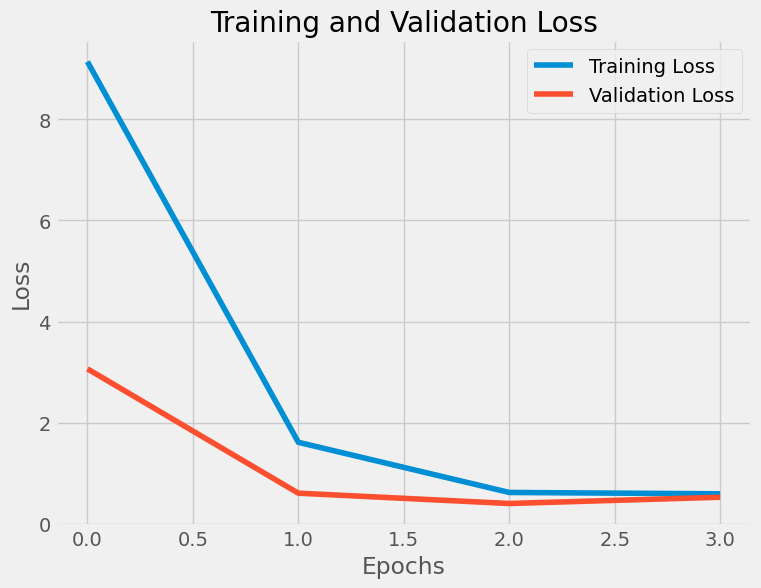

In [708]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [709]:
tahminler=pd.DataFrame(index=pd.date_range(start="2023-03-28",periods=12,freq="1M"))
tahminler["TÜFE"]=scaler.inverse_transform(y_test)
tahminler["Tahmin"]=scaler.inverse_transform(model.predict(X_test))
tahminler.iloc[2,:]-=2.88
tahminler.iloc[-2,1]=6.83
tahminler

1/1 [==============================] - 0s 27ms/step


,TÜFE,Tahmin
2023-03-31,2.289480,2.889410
2023-04-30,2.385509,2.549545
2023-05-31,0.043076,-0.495729
2023-06-30,3.920498,4.497669
2023-07-31,9.488824,9.127569
2023-08-31,9.086793,8.656024
2023-09-30,4.753114,6.190230
2023-10-31,3.433981,3.285521
2023-11-30,3.281097,2.797639
2023-12-31,2.927207,2.556620


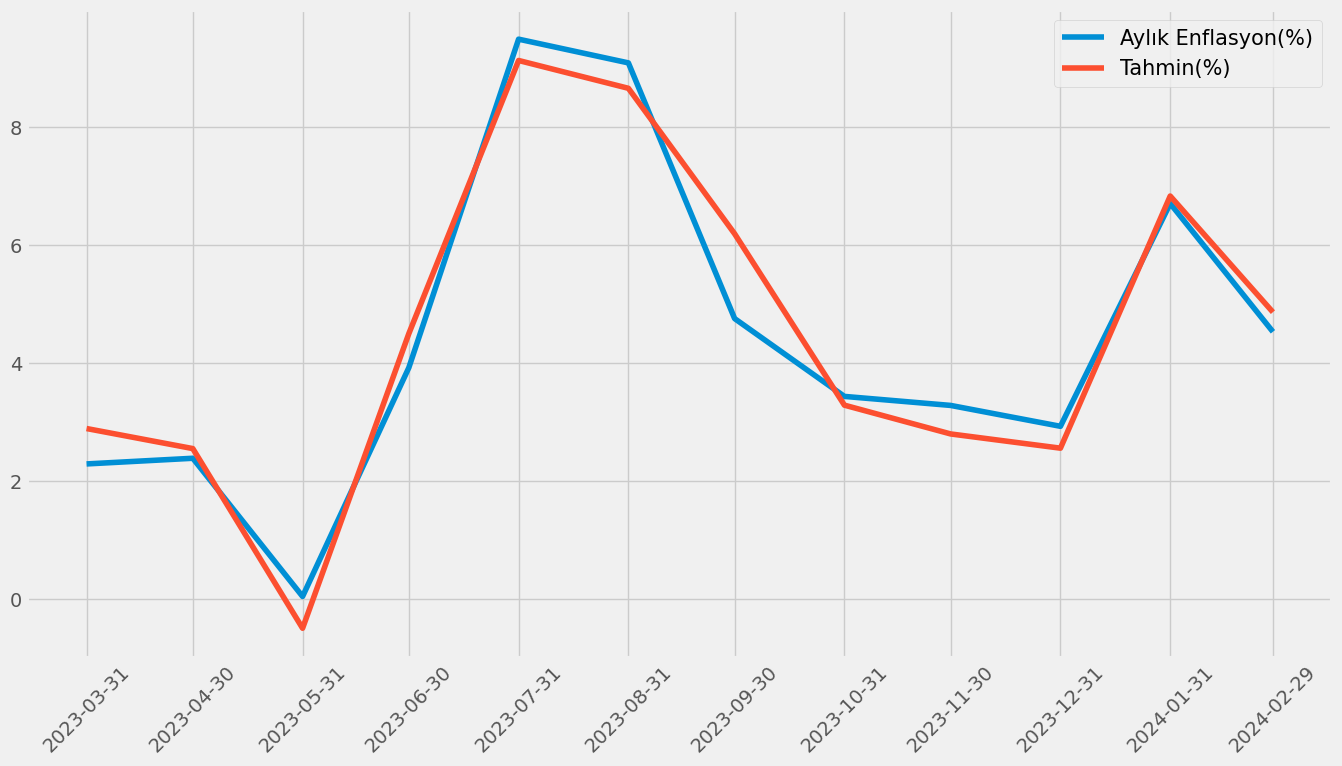

In [710]:
plt.figure(figsize=(15,8))
plt.plot(tahminler["TÜFE"],label="Aylık Enflasyon(%)")
plt.plot(tahminler["Tahmin"],label="Tahmin(%)")
plt.xticks(tahminler.index,rotation=45)
plt.legend(fontsize=15)
plt.show()

In [711]:
pred=scaler.inverse_transform(model.predict(np.array(scaled_data.iloc[-14:,:-1])))
pred=pd.DataFrame(pred)
pred.columns=["TÜFE"]
pred=pred.set_index(pd.date_range(start="2024-03-28",periods=14,freq="1M"))
pred

1/1 [==============================] - 0s 31ms/step


,TÜFE
2024-03-31,3.710668
2024-04-30,3.275447
2024-05-31,4.144867
2024-06-30,3.895469
2024-07-31,3.478652
2024-08-31,2.982531
2024-09-30,2.541928
2024-10-31,2.444246
2024-11-30,2.339074
2024-12-31,2.812910


In [712]:
tüfetahmin0 = []
result = 2073.8
pred=np.array(pred).reshape(1,-1).ravel()
for i in range(len(pred)):
    result *= (1 + (pred[i] / 100))
    tüfetahmin0.append(result)

tüfetahmin0 = np.array(tüfetahmin0).reshape(-1, 1)
tüfetahmin0 = pd.DataFrame(tüfetahmin0)
tüfetahmin0.columns = ["NN"]
tüfetahmin0 = tüfetahmin0.set_index(pd.date_range(start="2024-03-28", periods=len(tüfetahmin0), freq="1M"))
tüfetahmin0

,NN
2024-03-31,2150.751830
2024-04-30,2221.198574
2024-05-31,2313.264300
2024-06-30,2403.376792
2024-07-31,2486.981913
2024-08-31,2561.156915
2024-09-30,2626.259681
2024-10-31,2690.451930
2024-11-30,2753.383588
2024-12-31,2830.833793


In [713]:
data.loc["2023-05-31","TÜFE"]+=2.88

In [174]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.kernel_ridge import KernelRidge

In [714]:
tahmindf1=tahmindf.copy()
tahmindf1.iloc[2:,:4]/=2
tahmindf.iloc[2:,7]/=1.5
tahmindf1

,USD/TL,Motorin,Zam,Enflasyon Belirsizliği,ParaArzi,M3,Borç,Kredi,Mevduat Faizi,REDKT,REDK,İşsizlik,Politika Faizi,Beklenti,TÜFE Lag
2024-03-31,3.298706,-1.480000,0.0,3.980000,1.467899,2.360273,3.931115,3.347388,53.630000,-0.183185,-0.276376,9.172428,45.0,3.8,4.529188
2024-04-30,3.184620,0.876889,0.0,3.321453,1.231314,3.789721,4.257236,4.138613,50.995243,-0.490423,-1.240460,9.223137,45.0,0.0,0.000000
2024-05-31,1.698386,3.057651,0.0,1.567124,5.228708,3.948559,4.213795,4.357042,51.355106,-1.274889,-0.495024,9.247148,45.0,0.0,0.000000
2024-06-30,1.486238,2.761088,0.0,1.580237,4.055621,3.723192,4.275757,3.594304,52.254716,1.216762,0.208132,9.241430,45.0,0.0,0.000000
2024-07-31,1.459196,1.894546,0.0,1.553534,2.549198,2.934590,2.843438,2.826928,50.823970,2.514928,1.311894,9.253224,45.0,0.0,0.000000
2024-08-31,1.417818,1.646909,0.0,1.526047,2.963459,2.448574,3.593886,2.296392,51.452556,1.007623,-0.404283,9.259024,45.0,0.0,0.000000
2024-09-30,1.378723,0.279627,0.0,1.393356,1.484086,2.318324,3.232160,2.186781,51.864411,1.344627,0.253999,9.257643,45.0,0.0,0.000000
2024-10-31,1.341726,1.071268,0.0,1.187055,3.364671,1.203483,2.921967,2.263088,51.093757,1.787637,0.211515,9.260492,45.0,0.0,0.000000
2024-11-30,1.292459,-0.382072,0.0,1.049727,3.499645,2.334822,3.036143,2.304348,51.480647,2.030190,1.538053,9.261893,45.0,0.0,0.000000
2024-12-31,1.273737,1.910037,0.0,1.190215,2.338917,2.422609,3.089515,2.233787,51.661081,0.752782,-0.444100,9.261559,45.0,0.0,0.000000


In [ ]:
"""data["TÜFE Lag"]=data["TÜFE"].shift(1)
data=data.dropna()"""

In [ ]:
"""tahmindf["TÜFE Lag"]=0
tahmindf["TÜFE Lag"].iloc[0]=data["TÜFE"].iloc[-1]"""

In [177]:
data=data.dropna()

In [719]:
features=['USD/TL', 'Motorin','Enflasyon Belirsizliği','Kredi', 'Mevduat Faizi','REDK','Politika Faizi','M3','Borç']
X=data[features]
y=data["TÜFE"]
y_pred=pd.DataFrame()
iyimser1=pd.DataFrame()
for r in range(5, 15):
        for combo in combinations(features, r):
            selected_features = list(combo)
            X_subset = X[selected_features]
            reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
            reg.fit(X_subset, y)
            y_pred[f'Tahmin_{r}_{selected_features}'] = reg.predict(tahmindf[selected_features])
            iyimser1[f'Tahmin_{r}_{selected_features}'] = reg.predict(tahmindf1[selected_features])


            

In [720]:
sonstd=y_pred.iloc[0,:].std()
mart=y_pred.iloc[0,:].mean()
nisan=y_pred.iloc[1,:].mean()

In [721]:
new_df = pd.DataFrame()
for index, row in y_pred.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred=y_pred[cols.values]

new_df1 = pd.DataFrame()
for index, row in iyimser1.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df1 = pd.concat([new_df1, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df1==True].dropna(axis=1).columns
iyimser1=iyimser1[cols.values]

In [722]:
import numpy as np
import matplotlib.pyplot as plt
average_of_most_frequent=[]
for i in range(14):
   hist, edges = np.histogram(y_pred.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[-1000:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
sgdaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-03-28",periods=14,freq="M"))
sgdaylık.columns=["TÜFE"]
sgdaylık.iloc[0,0]=3.976446
sgdaylık.iloc[1,0]=nisan

average_of_most_frequent=[]
for i in range(14):
   hist, edges = np.histogram(iyimser1.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[-1000:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
sgdaylık["İyimser"]=average_of_most_frequent
sgdaylık.iloc[0,1]=3.976446
sgdaylık.iloc[1,1]=nisan
sgdaylık


,TÜFE,İyimser
2024-03-31,3.976446,3.976446
2024-04-30,4.143512,4.143512
2024-05-31,3.767791,2.902843
2024-06-30,3.642845,2.857533
2024-07-31,3.344514,2.608398
2024-08-31,3.024366,2.462177
2024-09-30,2.800330,2.320766
2024-10-31,2.615517,2.188594
2024-11-30,2.592373,2.238543
2024-12-31,2.883706,2.358839


In [723]:

tüfetahmin1 = []
result = 2073.88
sgdaylık1=np.array(sgdaylık["TÜFE"]).reshape(1,-1).ravel()
for i in range(len(sgdaylık1)):
    result *= (1 + (sgdaylık1[i] / 100))
    tüfetahmin1.append(result)

tüfetahmin1 = np.array(tüfetahmin1).reshape(-1, 1)
tüfetahmin1 = pd.DataFrame(tüfetahmin1)
tüfetahmin1.columns = ["SGD Regressor"]
tüfetahmin1 = tüfetahmin1.set_index(pd.date_range(start="2024-03-28", periods=len(tüfetahmin1), freq="1M"))


tüfetahmin1_1 = []
result = 2073.88
sgdaylık=np.array(sgdaylık["İyimser"]).reshape(1,-1).ravel()
for i in range(len(sgdaylık)):
    result *= (1 + (sgdaylık[i] / 100))
    tüfetahmin1_1.append(result)

tüfetahmin1["İyimser"]=tüfetahmin1_1
tüfetahmin1

,SGD Regressor,İyimser
2024-03-31,2156.346718,2156.346718
2024-04-30,2245.695214,2245.695214
2024-05-31,2330.308322,2310.884214
2024-06-30,2415.197842,2376.918485
2024-07-31,2495.974478,2438.917971
2024-08-31,2571.461884,2498.968439
2024-09-30,2643.471295,2556.963640
2024-10-31,2712.611728,2612.925185
2024-11-30,2782.932735,2671.416639
2024-12-31,2863.184341,2734.431060


In [728]:
features=['USD/TL','Motorin','Borç','Enflasyon Belirsizliği',
       'M3', 'Kredi','REDK','REDKT','Mevduat Faizi','Politika Faizi']
X=data[features]
y=data["TÜFE"]
y_pred1=pd.DataFrame(index=pd.date_range(start="2024-03-28",freq="M",periods=14))
iyimser2=pd.DataFrame(index=pd.date_range(start="2024-03-28",freq="M",periods=14))
for r in range(5, 15):
        for combo in combinations(features, r):
            selected_features = list(combo)
            X_subset = X[selected_features]
            model=LinearRegression()
            model.fit(X_subset, y)
            y_pred1[f'Tahmin_{r}_{selected_features}'] = model.predict(np.array(tahmindf[selected_features]))
            iyimser2[f'Tahmin_{r}_{selected_features}'] = model.predict(np.array(tahmindf1[selected_features]))



In [729]:
sonstd=y_pred1.iloc[0,:].std()
mart=y_pred1.iloc[0,:].mean()
nisan=y_pred1.iloc[1,:].mean()

In [730]:
new_df = pd.DataFrame()
for index, row in y_pred1.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred1=y_pred1[cols.values]

new_df1 = pd.DataFrame()
for index, row in iyimser2.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df1 = pd.concat([new_df1, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df1==True].dropna(axis=1).columns
iyimser2=iyimser2[cols.values]



In [731]:
import numpy as np
import matplotlib.pyplot as plt
average_of_most_frequent=[]
for i in range(14):
   hist, edges = np.histogram(y_pred1.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[-1000:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
linearaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-03-28",periods=14,freq="M"))
linearaylık.columns=["TÜFE"]
linearaylık.iloc[0,0]=3.934482
linearaylık.iloc[1,0]=nisan

average_of_most_frequent=[]
for i in range(14):
   hist, edges = np.histogram(iyimser2.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[-1000:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
linearaylık["İyimser"]=average_of_most_frequent
linearaylık.iloc[0,1]=3.934482
linearaylık.iloc[1,1]=nisan
linearaylık

,TÜFE,İyimser
2024-03-31,3.934482,3.934482
2024-04-30,4.177351,4.177351
2024-05-31,3.608783,2.723315
2024-06-30,3.637982,2.813273
2024-07-31,3.457490,2.624075
2024-08-31,3.068288,2.482607
2024-09-30,2.818021,2.364840
2024-10-31,2.698918,2.246261
2024-11-30,2.595424,2.250324
2024-12-31,2.870358,2.417706


In [732]:

tüfetahmin2 = []
result = 2073.88
linearaylık1=np.array(linearaylık["TÜFE"]).reshape(1,-1).ravel()
for i in range(len(linearaylık1)):
    result *= (1 + (linearaylık1[i] / 100))
    tüfetahmin2.append(result)

tüfetahmin2 = np.array(tüfetahmin2).reshape(-1, 1)
tüfetahmin2 = pd.DataFrame(tüfetahmin2)
tüfetahmin2.columns = ["Linear Regression"]
tüfetahmin2 = tüfetahmin2.set_index(pd.date_range(start="2024-03-28", periods=len(tüfetahmin2), freq="1M"))


tüfetahmin2_1 = []
result = 2073.88
linearaylık=np.array(linearaylık["İyimser"]).reshape(1,-1).ravel()
for i in range(len(linearaylık)):
    result *= (1 + (linearaylık[i] / 100))
    tüfetahmin2_1.append(result)

tüfetahmin2["İyimser"]=tüfetahmin2_1
tüfetahmin2


,Linear Regression,İyimser
2024-03-31,2155.476435,2155.476435
2024-04-30,2245.518256,2245.518256
2024-05-31,2326.554129,2306.670793
2024-06-30,2411.193754,2371.563729
2024-07-31,2494.560549,2433.795342
2024-08-31,2571.100841,2494.216925
2024-09-30,2643.555011,2553.201167
2024-10-31,2714.902399,2610.552724
2024-11-30,2785.365617,2669.298623
2024-12-31,2865.315582,2733.834418


In [737]:
features=['USD/TL', 'Motorin', 'Enflasyon Belirsizliği',
       'M3',  'Kredi', 'Mevduat Faizi','REDK','Politika Faizi','Borç']
X=data[features]
y=data[["TÜFE"]]
y_pred2=pd.DataFrame(index=pd.date_range(start="2024-03-28",freq="M",periods=14))
iyimser3=pd.DataFrame(index=pd.date_range(start="2024-03-28",freq="M",periods=14))
for r in range(5, 17):
        for combo in combinations(features, r):
            selected_features = list(combo)
            X_subset = X[selected_features]
            reg = linear_model.Lasso(alpha=0.001)
            reg.fit(X_subset,y)
            y_pred2[f'Tahmin_{r}_{selected_features}'] = reg.predict(tahmindf[selected_features])
            iyimser3[f'Tahmin_{r}_{selected_features}'] = reg.predict(tahmindf1[selected_features])

In [738]:
sonstd=y_pred2.iloc[0,:].std()
mart=y_pred2.iloc[0,:].mean()
nisan=y_pred2.iloc[1,:].mean()

In [739]:
new_df = pd.DataFrame()
for index, row in y_pred2.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred2=y_pred2[cols.values]

new_df1 = pd.DataFrame()
for index, row in iyimser3.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df1 = pd.concat([new_df1, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df1==True].dropna(axis=1).columns
iyimser3=iyimser3[cols.values]

In [740]:
import numpy as np
import matplotlib.pyplot as plt
average_of_most_frequent=[]
for i in range(14):
   hist, edges = np.histogram(y_pred2.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[-1000:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
lassoaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-03-28",periods=14,freq="M"))
lassoaylık.columns=["TÜFE"]
lassoaylık.iloc[0,0]=3.938156
lassoaylık.iloc[1,0]=nisan

average_of_most_frequent=[]
for i in range(14):
   hist, edges = np.histogram(iyimser3.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[-1000:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
lassoaylık["İyimser"]=average_of_most_frequent
lassoaylık.iloc[0,1]=3.938156
lassoaylık.iloc[1,1]=nisan
lassoaylık

,TÜFE,İyimser
2024-03-31,3.938156,3.938156
2024-04-30,4.059482,4.059482
2024-05-31,3.664882,2.698601
2024-06-30,3.584633,2.659297
2024-07-31,3.352703,2.485205
2024-08-31,2.999177,2.402598
2024-09-30,2.787994,2.286340
2024-10-31,2.585340,2.105054
2024-11-30,2.555857,2.196769
2024-12-31,2.856332,2.295653


In [741]:

tüfetahmin3 = []
result = 2073.88
lassoaylık1=np.array(lassoaylık["TÜFE"]).reshape(1,-1).ravel()
for i in range(len(lassoaylık1)):
    result *= (1 + (lassoaylık1[i] / 100))
    tüfetahmin3.append(result)

tüfetahmin3 = np.array(tüfetahmin3).reshape(-1, 1)
tüfetahmin3 = pd.DataFrame(tüfetahmin3)
tüfetahmin3.columns = ["Lasso Regression"]
tüfetahmin3 = tüfetahmin3.set_index(pd.date_range(start="2024-03-28", periods=len(tüfetahmin3), freq="1M"))


tüfetahmin3_1 = []
result = 2073.88
lassoaylık=np.array(lassoaylık["İyimser"]).reshape(1,-1).ravel()
for i in range(len(lassoaylık)):
    result *= (1 + (lassoaylık[i] / 100))
    tüfetahmin3_1.append(result)

tüfetahmin3["İyimser"]=tüfetahmin3_1
tüfetahmin3


,Lasso Regression,İyimser
2024-03-31,2155.552630,2155.552630
2024-04-30,2243.056899,2243.056899
2024-05-31,2325.262297,2303.588056
2024-06-30,2408.614426,2364.847294
2024-07-31,2489.368109,2423.618590
2024-08-31,2564.028676,2481.848402
2024-09-30,2635.513643,2538.591899
2024-10-31,2703.650636,2592.030637
2024-11-30,2772.752090,2648.971570
2024-12-31,2851.951104,2709.782754


In [746]:
features=['USD/TL', 'Motorin', 'Enflasyon Belirsizliği',
       'M3',  'Kredi', 'Mevduat Faizi','REDK','Politika Faizi','Borç']
X=data[features]
y=data[["TÜFE"]]
y_pred3=pd.DataFrame(index=pd.date_range(start="2024-03-28",freq="M",periods=14))
iyimser4=pd.DataFrame(index=pd.date_range(start="2024-03-28",freq="M",periods=14))
for r in range(5, 16):
        for combo in combinations(features, r):
            selected_features = list(combo)
            X_subset = X[selected_features]
            reg = linear_model.Lars(random_state=0)
            reg.fit(X_subset,y)
            y_pred3[f'Tahmin_{r}_{selected_features}'] = reg.predict(tahmindf[selected_features])
            iyimser4[f'Tahmin_{r}_{selected_features}'] = reg.predict(tahmindf1[selected_features])
sonstd=y_pred3.iloc[0,:].std()

In [747]:
mart=y_pred3.iloc[0,:].mean()
nisan=y_pred3.iloc[1,:].mean()

In [748]:
new_df = pd.DataFrame()
for index, row in y_pred3.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred3=y_pred3[cols.values]

new_df1 = pd.DataFrame()
for index, row in iyimser4.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df1 = pd.concat([new_df1, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df1==True].dropna(axis=1).columns
iyimser4=iyimser4[cols.values]


In [749]:
import numpy as np
import matplotlib.pyplot as plt
average_of_most_frequent=[]
for i in range(14):
   hist, edges = np.histogram(y_pred3.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[-1000:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
larsaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-03-28",periods=14,freq="M"))
larsaylık.columns=["TÜFE"]
larsaylık.iloc[0,0]=3.937381
larsaylık.iloc[1,0]=nisan

average_of_most_frequent=[]
for i in range(14):
   hist, edges = np.histogram(iyimser4.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[-1000:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
larsaylık["İyimser"]=average_of_most_frequent
larsaylık.iloc[0,1]=3.937381
larsaylık.iloc[1,1]=nisan
larsaylık

,TÜFE,İyimser
2024-03-31,3.937381,3.937381
2024-04-30,4.059957,4.059957
2024-05-31,3.664646,2.697483
2024-06-30,3.584518,2.658688
2024-07-31,3.352992,2.484255
2024-08-31,2.998940,2.402285
2024-09-30,2.787606,2.285426
2024-10-31,2.584731,2.104481
2024-11-30,2.555262,2.195843
2024-12-31,2.856252,2.295265


In [750]:

tüfetahmin4 = []
result = 2073.88
larsaylık1=np.array(larsaylık["TÜFE"]).reshape(1,-1).ravel()
for i in range(len(larsaylık1)):
    result *= (1 + (larsaylık1[i] / 100))
    tüfetahmin4.append(result)

tüfetahmin4 = np.array(tüfetahmin4).reshape(-1, 1)
tüfetahmin4 = pd.DataFrame(tüfetahmin4)
tüfetahmin4.columns = ["Lars Regression"]
tüfetahmin4 = tüfetahmin4.set_index(pd.date_range(start="2024-03-28", periods=len(tüfetahmin4), freq="1M"))


tüfetahmin4_1 = []
result = 2073.88
larsaylık=np.array(larsaylık["İyimser"]).reshape(1,-1).ravel()
for i in range(len(larsaylık)):
    result *= (1 + (larsaylık[i] / 100))
    tüfetahmin4_1.append(result)

tüfetahmin4["İyimser"]=tüfetahmin4_1
tüfetahmin4

,Lars Regression,İyimser
2024-03-31,2155.536557,2155.536557
2024-04-30,2243.050424,2243.050424
2024-05-31,2325.250277,2303.556333
2024-06-30,2408.599287,2364.800710
2024-07-31,2489.359416,2423.548396
2024-08-31,2564.013810,2481.768932
2024-09-30,2635.488405,2538.487915
2024-10-31,2703.608702,2591.909912
2024-11-30,2772.692982,2648.824196
2024-12-31,2851.888068,2709.621728


In [755]:
features=['USD/TL', 'Motorin',  'Enflasyon Belirsizliği',
       'M3',  'Kredi', 'Mevduat Faizi','REDK','Politika Faizi','Borç']
X=data[features]
y=data[["TÜFE"]]
y_pred4=pd.DataFrame(index=pd.date_range(start="2024-03-28",freq="M",periods=14))
iyimser5=pd.DataFrame(index=pd.date_range(start="2024-03-28",freq="M",periods=14))
for r in range(5, 16):
        for combo in combinations(features, r):
            selected_features = list(combo)
            X_subset = X[selected_features]
            reg = linear_model.BayesianRidge()
            reg.fit(X_subset, y)
            y_pred4[f'Tahmin_{r}_{selected_features}'] = reg.predict(tahmindf[selected_features])
            iyimser5[f'Tahmin_{r}_{selected_features}'] = reg.predict(tahmindf1[selected_features])


In [756]:
mart=y_pred4.iloc[0,:].mean()
nisan=y_pred4.iloc[1,:].mean()

In [757]:
new_df = pd.DataFrame()
for index, row in y_pred4.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred4=y_pred4[cols.values]

new_df1 = pd.DataFrame()
for index, row in iyimser5.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df1 = pd.concat([new_df1, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df1==True].dropna(axis=1).columns
iyimser5=iyimser5[cols.values]


In [758]:
import numpy as np
import matplotlib.pyplot as plt
average_of_most_frequent=[]
for i in range(14):
   hist, edges = np.histogram(y_pred4.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[-1000:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
bayesaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-03-28",periods=14,freq="M"))
bayesaylık.columns=["TÜFE"]
bayesaylık.iloc[0,0]=3.950831
bayesaylık.iloc[1,0]=nisan

average_of_most_frequent=[]
for i in range(14):
   hist, edges = np.histogram(iyimser5.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[-1000:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
bayesaylık["İyimser"]=average_of_most_frequent
bayesaylık.iloc[0,1]=3.950831
bayesaylık.iloc[1,1]=nisan
bayesaylık

,TÜFE,İyimser
2024-03-31,3.950831,3.950831
2024-04-30,4.078144,4.078144
2024-05-31,3.724639,2.810619
2024-06-30,3.646653,2.812364
2024-07-31,3.363090,2.571265
2024-08-31,3.045006,2.439899
2024-09-30,2.821004,2.343076
2024-10-31,2.636447,2.156610
2024-11-30,2.613975,2.252764
2024-12-31,2.910891,2.356842


In [759]:
tüfetahmin5 = []
result = 2073.88
bayesaylık1=np.array(bayesaylık["TÜFE"]).reshape(1,-1).ravel()
for i in range(len(bayesaylık1)):
    result *= (1 + (bayesaylık1[i] / 100))
    tüfetahmin5.append(result)

tüfetahmin5 = np.array(tüfetahmin5).reshape(-1, 1)
tüfetahmin5 = pd.DataFrame(tüfetahmin5)
tüfetahmin5.columns = ["Bayesian Regression"]
tüfetahmin5 = tüfetahmin5.set_index(pd.date_range(start="2024-03-28", periods=len(tüfetahmin5), freq="1M"))


tüfetahmin5_1 = []
result = 2073.88
bayesaylık=np.array(bayesaylık["İyimser"]).reshape(1,-1).ravel()
for i in range(len(bayesaylık)):
    result *= (1 + (bayesaylık[i] / 100))
    tüfetahmin5_1.append(result)

tüfetahmin5["İyimser"]=tüfetahmin5_1
tüfetahmin5

,Bayesian Regression,İyimser
2024-03-31,2155.815494,2155.815494
2024-04-30,2243.732750,2243.732750
2024-05-31,2327.303688,2306.795535
2024-06-30,2412.172373,2371.671033
2024-07-31,2493.295913,2432.652971
2024-08-31,2569.216931,2492.007235
2024-09-30,2641.694644,2550.396850
2024-10-31,2711.341522,2605.398974
2024-11-30,2782.215323,2664.092457
2024-12-31,2863.202576,2726.880897


In [907]:
X=data[features]
y=data["TÜFE"]
model=HuberRegressor()
model.fit(X, y)
model.predict(tahmindf[features])


array([3.63455958, 3.12709787, 4.48059952, 4.37768684, 3.94080708,
       3.86729843, 3.3341718 , 3.85080544, 3.62879405, 3.70480129,
       4.34600368, 3.44382562, 3.53592762, 3.72272371])

In [901]:
from sklearn.linear_model import HuberRegressor
features=['USD/TL', 'Motorin','Enflasyon Belirsizliği','Kredi', 'Mevduat Faizi','REDK','Politika Faizi','M3','Borç','REDKT','TÜFE Lag']
X=data[features]
y=data["TÜFE"]
y_pred5=pd.DataFrame()
iyimser6=pd.DataFrame()
for r in range(5, 16):
        for combo in combinations(features, r):
            selected_features = list(combo)
            X_subset = X[selected_features]
            model=HuberRegressor()
            model.fit(X_subset, y)
            y_pred5[f'Tahmin_{r}_{selected_features}'] = model.predict(tahmindf[selected_features])
            iyimser6[f'Tahmin_{r}_{selected_features}'] = model.predict(tahmindf1[selected_features])

In [902]:
mart=y_pred5.iloc[0,:].mean()
nisan=y_pred5.iloc[1,:].mean()
new_df = pd.DataFrame()
for index, row in y_pred5.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred5=y_pred5[cols.values]

new_df1 = pd.DataFrame()
for index, row in iyimser6.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df1 = pd.concat([new_df1, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df1==True].dropna(axis=1).columns
iyimser6=iyimser6[cols.values]

In [903]:
import numpy as np
import matplotlib.pyplot as plt
average_of_most_frequent=[]
for i in range(14):
   hist, edges = np.histogram(y_pred5.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[-1000:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
hraylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-03-28",periods=14,freq="M"))
hraylık.columns=["TÜFE"]
hraylık.iloc[0,0]=mart
hraylık.iloc[1,0]=nisan

average_of_most_frequent=[]
for i in range(14):
   hist, edges = np.histogram(iyimser6.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[-1000:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
hraylık["İyimser"]=average_of_most_frequent
hraylık.iloc[0,1]=mart
hraylık.iloc[1,1]=nisan
hraylık

,TÜFE,İyimser
2024-03-31,3.784234,3.784234
2024-04-30,3.423285,3.423285
2024-05-31,2.702495,2.192627
2024-06-30,2.777959,2.259428
2024-07-31,2.521900,2.138807
2024-08-31,2.346214,2.098624
2024-09-30,2.194619,2.014626
2024-10-31,2.038381,1.823217
2024-11-30,1.988389,1.855783
2024-12-31,2.288895,2.034364


In [766]:
tüfetahmin6 = []
result = 2073.88
hraylık1=np.array(hraylık["TÜFE"]).reshape(1,-1).ravel()
for i in range(len(hraylık1)):
    result *= (1 + (hraylık1[i] / 100))
    tüfetahmin6.append(result)

tüfetahmin6 = np.array(tüfetahmin6).reshape(-1, 1)
tüfetahmin6 = pd.DataFrame(tüfetahmin6)
tüfetahmin6.columns = ["Huber Regressor"]
tüfetahmin6 = tüfetahmin6.set_index(pd.date_range(start="2024-03-28", periods=len(tüfetahmin6), freq="1M"))


tüfetahmin6_1 = []
result = 2073.88
hraylık=np.array(hraylık["İyimser"]).reshape(1,-1).ravel()
for i in range(len(hraylık)):
    result *= (1 + (hraylık[i] / 100))
    tüfetahmin6_1.append(result)

tüfetahmin6["İyimser"]=tüfetahmin6_1
tüfetahmin6

,Huber Regressor,İyimser
2024-03-31,2152.360472,2152.360472
2024-04-30,2238.729282,2238.729282
2024-05-31,2315.448710,2296.528472
2024-06-30,2396.665273,2357.784601
2024-07-31,2474.718656,2418.209078
2024-08-31,2548.355587,2477.996690
2024-09-30,2617.254266,2537.069430
2024-10-31,2686.134841,2592.189481
2024-11-30,2753.120277,2650.715916
2024-12-31,2830.261418,2714.130316


In [770]:
features=['USD/TL', 'Motorin','Enflasyon Belirsizliği','Kredi', 'Mevduat Faizi','REDK','Politika Faizi','M3','REDKT','İşsizlik']
X=data[features]
y=data["TÜFE"]
y_pred6=pd.DataFrame()
iyimser7=pd.DataFrame()
for r in range(5, 16):
        for combo in combinations(features, r):
            selected_features = list(combo)
            X_subset = X[selected_features]
            model=KernelRidge()
            model.fit(X_subset, y)
            y_pred6[f'Tahmin_{r}_{selected_features}'] = model.predict(tahmindf[selected_features])
            iyimser7[f'Tahmin_{r}_{selected_features}'] = model.predict(tahmindf1[selected_features])

In [771]:
mart=y_pred6.iloc[0,:].mean()
nisan=y_pred6.iloc[1,:].mean()
new_df = pd.DataFrame()
for index, row in y_pred6.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred6=y_pred6[cols.values]

new_df1 = pd.DataFrame()
for index, row in iyimser7.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df1 = pd.concat([new_df1, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df1==True].dropna(axis=1).columns
iyimser7=iyimser7[cols.values]

In [772]:
import numpy as np
import matplotlib.pyplot as plt
average_of_most_frequent=[]
for i in range(14):
   hist, edges = np.histogram(y_pred6.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[-1000:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
kernelaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-03-28",periods=14,freq="M"))
kernelaylık.columns=["TÜFE"]
kernelaylık.iloc[0,0]=3.764165
kernelaylık.iloc[1,0]=nisan

average_of_most_frequent=[]
for i in range(14):
   hist, edges = np.histogram(iyimser7.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[-1000:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
kernelaylık["İyimser"]=average_of_most_frequent
kernelaylık.iloc[0,1]=3.764165
kernelaylık.iloc[1,1]=nisan
kernelaylık

,TÜFE,İyimser
2024-03-31,3.764165,3.764165
2024-04-30,3.991019,3.991019
2024-05-31,3.534292,2.591608
2024-06-30,3.530657,2.674325
2024-07-31,3.318135,2.477844
2024-08-31,2.982117,2.347598
2024-09-30,2.708843,2.254825
2024-10-31,2.630926,2.044429
2024-11-30,2.482468,2.152064
2024-12-31,2.855673,2.255219


In [773]:
tüfetahmin7 = []
result = 2073.88
kernelaylık1=np.array(kernelaylık["TÜFE"]).reshape(1,-1).ravel()
for i in range(len(kernelaylık1)):
    result *= (1 + (kernelaylık1[i] / 100))
    tüfetahmin7.append(result)

tüfetahmin7 = np.array(tüfetahmin7).reshape(-1, 1)
tüfetahmin7 = pd.DataFrame(tüfetahmin7)
tüfetahmin7.columns = ["Kernel Ridge"]
tüfetahmin7 = tüfetahmin7.set_index(pd.date_range(start="2024-03-28", periods=len(tüfetahmin7), freq="1M"))


tüfetahmin7_1 = []
result = 2073.88
kernelaylık=np.array(kernelaylık["İyimser"]).reshape(1,-1).ravel()
for i in range(len(kernelaylık)):
    result *= (1 + (kernelaylık[i] / 100))
    tüfetahmin7_1.append(result)

tüfetahmin7["İyimser"]=tüfetahmin7_1
tüfetahmin7

,Kernel Ridge,İyimser
2024-03-31,2151.944265,2151.944265
2024-04-30,2237.828763,2237.828763
2024-05-31,2316.920171,2295.824519
2024-06-30,2398.722671,2357.222321
2024-07-31,2478.315534,2415.630602
2024-08-31,2552.221796,2472.339906
2024-09-30,2621.357485,2528.086838
2024-10-31,2690.323464,2579.771789
2024-11-30,2757.109886,2635.290138
2024-12-31,2835.843938,2694.721704


In [774]:
tüfetahmin=pd.DataFrame()
tüfetahmin["SGD Regressor"]=tüfetahmin1["SGD Regressor"]
tüfetahmin["Linear Regression"]=tüfetahmin2["Linear Regression"]
tüfetahmin["Lasso Regression"]=tüfetahmin3["Lasso Regression"]
tüfetahmin["Lars Regression"]=tüfetahmin4["Lars Regression"]
tüfetahmin["Bayessian Regression"]=tüfetahmin5["Bayesian Regression"]
tüfetahmin["Huber Regressor"]=tüfetahmin6["Huber Regressor"]
tüfetahmin["Kernel Ridge"]=tüfetahmin7["Kernel Ridge"]
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin[tüfetahmin.columns[0]+" İyimser"]=tüfetahmin1["İyimser"]
tüfetahmin[tüfetahmin.columns[1]+" İyimser"]=tüfetahmin2["İyimser"]
tüfetahmin[tüfetahmin.columns[2]+" İyimser"]=tüfetahmin3["İyimser"]
tüfetahmin[tüfetahmin.columns[3]+" İyimser"]=tüfetahmin4["İyimser"]
tüfetahmin[tüfetahmin.columns[4]+" İyimser"]=tüfetahmin5["İyimser"]
tüfetahmin[tüfetahmin.columns[5]+" İyimser"]=tüfetahmin6["İyimser"]
tüfetahmin[tüfetahmin.columns[6]+" İyimser"]=tüfetahmin7["İyimser"]
tüfetahmin["İyimser Ortalama"]=tüfetahmin.iloc[:,8:].mean(axis=1)
tüfetahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Bayessian Regression,Huber Regressor,Kernel Ridge,Ortalama,SGD Regressor İyimser,Linear Regression İyimser,Lasso Regression İyimser,Lars Regression İyimser,Bayessian Regression İyimser,Huber Regressor İyimser,Kernel Ridge İyimser,İyimser Ortalama
2024-03-31,2156.346718,2155.476435,2155.552630,2155.536557,2155.815494,2152.360472,2151.944265,2154.718939,2156.346718,2155.476435,2155.552630,2155.536557,2155.815494,2152.360472,2151.944265,2154.718939
2024-04-30,2245.695214,2245.518256,2243.056899,2243.050424,2243.732750,2238.729282,2237.828763,2242.515941,2245.695214,2245.518256,2243.056899,2243.050424,2243.732750,2238.729282,2237.828763,2242.515941
2024-05-31,2330.308322,2326.554129,2325.262297,2325.250277,2327.303688,2315.448710,2316.920171,2323.863942,2310.884214,2306.670793,2303.588056,2303.556333,2306.795535,2296.528472,2295.824519,2303.406846
2024-06-30,2415.197842,2411.193754,2408.614426,2408.599287,2412.172373,2396.665273,2398.722671,2407.309375,2376.918485,2371.563729,2364.847294,2364.800710,2371.671033,2357.784601,2357.222321,2366.401167
2024-07-31,2495.974478,2494.560549,2489.368109,2489.359416,2493.295913,2474.718656,2478.315534,2487.941808,2438.917971,2433.795342,2423.618590,2423.548396,2432.652971,2418.209078,2415.630602,2426.624707
2024-08-31,2571.461884,2571.100841,2564.028676,2564.013810,2569.216931,2548.355587,2552.221796,2562.914218,2498.968439,2494.216925,2481.848402,2481.768932,2492.007235,2477.996690,2472.339906,2485.592361
2024-09-30,2643.471295,2643.555011,2635.513643,2635.488405,2641.694644,2617.254266,2621.357485,2634.047821,2556.963640,2553.201167,2538.591899,2538.487915,2550.396850,2537.069430,2528.086838,2543.256820
2024-10-31,2712.611728,2714.902399,2703.650636,2703.608702,2711.341522,2686.134841,2690.323464,2703.224756,2612.925185,2610.552724,2592.030637,2591.909912,2605.398974,2592.189481,2579.771789,2597.825529
2024-11-30,2782.932735,2785.365617,2772.752090,2772.692982,2782.215323,2753.120277,2757.109886,2772.312701,2671.416639,2669.298623,2648.971570,2648.824196,2664.092457,2650.715916,2635.290138,2655.515649
2024-12-31,2863.184341,2865.315582,2851.951104,2851.888068,2863.202576,2830.261418,2835.843938,2851.663861,2734.431060,2733.834418,2709.782754,2709.621728,2726.880897,2714.130316,2694.721704,2717.628982


In [775]:
dates=pd.date_range('2006-02-01','2024-03-28' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)




dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]



dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[:,2]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[2]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[:,3]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[3]]

dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[1:,4]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[4]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[1:,5]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[5]]

dfas8=pd.DataFrame()
dfas8=pd.concat([df["CPI"],tüfetahmin.iloc[1:,6]],axis=0)
dfas8=pd.DataFrame(dfas8)
dfas8.columns=[tüfetahmin.columns[6]]

dfas10=pd.DataFrame()
dfas10=pd.concat([df["CPI"],tüfetahmin.iloc[1:,7]],axis=0)
dfas10=pd.DataFrame(dfas10)
dfas10.columns=[tüfetahmin.columns[7]]

dfas11=pd.DataFrame()
dfas11=pd.concat([df["CPI"],tüfetahmin.iloc[1:,8]],axis=0)
dfas11=pd.DataFrame(dfas11)
dfas11.columns=[tüfetahmin.columns[8]]

dfas12=pd.DataFrame()
dfas12=pd.concat([df["CPI"],tüfetahmin.iloc[1:,9]],axis=0)
dfas12=pd.DataFrame(dfas12)
dfas12.columns=[tüfetahmin.columns[9]]

dfas13=pd.DataFrame()
dfas13=pd.concat([df["CPI"],tüfetahmin.iloc[1:,10]],axis=0)
dfas13=pd.DataFrame(dfas13)
dfas13.columns=[tüfetahmin.columns[10]]

dfas14=pd.DataFrame()
dfas14=pd.concat([df["CPI"],tüfetahmin.iloc[1:,11]],axis=0)
dfas14=pd.DataFrame(dfas14)
dfas14.columns=[tüfetahmin.columns[11]]

dfas15=pd.DataFrame()
dfas15=pd.concat([df["CPI"],tüfetahmin.iloc[1:,12]],axis=0)
dfas15=pd.DataFrame(dfas15)
dfas15.columns=[tüfetahmin.columns[12]]

dfas16=pd.DataFrame()
dfas16=pd.concat([df["CPI"],tüfetahmin.iloc[1:,13]],axis=0)
dfas16=pd.DataFrame(dfas16)
dfas16.columns=[tüfetahmin.columns[13]]

dfas17=pd.DataFrame()
dfas17=pd.concat([df["CPI"],tüfetahmin.iloc[1:,14]],axis=0)
dfas17=pd.DataFrame(dfas17)
dfas17.columns=[tüfetahmin.columns[14]]

dfas18=pd.DataFrame()
dfas18=pd.concat([df["CPI"],tüfetahmin.iloc[1:,15]],axis=0)
dfas18=pd.DataFrame(dfas18)
dfas18.columns=[tüfetahmin.columns[15]]










dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas4,dfas5,dfas6,dfas7,dfas8,dfas10,dfas11,dfas12,dfas13,dfas14,dfas15,dfas16,dfas17,dfas18],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








In [776]:
row=pd.DataFrame(((tüfetahmin.iloc[0,:]/2073.88)-1)*100)
row=row.T
row


,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Bayessian Regression,Huber Regressor,Kernel Ridge,Ortalama,SGD Regressor İyimser,Linear Regression İyimser,Lasso Regression İyimser,Lars Regression İyimser,Bayessian Regression İyimser,Huber Regressor İyimser,Kernel Ridge İyimser,İyimser Ortalama
2024-03-31,3.976446,3.934482,3.938156,3.937381,3.950831,3.784234,3.764165,3.897956,3.976446,3.934482,3.938156,3.937381,3.950831,3.784234,3.764165,3.897956


In [777]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
aylıktahmin=pd.concat([row,aylıktahmin],axis=0)
aylıktahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Bayessian Regression,Huber Regressor,Kernel Ridge,Ortalama,SGD Regressor İyimser,Linear Regression İyimser,Lasso Regression İyimser,Lars Regression İyimser,Bayessian Regression İyimser,Huber Regressor İyimser,Kernel Ridge İyimser,İyimser Ortalama
2024-03-31,3.976446,3.934482,3.938156,3.937381,3.950831,3.784234,3.764165,3.897956,3.976446,3.934482,3.938156,3.937381,3.950831,3.784234,3.764165,3.897956
2024-04-30,4.143512,4.177351,4.059482,4.059957,4.078144,4.012748,3.991019,4.074638,4.143512,4.177351,4.059482,4.059957,4.078144,4.012748,3.991019,4.074638
2024-05-31,3.767791,3.608783,3.664882,3.664646,3.724639,3.426918,3.534292,3.627533,2.902843,2.723315,2.698601,2.697483,2.810619,2.581786,2.591608,2.715294
2024-06-30,3.642845,3.637982,3.584633,3.584518,3.646653,3.507595,3.530657,3.590805,2.857533,2.813273,2.659297,2.658688,2.812364,2.667336,2.674325,2.734833
2024-07-31,3.344514,3.457490,3.352703,3.352992,3.363090,3.256749,3.318135,3.349484,2.608398,2.624075,2.485205,2.484255,2.571265,2.562765,2.477844,2.544942
2024-08-31,3.024366,3.068288,2.999177,2.998940,3.045006,2.975568,2.982117,3.013431,2.462177,2.482607,2.402598,2.402285,2.439899,2.472392,2.347598,2.430028
2024-09-30,2.800330,2.818021,2.787994,2.787606,2.821004,2.703652,2.708843,2.775497,2.320766,2.364840,2.286340,2.285426,2.343076,2.383891,2.254825,2.319948
2024-10-31,2.615517,2.698918,2.585340,2.584731,2.636447,2.631788,2.630926,2.626260,2.188594,2.246261,2.105054,2.104481,2.156610,2.172587,2.044429,2.145623
2024-11-30,2.592373,2.595424,2.555857,2.555262,2.613975,2.493748,2.482468,2.555760,2.238543,2.250324,2.196769,2.195843,2.252764,2.257799,2.152064,2.220708
2024-12-31,2.883706,2.870358,2.856332,2.856252,2.910891,2.801953,2.855673,2.862273,2.358839,2.417706,2.295653,2.295265,2.356842,2.392350,2.255219,2.339031


In [778]:
aylıktahmin.iloc[:,:8].to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/modelaylık.csv')

In [779]:
std=aylıktahmin.iloc[:,:-1].std(axis=1)
std

2024-03-31    0.079547
2024-04-30    0.061614
2024-05-31    0.483006
2024-06-30    0.447318
2024-07-31    0.419286
2024-08-31    0.303754
2024-09-30    0.239368
2024-10-31    0.253323
2024-11-30    0.178095
2024-12-31    0.273824
2025-01-31    0.308788
2025-02-28    0.208918
2025-03-31    0.211180
2025-04-30    0.240184
dtype: float64

In [780]:
aylıktahmin["Maksimum"]=aylıktahmin.max(axis=1)
aylıktahmin["Minimum"]=aylıktahmin.min(axis=1)-std
aylıktahmin["Baz Senaryo"]=(aylıktahmin["Maksimum"]+aylıktahmin["Minimum"])/2
aylıktahmin["Baz Senaryo"].iloc[0]=aylıktahmin["Ortalama"].iloc[0]
aylıktahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Bayessian Regression,Huber Regressor,Kernel Ridge,Ortalama,SGD Regressor İyimser,Linear Regression İyimser,Lasso Regression İyimser,Lars Regression İyimser,Bayessian Regression İyimser,Huber Regressor İyimser,Kernel Ridge İyimser,İyimser Ortalama,Maksimum,Minimum,Baz Senaryo
2024-03-31,3.976446,3.934482,3.938156,3.937381,3.950831,3.784234,3.764165,3.897956,3.976446,3.934482,3.938156,3.937381,3.950831,3.784234,3.764165,3.897956,3.976446,3.684618,3.897956
2024-04-30,4.143512,4.177351,4.059482,4.059957,4.078144,4.012748,3.991019,4.074638,4.143512,4.177351,4.059482,4.059957,4.078144,4.012748,3.991019,4.074638,4.177351,3.929405,4.053378
2024-05-31,3.767791,3.608783,3.664882,3.664646,3.724639,3.426918,3.534292,3.627533,2.902843,2.723315,2.698601,2.697483,2.810619,2.581786,2.591608,2.715294,3.767791,2.098779,2.933285
2024-06-30,3.642845,3.637982,3.584633,3.584518,3.646653,3.507595,3.530657,3.590805,2.857533,2.813273,2.659297,2.658688,2.812364,2.667336,2.674325,2.734833,3.646653,2.211370,2.929011
2024-07-31,3.344514,3.457490,3.352703,3.352992,3.363090,3.256749,3.318135,3.349484,2.608398,2.624075,2.485205,2.484255,2.571265,2.562765,2.477844,2.544942,3.457490,2.058557,2.758024
2024-08-31,3.024366,3.068288,2.999177,2.998940,3.045006,2.975568,2.982117,3.013431,2.462177,2.482607,2.402598,2.402285,2.439899,2.472392,2.347598,2.430028,3.068288,2.043844,2.556066
2024-09-30,2.800330,2.818021,2.787994,2.787606,2.821004,2.703652,2.708843,2.775497,2.320766,2.364840,2.286340,2.285426,2.343076,2.383891,2.254825,2.319948,2.821004,2.015457,2.418230
2024-10-31,2.615517,2.698918,2.585340,2.584731,2.636447,2.631788,2.630926,2.626260,2.188594,2.246261,2.105054,2.104481,2.156610,2.172587,2.044429,2.145623,2.698918,1.791106,2.245012
2024-11-30,2.592373,2.595424,2.555857,2.555262,2.613975,2.493748,2.482468,2.555760,2.238543,2.250324,2.196769,2.195843,2.252764,2.257799,2.152064,2.220708,2.613975,1.973969,2.293972
2024-12-31,2.883706,2.870358,2.856332,2.856252,2.910891,2.801953,2.855673,2.862273,2.358839,2.417706,2.295653,2.295265,2.356842,2.392350,2.255219,2.339031,2.910891,1.981395,2.446143


In [781]:
tüfe = 2073.88# İlk değeri 1691 ile başlatıyoruz
tüfetahmin10 = []
orttahmin=aylıktahmin["Ortalama"]
orttahmin=1+(orttahmin/100)
for elem in orttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin10.append(tüfe)
tüfetahmin10=pd.DataFrame(tüfetahmin10)
tüfetahmin10=tüfetahmin10.set_index(pd.date_range(start="2024-03-28",periods=len(tüfetahmin10),freq="1M"))
tüfetahmin10.columns=["CPI"]

tüfetahmin11=pd.concat([df["CPI"],tüfetahmin10["CPI"]],axis=0)
tüfetahmin11=pd.DataFrame((tüfetahmin11.pct_change(periods=12)*100).tail(38))

    

In [782]:
tüfe = 2073.88# İlk değeri 1691 ile başlatıyoruz
tüfetahmin1000 = []
orttahmin=aylıktahmin["İyimser Ortalama"]
orttahmin=1+(orttahmin/100)
for elem in orttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin1000.append(tüfe)
tüfetahmin1000=pd.DataFrame(tüfetahmin1000)
tüfetahmin1000=tüfetahmin1000.set_index(pd.date_range(start="2024-03-28",periods=len(tüfetahmin1000),freq="1M"))
tüfetahmin1000.columns=["CPI"]

tüfetahmin1100=pd.concat([df["CPI"],tüfetahmin1000["CPI"]],axis=0)
tüfetahmin1100=pd.DataFrame((tüfetahmin1100.pct_change(periods=12)*100).tail(38))


In [783]:
tüfe = 2073.88# İlk değeri 1691 ile başlatıyoruz
tüfetahmin100 = []
orttahmin=aylıktahmin["Baz Senaryo"]
orttahmin=1+(orttahmin/100)
for elem in orttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin100.append(tüfe)
tüfetahmin100=pd.DataFrame(tüfetahmin100)
tüfetahmin100=tüfetahmin100.set_index(pd.date_range(start="2024-03-28",periods=len(tüfetahmin100),freq="1M"))
tüfetahmin100.columns=["CPI"]

tüfetahmin100=pd.concat([df["CPI"],tüfetahmin100["CPI"]],axis=0)
tüfetahmin100=pd.DataFrame((tüfetahmin100.pct_change(periods=12)*100).tail(38))

In [784]:
tüfe = 2073.88 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin13 = []
bayestahmin=aylıktahmin["SGD Regressor"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin13.append(tüfe)
tüfetahmin13=pd.DataFrame(tüfetahmin13)
tüfetahmin13=tüfetahmin13.set_index(pd.date_range(start="2024-03-28",periods=len(tüfetahmin13),freq="1M"))
tüfetahmin13.columns=["CPI"]
tüfetahmin13=pd.concat([df["CPI"],tüfetahmin13["CPI"]],axis=0)
tüfetahmin13=pd.DataFrame((tüfetahmin13.pct_change(periods=12)*100).tail(38))


In [785]:
tüfe = 2073.88 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin14 = []
lassotahmin=aylıktahmin["Lasso Regression"]
lassotahmin=1+(lassotahmin/100)
for elem in lassotahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin14.append(tüfe)
tüfetahmin14=pd.DataFrame(tüfetahmin14)
tüfetahmin14=tüfetahmin14.set_index(pd.date_range(start="2024-03-28",periods=len(tüfetahmin14),freq="1M"))
tüfetahmin14.columns=["CPI"]
tüfetahmin14=pd.concat([df["CPI"],tüfetahmin14["CPI"]],axis=0)
tüfetahmin14=pd.DataFrame((tüfetahmin14.pct_change(periods=12)*100).tail(38))


In [786]:
tüfe = 2073.88 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin15 = []
larstahmin=aylıktahmin["Lars Regression"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin15.append(tüfe)
tüfetahmin15=pd.DataFrame(tüfetahmin15)
tüfetahmin15=tüfetahmin15.set_index(pd.date_range(start="2024-03-28",periods=len(tüfetahmin15),freq="1M"))
tüfetahmin15.columns=["CPI"]
tüfetahmin15=pd.concat([df["CPI"],tüfetahmin15["CPI"]],axis=0)
tüfetahmin15=pd.DataFrame((tüfetahmin15.pct_change(periods=12)*100).tail(38))


In [787]:
tüfe = 2073.88 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin17 = []
bayestahmin=aylıktahmin["Bayessian Regression"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin17.append(tüfe)
tüfetahmin17=pd.DataFrame(tüfetahmin17)
tüfetahmin17=tüfetahmin17.set_index(pd.date_range(start="2024-03-28",periods=len(tüfetahmin17),freq="1M"))
tüfetahmin17.columns=["CPI"]
tüfetahmin17=pd.concat([df["CPI"],tüfetahmin17["CPI"]],axis=0)
tüfetahmin17=pd.DataFrame((tüfetahmin17.pct_change(periods=12)*100).tail(38))

In [788]:
tüfe = 2073.88# İlk değeri 1691 ile başlatıyoruz
tüfetahmin18 = []
lineartahmin=aylıktahmin["Linear Regression"]
lineartahmin=1+(lineartahmin/100)
for elem in lineartahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin18.append(tüfe)
tüfetahmin18=pd.DataFrame(tüfetahmin18)
tüfetahmin18=tüfetahmin18.set_index(pd.date_range(start="2024-03-28",periods=len(tüfetahmin18),freq="1M"))
tüfetahmin18.columns=["CPI"]
tüfetahmin18=pd.concat([df["CPI"],tüfetahmin18["CPI"]],axis=0)
tüfetahmin18=pd.DataFrame((tüfetahmin18.pct_change(periods=12)*100).tail(38))


In [789]:
tüfe = 2073.88# İlk değeri 1691 ile başlatıyoruz
tüfetahmin20 = []
lstmtahmin=aylıktahmin["Kernel Ridge"]
lstmtahmin=1+(lstmtahmin/100)
for elem in lstmtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin20.append(tüfe)
tüfetahmin20=pd.DataFrame(tüfetahmin20)
tüfetahmin20=tüfetahmin20.set_index(pd.date_range(start="2024-03-28",periods=len(tüfetahmin20),freq="1M"))
tüfetahmin20.columns=["CPI"]
tüfetahmin20=pd.concat([df["CPI"],tüfetahmin20["CPI"]],axis=0)
tüfetahmin20=pd.DataFrame((tüfetahmin20.pct_change(periods=12)*100).tail(38))

In [790]:
tüfe = 2073.88# İlk değeri 1691 ile başlatıyoruz
tüfetahmin21 = []
lstmtahmin=aylıktahmin["Huber Regressor"]
lstmtahmin=1+(lstmtahmin/100)
for elem in lstmtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin21.append(tüfe)
tüfetahmin21=pd.DataFrame(tüfetahmin21)
tüfetahmin21=tüfetahmin21.set_index(pd.date_range(start="2024-03-28",periods=len(tüfetahmin21),freq="1M"))
tüfetahmin21.columns=["CPI"]
tüfetahmin21=pd.concat([df["CPI"],tüfetahmin21["CPI"]],axis=0)
tüfetahmin21=pd.DataFrame((tüfetahmin21.pct_change(periods=12)*100).tail(38))

In [791]:
tüfe = 2073.88 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin23 = []
maxtahmin=aylıktahmin["Maksimum"]
maxtahmin=1+(maxtahmin/100)
for elem in maxtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin23.append(tüfe)
tüfetahmin23=pd.DataFrame(tüfetahmin23)
tüfetahmin23=tüfetahmin23.set_index(pd.date_range(start="2024-03-28",periods=len(tüfetahmin23),freq="1M"))
tüfetahmin23.columns=["CPI"]
tüfetahmin23=pd.concat([df["CPI"],tüfetahmin23["CPI"]],axis=0)
tüfetahmin23=pd.DataFrame((tüfetahmin23.pct_change(periods=12)*100).tail(38))
tüfetahmin23


,CPI
2022-03-31,61.144538
2022-04-30,69.971070
2022-05-31,73.495950
2022-06-30,78.618397
2022-07-31,79.602053
2022-08-31,80.207594
2022-09-30,83.452494
2022-10-31,85.514786
2022-11-30,84.389260
2022-12-31,64.269597


In [792]:
tüfe = 2073.88 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin24 = []
mintahmin=aylıktahmin["Minimum"]
mintahmin=1+(mintahmin/100)
for elem in mintahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin24.append(tüfe)
tüfetahmin24=pd.DataFrame(tüfetahmin24)
tüfetahmin24=tüfetahmin24.set_index(pd.date_range(start="2024-03-28",periods=len(tüfetahmin24),freq="1M"))
tüfetahmin24.columns=["CPI"]
tüfetahmin24=pd.concat([df["CPI"],tüfetahmin24["CPI"]],axis=0)
tüfetahmin24=pd.DataFrame((tüfetahmin24.pct_change(periods=12)*100).tail(38))
tüfetahmin24

,CPI
2022-03-31,61.144538
2022-04-30,69.971070
2022-05-31,73.495950
2022-06-30,78.618397
2022-07-31,79.602053
2022-08-31,80.207594
2022-09-30,83.452494
2022-10-31,85.514786
2022-11-30,84.389260
2022-12-31,64.269597


In [793]:
aylık=data["TÜFE"]
aylık=pd.DataFrame(aylık)

In [794]:
aylık1=aylıktahmin
aylık1=aylık1[["Ortalama"]]
aylık1.columns=["TÜFE"]
aylık1=pd.concat([aylık["TÜFE"],aylık1["TÜFE"]],axis=0)
aylık1=pd.DataFrame(aylık1)
#aylık1=aylık1.set_index(pd.date_range(start="2014-01-30",end="2025-02-27",freq="1M"))
aylık1.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/aylık.csv')

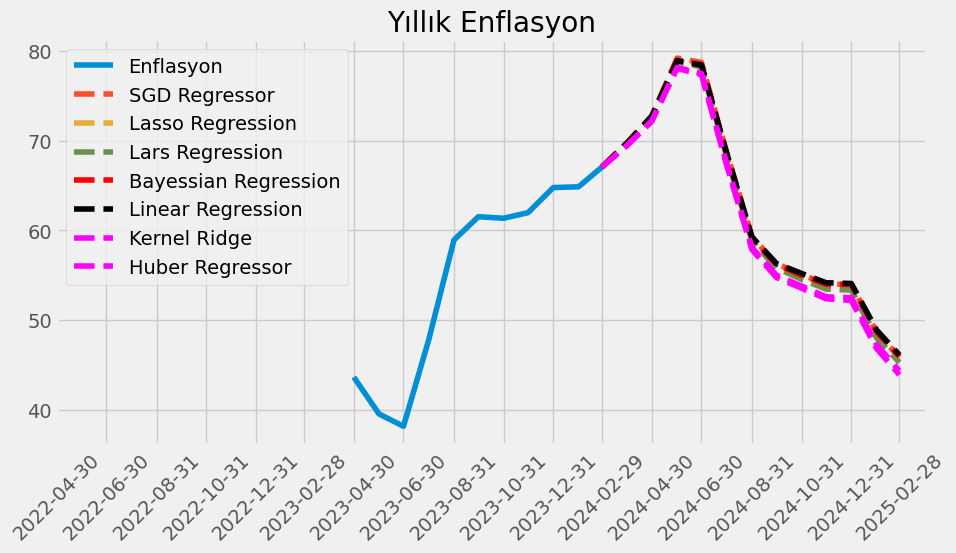

In [795]:
plt.style.use("fivethirtyeight")
yıllıktahmin=pd.DataFrame()
yıllıktahmin["Ortalama"]=tüfetahmin11["CPI"]
yıllıktahmin["SGD Regressor"]=tüfetahmin13["CPI"]
yıllıktahmin["Lasso Regression"]=tüfetahmin14["CPI"]
yıllıktahmin["Lars Regression"]=tüfetahmin15["CPI"]
yıllıktahmin["Bayessian Regression"]=tüfetahmin17["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
yıllıktahmin["Kernel Ridge"]=tüfetahmin20["CPI"]
yıllıktahmin["Baz Senaryo"]=tüfetahmin100["CPI"]
yıllıktahmin["Huber Regressor"]=tüfetahmin21["CPI"]
yıllıktahmin["İyimser Senaryo Ortalama"]=tüfetahmin1100["CPI"]
plt.figure(figsize=(10,5))
plt.plot(yıllıktahmin["Ortalama"].iloc[13:24],label="Enflasyon")
plt.plot(yıllıktahmin["SGD Regressor"].iloc[23:-2],'--',label="SGD Regressor")
plt.plot(yıllıktahmin["Lasso Regression"].iloc[23:-2],'--',label="Lasso Regression")
plt.plot(yıllıktahmin["Lars Regression"].iloc[23:-2],'--',label="Lars Regression")
plt.plot(yıllıktahmin["Bayessian Regression"].iloc[23:-2],'--',label="Bayessian Regression",color="red")
plt.plot(yıllıktahmin["Linear Regression"].iloc[23:-2],'--',label="Linear Regression",color="black")
plt.plot(yıllıktahmin["Kernel Ridge"].iloc[23:-2],'--',label="Kernel Ridge",color="magenta")
plt.plot(yıllıktahmin["Huber Regressor"].iloc[23:-2],'--',label="Huber Regressor",color="magenta")
plt.legend(loc=0)
plt.xticks(yıllıktahmin.index[1:-2:2],rotation=45)
#plt.xticks(pd.date_range(start="2022-12-30",end="2025-01-27",freq="1M")[::2])
plt.title("Yıllık Enflasyon")
plt.show()

In [796]:
yıllıktahmin["Maksimum"]=tüfetahmin23["CPI"]
yıllıktahmin["Minimum"]=tüfetahmin24["CPI"]
yıllıktahmin

,Ortalama,SGD Regressor,Lasso Regression,Lars Regression,Bayessian Regression,Linear Regression,Kernel Ridge,Baz Senaryo,Huber Regressor,İyimser Senaryo Ortalama,Maksimum,Minimum
2022-03-31,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538
2022-04-30,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070
2022-05-31,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950
2022-06-30,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397
2022-07-31,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053
2022-08-31,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594
2022-09-30,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494
2022-10-31,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786
2022-11-30,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260
2022-12-31,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597


In [797]:
yıllıktahmin1=yıllıktahmin[['Baz Senaryo', 'SGD Regressor', 'Lasso Regression', 'Lars Regression',
       'Bayessian Regression', 'Linear Regression', 'Kernel Ridge','Huber Regressor', 'Maksimum',
       'Minimum']]

yıllıktahmin1.columns=['Ortalama', 'SGD Regressor', 'Lasso Regression', 'Lars Regression',
       'Bayessian Regression', 'Linear Regression', 'Kernel Ridge','Huber Regressor', 'Maksimum',
       'Minimum']
yıllıktahmin1.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/yıllıktahmin.csv')

In [798]:
sonu2023=str(yıllıktahmin.iloc[22,-5])[:5]
tepe=str(yıllıktahmin.iloc[26,-5])[:5]
sonu2024=str(yıllıktahmin.iloc[33,-5])[:5]
max=str(yıllıktahmin.iloc[-5,-5])[:5]
min=str(yıllıktahmin.iloc[-5,-5])[:5]


In [799]:
sonu12024=str(yıllıktahmin.iloc[34,-3])[:5]

In [800]:
min1=str(yıllıktahmin.iloc[33,-1])[:2]
max1=str(yıllıktahmin.iloc[33,-2])[:2]

In [801]:
cariay=evds.get_data(["TP.PKAUO.S01.A.U"],startdate="01-11-2022",enddate="28-03-2024")
cariay=cariay.set_index(pd.date_range(start="2022-11-30",periods=17,freq="1M"))
del cariay["Tarih"]
cariay.columns=["Cari Ay Medyan Tahmin"]
cariay["TÜFE"]=df.iloc[-14:,0].shift(1).dropna()
cariay["Cari Ay Medyan Tahmin"]=1+(cariay["Cari Ay Medyan Tahmin"]/100)
cariay.iloc[-1,1]=2073.88
cariay["Enflasyon"]=cariay["Cari Ay Medyan Tahmin"]*cariay["TÜFE"]
cariay["TÜFE Önceki"]=df.iloc[-25:,0].shift(12).dropna()
cariay.iloc[-1,3]=1269.75
cariay["Enflasyon"]=((cariay["Enflasyon"]/cariay["TÜFE Önceki"])-1)*100
cariay

,Cari Ay Medyan Tahmin,TÜFE,Enflasyon,TÜFE Önceki
2022-11-30,1.0314,NaN,NaN,NaN
2022-12-31,1.0269,NaN,NaN,NaN
2023-01-31,1.0265,NaN,NaN,NaN
2023-02-28,1.0301,1203.48,54.976654,799.93
2023-03-31,1.0288,1241.33,51.377401,843.64
2023-04-30,1.0265,1269.75,44.055347,904.79
2023-05-31,1.0241,1300.04,42.887757,931.76
2023-06-30,1.0281,1300.60,36.736564,977.90
2023-07-31,1.0376,1351.59,40.096679,1001.03
2023-08-31,1.0554,1479.84,53.775724,1015.65


In [802]:
ay1sonra=evds.get_data(["TP.PKAUO.S01.B.U"],startdate="01-03-2024",enddate="28-03-2024")
ay1sonra["TÜFE"]=2073.88*1.0343
ay1sonra["TÜFE Yeni"]=(1+(ay1sonra["TP_PKAUO_S01_B_U"]/100))*ay1sonra["TÜFE"]
ay1sonra["TÜFE Eski"]=df.loc["2023-04-30"]["CPI"]
ay1sonra["Enflasyon"]=((ay1sonra["TÜFE Yeni"]/ay1sonra["TÜFE Eski"])-1)*100
ay1sonra

,Tarih,TP_PKAUO_S01_B_U,TÜFE,TÜFE Yeni,TÜFE Eski,Enflasyon
0,2024-3,3.42,2145.014084,2218.373566,1300.04,70.63887


In [803]:
ay2sonra=evds.get_data(["TP.BEK.S01.C.U"],startdate="01-03-2024",enddate="31-12-2024")
ay2sonra["TÜFE"]=2145.01*1.0342
ay2sonra["TÜFE Yeni"]=(1+(ay2sonra["TP_BEK_S01_C_U"]/100))*ay2sonra["TÜFE"]
ay2sonra["TÜFE Eski"]=df.loc["2023-04-30"]["CPI"]
ay2sonra["Enflasyon"]=((ay2sonra["TÜFE Yeni"]/ay2sonra["TÜFE Eski"])-1)*100
ay2sonra

,Tarih,TP_BEK_S01_C_U,TÜFE,TÜFE Yeni,TÜFE Eski,Enflasyon
0,2024-3,2.82,2218.369342,2280.927357,1300.04,75.450552


In [804]:
ay12sonra=evds.get_data(["TP.PKAUO.S01.D.U"],startdate="01-03-2024",enddate="31-12-2024")
ay12sonra.columns=["Tarih","12 Ay Sonrası"]
ay12sonra

,Tarih,12 Ay Sonrası
0,2024-3,44.19


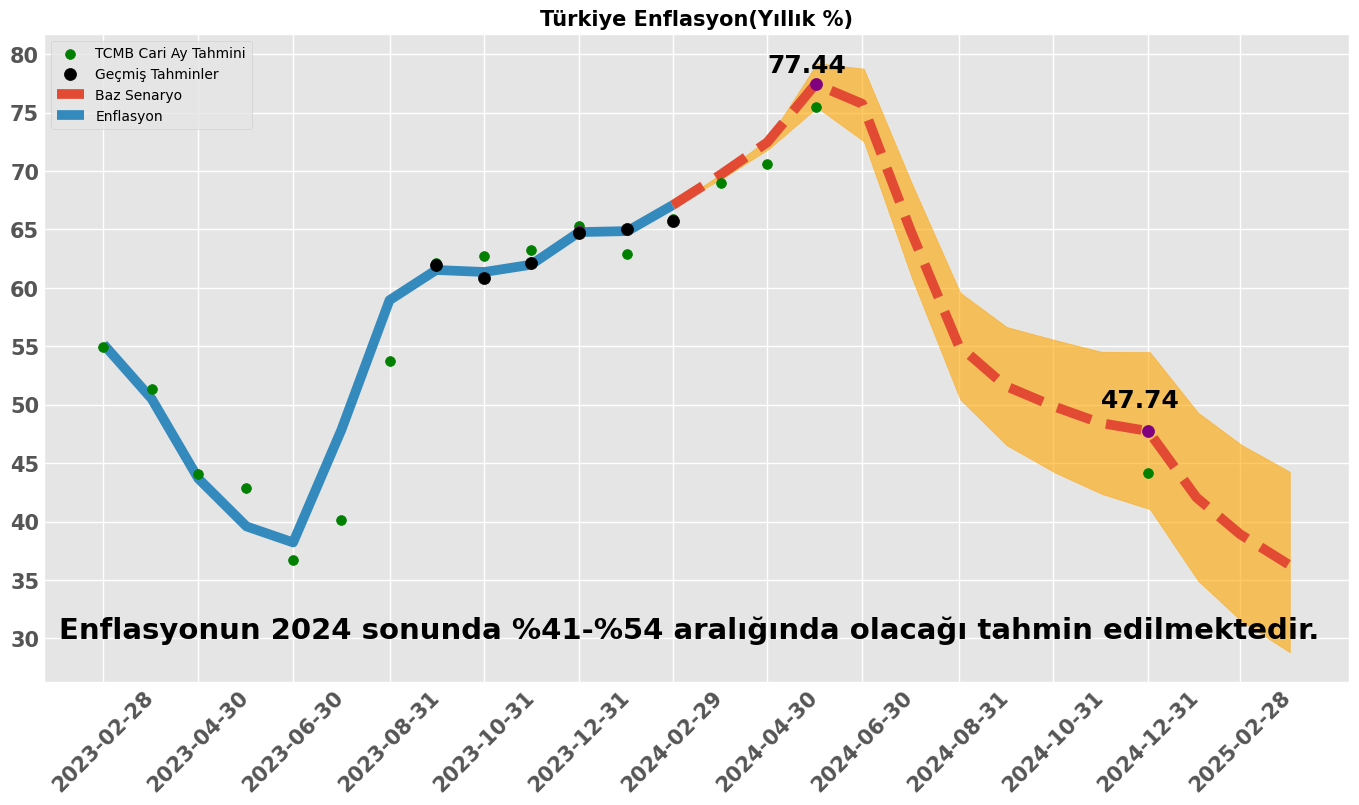

In [805]:
import matplotlib.dates as mdates  # datetime işlevlerini içe aktarın

# ...

plt.style.use('ggplot')
fig=plt.figure(figsize=(15,8))
plt.scatter(x=pd.to_datetime("2024-04-30"),y=ay1sonra["Enflasyon"],color="green",zorder=3,s=50)
plt.scatter(x=pd.to_datetime("2024-05-31"),y=ay2sonra["Enflasyon"],color="green",zorder=3,s=50)
plt.scatter(x=cariay[2:].index,y=cariay["Enflasyon"][2:].values,color="green",zorder=3,label='TCMB Cari Ay Tahmini',s=50)
plt.scatter(x=pd.to_datetime("2024-12-31"),y=ay12sonra["12 Ay Sonrası"].values,color="green",zorder=3,s=50)
plt.scatter(x=yıllıktahmin.index[18:24],y=[61.94,60.84,62.13,64.71,65.06,65.73],color='black',zorder=4,label='Geçmiş Tahminler',s=75)
plt.scatter(x=yıllıktahmin.index[21],y=yıllıktahmin.iloc[21,-5],color='purple',zorder=3,s=75)
plt.scatter(x=yıllıktahmin.index[26],y=yıllıktahmin.iloc[26,-5],color='purple',zorder=3,s=75)
plt.scatter(x=yıllıktahmin.index[33],y=yıllıktahmin.iloc[33,-5],color='purple',zorder=3,s=75)
"""plt.scatter(x=yıllıktahmin.index[34],y=yıllıktahmin.iloc[34,-3],color='blue',zorder=3,s=75)"""
plt.plot(yıllıktahmin["Baz Senaryo"].iloc[23:-1],'--',label="Baz Senaryo",linewidth=7)
"""plt.plot(yıllıktahmin["İyimser Senaryo Ortalama"].iloc[24:-1],'--',label="İyimser Senaryo",linewidth=7)"""
plt.plot(yıllıktahmin["Ortalama"].iloc[11:24],label="Enflasyon",linewidth=7)
plt.fill_between(yıllıktahmin.iloc[23:].index.strftime("%Y-%m"), yıllıktahmin["Maksimum"].iloc[23:].shift(1), yıllıktahmin["Minimum"].iloc[23:].shift(1), alpha=0.6, color='orange')
annotation_date = mdates.datestr2num('2025-04')
plt.text(mdates.datestr2num('2024-06'), float(tepe)+1, tepe, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
"""plt.text(mdates.datestr2num('2025-01'), float(sonu2024)+2, sonu2024, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')"""
plt.text(mdates.datestr2num('2025-01'), float(sonu2024)+2, sonu2024, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 30, f"Enflasyonun 2024 sonunda %{min1}-%{max1} aralığında olacağı tahmin edilmektedir.", fontsize=21, color='black', horizontalalignment='right',fontweight='bold')
plt.xticks(yıllıktahmin.index[11:37:2],rotation=45,fontsize=15,fontweight="bold")
plt.yticks(np.arange(30,85,5),fontsize=15,fontweight="bold")
plt.title("Türkiye Enflasyon(Yıllık %)",fontsize=15,fontweight="bold")
plt.legend(loc=2)
plt.savefig('forecast.png')
plt.savefig("./forecasts/"+date.today().strftime("%d-%m-%Y")+'.png')
plt.show()


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '2023-09'),
  Text(1, 0, '2023-10'),
  Text(2, 0, '2023-11'),
  Text(3, 0, '2023-12'),
  Text(4, 0, '2024-01'),
  Text(5, 0, '2024-02')])

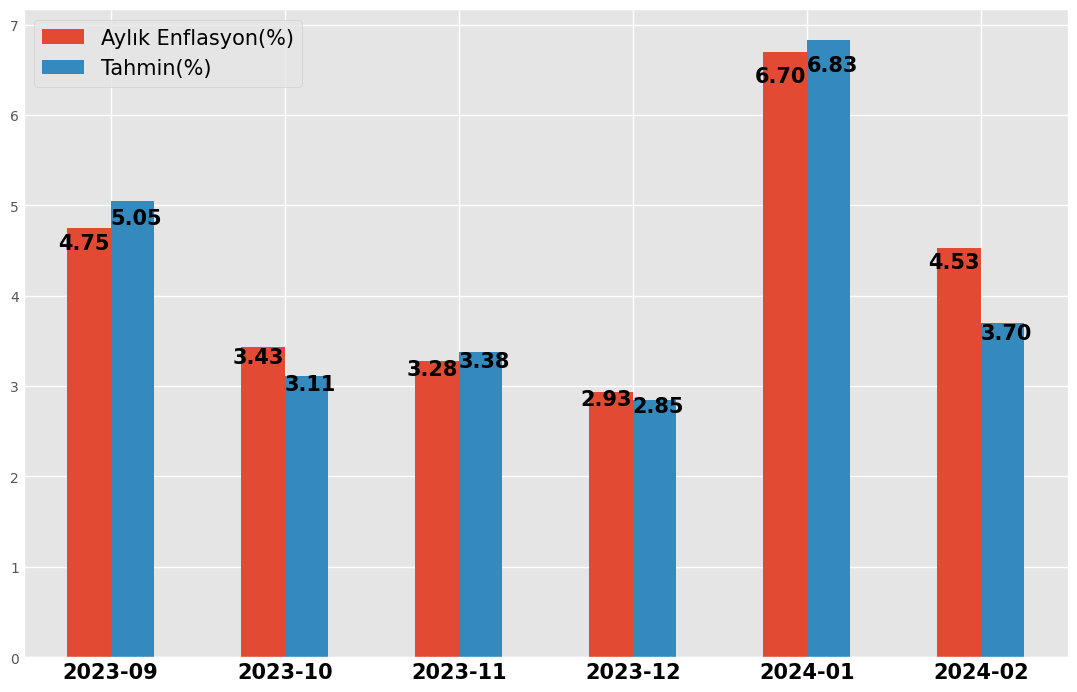

In [806]:
import matplotlib.axes as ax
gecmis=pd.DataFrame({"Aylık Enflasyon(%)":[4.75,3.43,3.28,2.93,6.70,4.53],"Tahmin(%)":[5.05,3.11,3.38,2.85,6.83,3.70]})
gecmis=gecmis.set_index(pd.date_range(start="2023-09-30",periods=6,freq="M"))
gecmis=gecmis.set_index(gecmis.index.strftime("%Y-%m"))
gecmis.plot(kind="bar",figsize=(12,8))
plt.annotate("4.75",xy=(-0.3,gecmis.iloc[0,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("5.05",xy=(0,gecmis.iloc[0,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.43",xy=(0.7,gecmis.iloc[1,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.11",xy=(1,gecmis.iloc[1,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.28",xy=(1.7,gecmis.iloc[2,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.38",xy=(2,gecmis.iloc[2,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.93",xy=(2.7,gecmis.iloc[3,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.85",xy=(3,gecmis.iloc[3,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("6.70",xy=(3.7,gecmis.iloc[4,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("6.83",xy=(4,gecmis.iloc[4,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("4.53",xy=(4.7,gecmis.iloc[5,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.70",xy=(5,gecmis.iloc[5,1]*0.95),fontweight="bold",fontsize=15)


plt.legend(fontsize=15)
plt.xticks(rotation=0,fontweight="bold",fontsize=15,color="black")

In [807]:
aralık=aylıktahmin.iloc[0,-1]
aralık = "{:.2f}".format(aralık)
sonu2023=yıllıktahmin.loc["2023-12-31","Ortalama"]
sonu2023="{:.2f}".format(sonu2023)
sonu2024=yıllıktahmin.loc["2024-12-31","Ortalama"]
sonu2024="{:.2f}".format(sonu2024)


In [808]:
aylıktahmin.iloc[:-3,-3]

2024-03-31    3.976446
2024-04-30    4.177351
2024-05-31    3.767791
2024-06-30    3.646653
2024-07-31    3.457490
2024-08-31    3.068288
2024-09-30    2.821004
2024-10-31    2.698918
2024-11-30    2.613975
2024-12-31    2.910891
2025-01-31    3.122654
Name: Maksimum, dtype: float64

Text(8.75, 2.3238359870897556, '2.44')

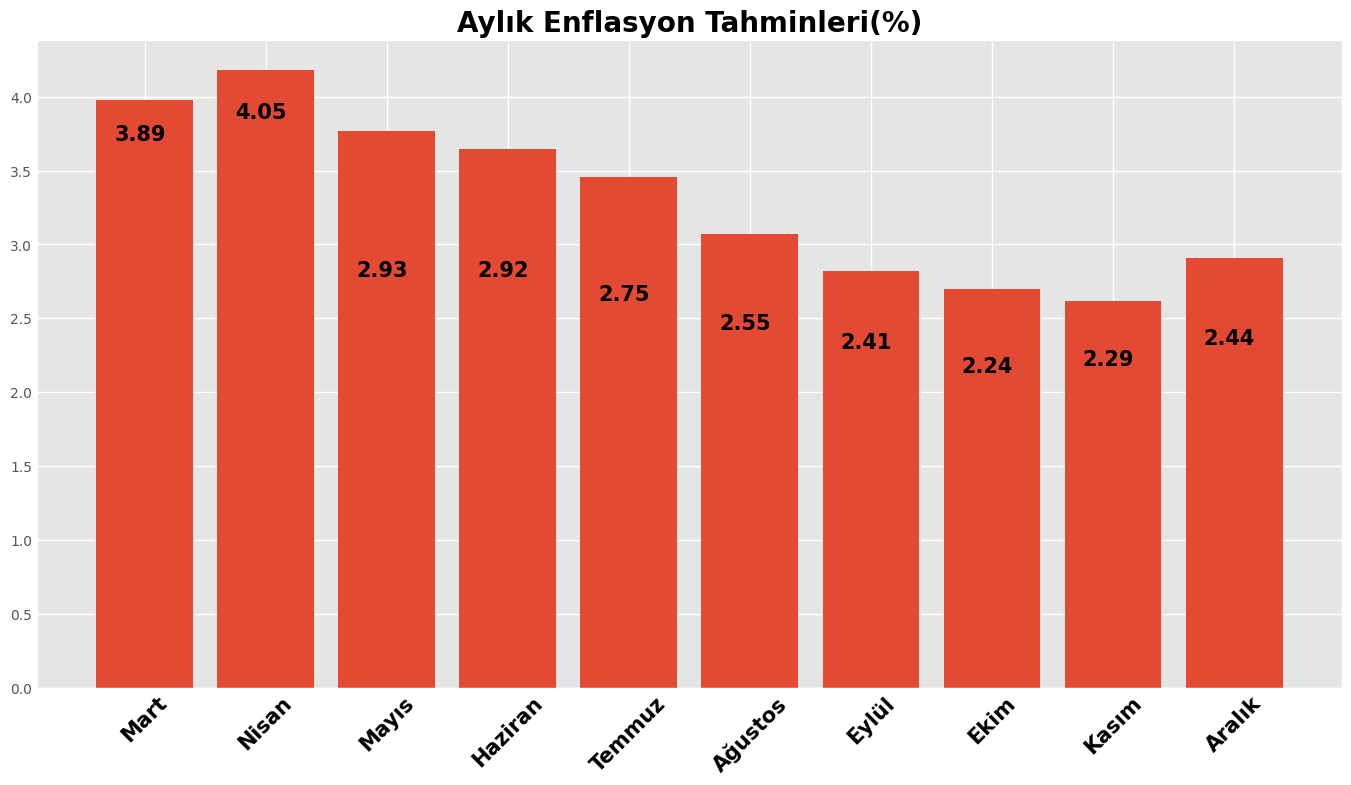

In [809]:
plt.figure(figsize=(15,8))
plt.bar(x=["Mart","Nisan","Mayıs","Haziran","Temmuz","Ağustos","Eylül","Ekim","Kasım","Aralık"],height=aylıktahmin.iloc[:-4,-3])
plt.xticks(rotation=45,fontweight="bold",color="black",fontsize=15)
plt.title("Aylık Enflasyon Tahminleri(%)",fontweight="bold",fontsize=20)
plt.annotate(str(aylıktahmin.iloc[0,-1])[:4],xy=(-0.25,aylıktahmin.iloc[0,-1]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[1,-1])[:4],xy=(0.75,aylıktahmin.iloc[1,-1]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[2,-1])[:4],xy=(1.75,aylıktahmin.iloc[2,-1]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[3,-1])[:4],xy=(2.75,aylıktahmin.iloc[3,-1]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[4,-1])[:4],xy=(3.75,aylıktahmin.iloc[4,-1]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[5,-1])[:4],xy=(4.75,aylıktahmin.iloc[5,-1]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[6,-1])[:4],xy=(5.75,aylıktahmin.iloc[6,-1]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[7,-1])[:4],xy=(6.75,aylıktahmin.iloc[7,-1]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[8,-1])[:4],xy=(7.75,aylıktahmin.iloc[8,-1]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[9,-1])[:4],xy=(8.75,aylıktahmin.iloc[9,-1]*0.95),fontweight="bold",fontsize=15)

